# Airbus Ship Detection Challenge
Find ships on satellite images as quickly as possible

## Prepare datasets
The train_ship_segmentations.csv file provides the ground truth (in run-length encoding format) for the training images. The sample_submission files contains the images in the test images.

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image

import time

from skimage.data import imread
import matplotlib.pyplot as plt
import os
import random
np.set_printoptions(threshold=np.inf)   # print all numpy ndarray

## For MS COCO
import datetime
import json
import re
import fnmatch
from pycococreatortools import pycococreatortools



Specify datasets location

In [2]:
datasets_base = '/media/zitong/Seagate Backup Plus Drive/datasets/airbus/'

dataset_train = '/media/zitong/Seagate Backup Plus Drive/datasets/airbus/train_v2'
csv_train =     '/media/zitong/Seagate Backup Plus Drive/datasets/airbus/train_ship_segmentations_v2.csv'

dataset_test  = '/media/zitong/Seagate Backup Plus Drive/datasets/airbus/test_v2'
csv_test =      '/media/zitong/Seagate Backup Plus Drive/datasets/airbus/final.csv'   # should not use .csv file with empty image !

### Delete useless images

Total number of ship

In [3]:
# read_csv_file
df = pd.read_csv(csv_train)

print(type(df))
totalLines = df.shape[0]
print("Dataframe lines: ",df.shape[0])
print("Dataframe dimension: ",df.shape)

<class 'pandas.core.frame.DataFrame'>
Dataframe lines:  231723
Dataframe dimension:  (231723, 2)


Drop the rows where at least one element is missing. (delete annotations without ship)

In [4]:
df = df.dropna(axis=0)
num_of_ships = df.shape[0]
print("Instances: ",num_of_ships)
# print("percent of useful data: ", num_of_ships / totalLines * 100)

Instances:  81723


Create an empty set to store images with ship. The reason we use set is to avoid duplicate elements.
Note that the set method initialize images with an empty set.

Use df.iloc[] to access elements in the 2d array https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html
We only care about the id of the image in col 1. The return type of df.iloc[line,0] is a string.

ims is a list which stores all the file name (.jpg) stored in the training set folder.

In [5]:
images = set()
# print(type(df.iloc[1, 0]))
for line in range(num_of_ships):
    if df.iloc[line,0] not in images:
        images.add(df.iloc[line,0])
print("Images with ship: ",len(images))

# Delete images without ship
count = 0
ims = os.listdir(dataset_train)
# print(type(ims))
# print(ims[0])

for im in ims:
    if im not in images:
        os.remove(os.path.join(dataset_train, im))
        print(im, "REMOVED")
        count += 1
print('%d images is deleted.'%(count))

Images with ship:  42556
0 images is deleted.


### Show RLE

#### Convert RLE to numpy
Convert mask_rle, a string that stores mask information, to np.ndarry(np.unit8). The reason we let starts -= 1 is because numpy array starts at index 0.  


asarray() converts a list to a numpy array. 

the double colon (::) gets every n-th element from the list / array

The zip() function returns a zip object, which is an iterator of tuples where the first item in each passed iterator is paired together, and then the second item in each passed iterator are paired together etc. If the passed iterators have different lengths, the iterator with the least items decides the length of the new iterator.



In [6]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode

# shape: (height,width) , 1 - mask, 0 - background
def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    print(type(s[0]))
    starts =  np.asarray(s[0::2], dtype=int)
    lengths = np.asarray(s[1::2], dtype=int)

    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

#### Show Mask

<class 'str'>
Area:  1599


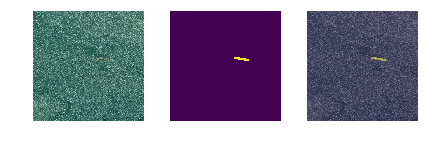

In [7]:
def csv_show_rle(ImageId, dataset_dir, df):
    img = imread(os.path.join(dataset_dir, ImageId))
    rle_masks = df.loc[df['ImageId'] == ImageId, 'EncodedPixels'].tolist()

    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768))
    for mask in rle_masks:
        binary_mask = rle_decode(mask)
        print('Area: ', np.sum(binary_mask))
        all_masks += binary_mask

    fig, axarr = plt.subplots(1, 3)
    axarr[0].axis('off'),
    axarr[1].axis('off'),
    axarr[2].axis('off')
    axarr[0].imshow(img),
    axarr[1].imshow(all_masks),
    axarr[2].imshow(img)
    axarr[2].imshow(all_masks, alpha=0.4)
    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    # plt.savefig( os.path.join(ROOT_DIR, '../tmp', 'tmp.png') )
    plt.show()


# dataset_train = '../datasets/ships_train2018'
# dataset_test  = '../datasets/ships_test2018'
# csv_train =     '../datasets/train_ship_segmentations_v2.csv'
# csv_test =      '../2_submit/final.csv'   # should not use .csv file with empty image !

df = pd.read_csv(csv_train)
# ImageId_list = ['0ba29cbcf.jpg', '00fd8e126.jpg', '0b1b3d75b.jpg']
ImageId_list = os.listdir(dataset_train)
ImageId = random.choice(ImageId_list)
csv_show_rle(ImageId, dataset_train, df)

### Convert RLE to MS COCO Format

In [8]:
IMAGE_DIR = dataset_train
start_time = time.time() # record time
df = pd.read_csv(csv_train)

INFO = {
    "description": "Kaggle Dataset",
    "url": "https://github.com/pascal1129",
    "version": "0.1.0",
    "year": 2018,
    "contributor": "ztzhan",
    "date_created": datetime.datetime.utcnow().isoformat(' ')
}

LICENSES = [
    {
        "id": 1,
        "name": "Attribution-NonCommercial-ShareAlike License",
        "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/"
    }
]

CATEGORIES = [
    {
        'id': 1,
        'name': 'ship',
        'supercategory': 'ship',
    },
]



# json file
coco_output = {
    "info": INFO,
    "licenses": LICENSES,
    "categories": CATEGORIES,
    "images": [],   # we will append some data here later
    "annotations": []
}


'''
keep files ended in .jpeg or .jpg
'''
def filter_for_jpeg(root, files):
    file_types = ['*.jpeg', '*.jpg']
    file_types = r'|'.join([fnmatch.translate(x) for x in file_types])
    files = [os.path.join(root, f) for f in files]
    files = [f for f in files if re.match(file_types, f)]
    return files

def save_bad_ann(image_name, mask, segmentation_id):
    img = imread(os.path.join(IMAGE_DIR, image_name))
    fig, axarr = plt.subplots(1, 3)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[2].axis('off')
    axarr[0].imshow(img)
    axarr[1].imshow(mask)
    axarr[2].imshow(img)
    axarr[2].imshow(mask, alpha=0.4)
    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    if not os.path.exists(datasets_base+'/tmp'):
        os.makedirs(datasets_base+'/tmp')
        print('make a new dir to store bad ann')
    plt.savefig( datasets_base+'/tmp/'+ image_name.split('.')[0] +'_' +str(segmentation_id) +'.png') 
    plt.close()

    

## main method starts here
image_id = 1
segmentation_id = 1

# TODO: to be removed
def get_image_id():
    return image_id

def get_segmentation_id():
    return segmentation_id

'''
os.walk(top, topdown=True, onerror=None, followlinks=False) 

Generate the file names in a directory tree by walking the tree either top-down or bottom-up. 
For each directory in the tree rooted at directory top (including top itself), 
it yields a 3-tuple (dirpath, dirnames, filenames).

dirpath is a string, the path to the directory. 
dirnames is a list of the names of the subdirectories in dirpath (excluding '.' and '..'). 
filenames is a list of the names of the non-directory files in dirpath. 
Note that the names in the lists contain no path components. 
To get a full path (which begins with top) to a file or directory in dirpath, do os.path.join(dirpath, name).
'''

def processImage(image_path):
    image_id = get_image_id()
    segmentation_id = get_segmentation_id()
    
    # create image information
    image = Image.open(image_path)
    image_name = os.path.basename(image_path) # that is the file name, complete path = dir name + basename
    image_info = pycococreatortools.create_image_info(
        image_id, image_name, image.size)
    coco_output["images"].append(image_info)

    # get mask of image, note that each image may contain multiple masks, do not forget the tolist()
    rle_masks = df.loc[df['ImageId'] == image_name, 'EncodedPixels'].tolist() 
    num_of_rle_masks = len(rle_masks)

    print(image_name, '# of masks', num_of_rle_masks)

    for index in range(num_of_rle_masks):
        binary_mask = rle_decode(rle_masks[index])
        class_id = 1    # all image (mask) has the lable 1, according to which we've defined before
        category_info = {'id': class_id, 'is_crowd': 0}
        annotation_info = pycococreatortools.create_annotation_info(
            segmentation_id, image_id, category_info, binary_mask,
            image.size, tolerance=2)

        # we do not keep all the images since some of them were not well annotated
        # 
        if annotation_info is not None: # if ann quality is too low we do not assign ann_info
            coco_output["annotations"].append(annotation_info)
        else:
            save_bad_ann(image_name, binary_mask, segmentation_id)

        # in any case, no matter good or bad ann, assign a seg_id
        segmentation_id = segmentation_id + 1   

    print("%d of %d is done."%(image_id,num_of_image_files))
    image_id = image_id + 1

import concurrent.futures
import multiprocessing
    
for root, _, files in os.walk(IMAGE_DIR): # In fact this is not a real for loop, it only loops once
#     print('type(root)', type(root))
#     print('type(_)', type(_))
#     print('type(files)', type(files))
    print((root))
#     print((_)) # this one is not needed since it list all the folders
#     print((files)) # this is a list of file's base name
    image_paths = filter_for_jpeg(root, files)  # complete path (file name included)
    num_of_image_files = len(image_paths) 

    # traverse through all images
    #     for image_path in image_paths:
    
# TODO: https://docs.python.org/zh-cn/3/library/multiprocessing.html#module-multiprocessing.sharedctypes
with concurrent.futures.ProcessPoolExecutor() as executor:
    executor.map(processImage, image_paths)    

# processes = []
# for image_path in image_paths:
#     p = multiprocessing.Process(target =  processImage, args = [image_path])
#     p.start()
#     processes.append(p)
    
# for process in processes:
#     process.join()

with open( (datasets_base + '/instances_ships_train2018.json'), 'w') as output_json_file:
    # json.dump(coco_output, output_json_file)
    json.dump(coco_output, output_json_file, indent=4)
    
print("--- %s seconds ---" % (time.time() - start_time)) 

/media/zitong/Seagate Backup Plus Drive/datasets/airbus/train_v2
000194a2d.jpg # of masks 5
00021ddc3.jpg # of masks 9
<class 'str'>
872de369e.jpg # of masks 1
00053c6ba.jpg # of masks 1
872cd64f0.jpg # of masks 1
0002756f7.jpg # of masks 2
000532683.jpg # of masks 2
<class 'str'>
0005d01c8.jpg # of masks 2
00031f145.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
3a06e90d4.jpg # of masks 1
<class 'str'>
<class 'str'>
d24ca864b.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
000155de5.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
d24d0543c.jpg # of masks 2
1 of 42556 is done.
5a92f6a55.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
001bcf222.jpg # of masks 1
0022f64e5.jpg # of masks 1
<class 'str'>
<class 'str'>
002c62c

1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
930b6be1c.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
930f575fa.jpg # of masks 3
930fb2044.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
931a89ac1.jpg # of masks 1
1 of 42556 is done.
93221b82b.jpg # of masks 1
<class 'str'>
<class 'str'>
93190ce06.jpg # of masks 1
9326704a8.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
932bcbb24.jpg # of masks 1
<class 'str'>
933431d97.jpg # of masks 1
<class 'str'>
11c4cba09.jpg # of masks 2
932ef626d.jpg # of masks 2
9331e5f62.jpg # of masks 2
93290f954.jpg # of masks 2
<class 'str'>
<class 'str'>
11c45aa92.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.


<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
b5c9591d5.jpg # of masks 1
<class 'str'>
<class 'str'>
de87a31d8.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
de86d704a.jpg # of masks 5
<class 'str'>
de855d79b.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
cd1602e93.jpg # of masks 3
cd1b31403.jpg # of masks 1
1 of 42556 is done.
284814a44.jpg # of masks 1
<class 'str'>
284e59aca.jpg # of masks 2
cd0080227.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
cd220bcd7.jpg # of masks 1
cd20f5ebf.jpg 

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1ee44196f.jpg # of masks 1
1ee4150d2.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1ee566913.jpg # of masks 1
<class 'str'>
09d49287d.jpg # of masks 2
<class 'str'>
fb5782131.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
53e88abe7.jpg # of masks 1
1 of 42556 is done.
905f5cc96.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1bca838a2.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
9fdecb5d2.jpg # of masks 1
1 of 42556 is done.
9fe15853c.jpg # of mask

31ee3e119.jpg # of masks 1
06cb32197.jpg # of masks 1
06c880a4c.jpg # of masks 2
<class 'str'>
a57649910.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
a57867903.jpg # of masks 1
a5790a2e2.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
d38e1857c.jpg # of masks 3
ce7ce4fdd.jpg # of masks 5
ce7a9e453.jpg # of masks 2
ce7a0f083.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
d39002642.jpg # of masks 1
ce7c2d412.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
666ff7ace.jpg # of masks 12
666e8563f.jpg # of masks 1
666f2acb9.jpg #

1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
38e10f203.jpg # of masks 1
<class 'str'>
38e143e8b.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8b4bd8173.jpg # of masks 3
1 of 42556 is done.
635504fb5.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
8b4c9584a.jpg # of masks 1
ddacdf5f1.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
ddad0ced8.jpg # of masks 1
ddaf4de2f.jpg # of masks 1
ddad8ae16.jpg # of masks 7
1 of 42556 is done.
1 of 42556 is done.
82055eccc.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
8207b43e9.jpg # of masks 1
baf1c4609.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 i

1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
3215834b5.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
321c9149f.jpg # of masks 1
3220a767d.jpg # of masks 5
<class 'str'>
3224933c1.jpg # of masks 1
321f065ec.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
32277b0a7.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
322946655.jpg # of masks 1
<class 'str'>
322e4aa7b.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1a9316a6d.jpg # of masks 9
<class 'str'>
<class 'str'>
2783506ad.jpg # of masks 1
3236047eb.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
5d6a6b550.jpg # of masks 2
322f8a8e5.jpg # of masks 11
3231880bc.jpg # of masks 1
2782d61a0.jpg # of masks 1
<class 'str'>


4f9d4d9e6.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
4d8769eb9.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
8544f0b33.jpg # of masks 1
<class 'str'>
85452646a.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
8547e21e3.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
8548aa678.jpg # of masks 1
4d895689c.jpg # of masks 2
4d8b01779.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
7e2742873.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
7e2d1c799.jpg # of masks 1
7e5631fcb.jpg # of masks 3
<class 'str'>
7e481c03d.jpg # of masks 2
7e328f84b.jpg # of masks 1
<class 'str'>
7e3b615ca.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>


52b60abf1.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
6cba09793.jpg # of masks 1
52bb43528.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
6cbb2ed62.jpg # of masks 1
1 of 42556 is done.
d6f5c7649.jpg # of masks 1
fc61d98be.jpg # of masks 1
6cbade284.jpg # of masks 1
fc624e92a.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
fc64a24c7.jpg # of masks 1
<class 'str'>
<class 'str'>
d6f5a3f16.jpg # of masks 5
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
d6f4a1e1c.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
193fb0502.jpg # of masks 2
6cbbfda11.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.

<class 'str'>
4c4d54a27.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
f487ee615.jpg # of masks 1
4c4c8f333.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
f97fab9ad.jpg # of masks 1
f982af57b.jpg # of masks 1
<class 'str'>
f98022dd0.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
0d4704282.jpg # of masks 2
f97fd4915.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
f9821ea00.jpg # of masks 10
f982932f1.jpg # of masks 1
<class 'str'>
0d478d034.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
0d4adbb1f.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
<class 'str'>
6aedf0e18.jpg # of masks 2
<class 'str'>
<cla

1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
f4aecacdf.jpg # of masks 1
f4b364768.jpg # of masks 3
f4b494ecd.jpg # of masks 1
f4b6d7cc0.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
f4b962d13.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
f4bd4c5da.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
f4c146241.jpg # of masks 1
1 of 42556 is done.
f4ccec6cb.jpg # of masks 2
<class 'str'>
f4ce60ef1.jpg # of masks 2
1 of 42556 is done.
f4ca94419.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
f4d80a517.jpg # of masks 1
<class 'str'>
f4df07423.jpg # of masks 1
f4d366063.jpg # of masks 1
<class 'str'>
<class 'str'>
f4e5e812b.jpg # o

<class 'str'>
<class 'str'>
75496d1ee.jpg # of masks 1
1 of 42556 is done.
b9c4b1709.jpg # of masks 1
<class 'str'>
754a2c24d.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
b9c532adf.jpg # of masks 1
754c25bea.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
d5c3518f8.jpg # of masks 1
d5c217989.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
f347168b6.jpg # of masks 3
754e35e53.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
f34963a22.jpg # of masks 1
1 of 42556 is done.
f349ce414.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
3610ec595.jpg # of masks 2
596592a33.jpg # of masks 1
<class 'str'>
<class 'str'>
360e6acc1.jpg # of masks 1
1 of 42556 is done.
f34aa9d4c.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
3cb88d629.jpg # of masks 2
3cc907

<class 'str'>
704361353.jpg # of masks 1
704197ecf.jpg # of masks 11
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
645c77ddb.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
e5b1d8724.jpg # of masks 10
e5b114139.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
e5b285b8e.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
e5b373889.jpg # of masks 1
4e2bca446.jpg # of masks 1
4e2fdf4fa.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
4e3393ed5.jpg # of masks 6
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
4e488d282.jpg # of masks 1
4e3f9df22.jpg # of masks 10
<

1 of 42556 is done.
<class 'str'>
<class 'str'>
2a32700ab.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
2a38301be.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
2a3f9e3b0.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
2a3bf8245.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
a0c8b46e5.jpg # of masks 2
2a420bcca.jpg # of masks 2
a0c8f4553.jpg # of masks 1
6b6635371.jpg # of masks 3
<class 'str'>
6b663afaf.jpg # of masks 1
<class 'str'>
6b6689889.jpg # of masks 1
1 of 42556 is done.
b56d15b7d.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
3abea2796.jpg # of masks 1
3abd75d1d.jpg # of masks 2
05a6cbc54.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
6c2cd4964.jpg # of masks 1
<class 'str'>
6c2dbd689.jpg # of ma

f8a92872d.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
a3bc39e62.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
a3bc58a82.jpg # of masks 1
a3bcc4a50.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
e322f442d.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
e324f13b4.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
e32634dff.jpg # of masks 1
90e8c65aa.jpg # of masks 9
<class 'str'>
<class 'str'>
49f255650.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
<class 'str'>
693e1e4f8.jpg # of masks 6
<class 'str'>
<class 'str'>
1 of 42556 is done.
693c28e4e.jpg # of masks 5
1 of 42556 is done.
<class 'str'>
<class 'str'>
98130c04c.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556

1 of 42556 is done.
c4d3c4c8c.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
c4d887f0b.jpg # of masks 5
<class 'str'>
<class 'str'>
1 of 42556 is done.
c4e5e0ef1.jpg # of masks 8
<class 'str'>
c4e81b7e4.jpg # of masks 3
1 of 42556 is done.
c4dd8a801.jpg # of masks 1
<class 'str'>
<class 'str'>
c4ec4793b.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
c4f266cfc.jpg # of masks 1
b40712941.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
2d6923fa6.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
2d6b8a130.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
2d6b546b0.jpg # of masks 7
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
a71fb3ef4.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
a720edcd2.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str

215cb0be2.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
48b8dbe4d.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
48bae3234.jpg # of masks 1
<class 'str'>
<class 'str'>
215db208f.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
23801cced.jpg # of masks 1
<class 'str'>
215f28352.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
2381e0fcb.jpg # of masks 1
<class 'str'>
2382a9eeb.jpg # of masks 1
1 of 42556 is done.
2383f0ee2.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
9db509cab.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
a673759d8.jpg # of masks 1
9db607768.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
a674982dd.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
a675f6243.jpg # of masks 4
1 of 4

b5f922d64.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
b608c9319.jpg # of masks 1
b5ffbbf86.jpg # of masks 1
<class 'str'>
b60c90893.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
b606f9e28.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
b6104b6b8.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
b615559b4.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
b61bdee43.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
b61815304.jpg # of masks 1
<class 'str'>
b6230d8d1.jpg # of masks 3
b626b87df.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
b62ccdef7.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
b635c4d10.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
b63dd

<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
99ef85364.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
9970296ca.jpg # of masks 1
996e7ec23.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
9975f81d2.jpg # of masks 1
997f4ee1a.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
997b5588d.jpg # of masks 1
9982eec7d.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
9988be79a.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
998c9abac.jpg # of masks 2
1 of 42556 is done.
9991eb9fa.jpg # of masks 5
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
9999b2c1b.jpg # of masks 1
<class 'str'>
999f3667b.jpg # of masks 1
<class 'str'>
99a47f51c.jpg # of masks 1
99aecf87e.jpg # of 

<class 'str'>
fa36defc8.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
fa30bfdb5.jpg # of masks 1
1 of 42556 is done.
fa3e19456.jpg # of masks 1
1 of 42556 is done.
fa3fb3484.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
fa45b1ba3.jpg # of masks 1
fa4b4f7d1.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
fa4f1b8e0.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
fa50867b1.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
fa5bd647a.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
fa53811e2.jpg # of masks 1
1 of 42556 is done.
fa62d2625.jpg # of masks 2
1 of 42556 is done.
f1468e24b.jpg # of masks 4
fa5d005a1.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
f1472dbce.jpg # of masks 7
ee07a3e75.jpg # of masks 1
ee007a068.jpg # of masks 1
<class 'str'>
ee0a09f8f.jpg # of masks 1
<class 'str'>
ee03724d3

<class 'str'>
2458d7900.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
245dfc707.jpg # of masks 1
2459839ec.jpg # of masks 1
<class 'str'>
<class 'str'>
0cee0179a.jpg # of masks 3
<class 'str'>
b76a192d4.jpg # of masks 1
<class 'str'>
b7699152f.jpg # of masks 3
<class 'str'>
6cdc51987.jpg # of masks 5
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
6cde1d0a0.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
6cdf03a22.jpg # of masks 1
<class 'str'>
<class 'str'>
90a6c9f53.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
90a4440bc.jpg # of masks 2
90a676e50.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8af90624a.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
90a78d8ba.jpg # of mask

8cf2705e9.jpg # of masks 1
8cf45b062.jpg # of masks 2
<class 'str'>
8cfb570f6.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
<class 'str'>
fdfb621d9.jpg # of masks 1
8d028114a.jpg # of masks 1
<class 'str'>
<class 'str'>
16ab74e98.jpg # of masks 1
fdfd96527.jpg # of masks 1
<class 'str'>
<class 'str'>
16ab92d0e.jpg # of masks 1
16ac0d610.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
f1bbb8107.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
f1bd73e43.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
f1bbf5edf.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
7198ef47a.jpg # of masks 1
1 of 42556 is done.
7199544f3.jpg # of masks 2
<class 'str'>
<class 'str'>
719a6dbbb.jpg # of masks 1
<class 'str'>
f788bba0f.jpg

59a1be1f9.jpg # of masks 1
<class 'str'>
2ccb55171.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
e17305d6f.jpg # of masks 7
e1719ebde.jpg # of masks 2
6fb94292d.jpg # of masks 1
<class 'str'>
6fb6e3f91.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
11118d98f.jpg # of masks 1
1 of 42556 is done.
e1713d2e4.jpg # of masks 4
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
4de71977e.jpg # of masks 1
c9ff852f4.jpg # of masks 1
ca0148e42.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
3e7a57c01.jpg # of masks 1
c9fffae48.jpg # of masks 2
1 of 42556 is done.
3e794910d.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
c2c5c5529.jpg # of masks 1
1 of 42556 is done.
<class 'str'>

<class 'str'>
<class 'str'>
569d2bbea.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
52872ffcc.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
569d5e830.jpg # of masks 1
<class 'str'>
<class 'str'>
528b7dbb6.jpg # of masks 1
528fb7b90.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
529226937.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
529aac9ae.jpg # of masks 1
<class 'str'>
5296f2e16.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
52a3e3f60.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
52a9a23a0.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
52a5a51c6.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
52cbb54fc.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
<class

1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
5cf2f979b.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
5cfb71704.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
5cf84f408.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
5d0018daf.jpg # of masks 8
5d0351cde.jpg # of masks 1
<class 'str'>
5cfe7f20b.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5d0dd7e80.jpg # of masks 11
5d1da2c6b.jpg # of masks 6
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
5d081b2d7.jpg # of masks 1
<class 'str'>
5d24ee514.jpg # of masks 1
<class 'str'>
<class 'str'>
5d1fa59df.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
5d2a99f6c.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
5d2d75256.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
5d34a48b8.jpg # of masks 6
<class 'str'>
<class 'str'>
<clas

<class 'str'>
<class 'str'>
1 of 42556 is done.
ea2625825.jpg # of masks 1
1 of 42556 is done.
a6f562581.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
a6f59d535.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
a6f750e23.jpg # of masks 1
<class 'str'>
<class 'str'>
a6f7cfc0b.jpg # of masks 1
a6f978aaa.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
a6f9b62f5.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
a6fa8ea8e.jpg # of masks 1
1 of 42556 is done.
a6fa5adfe.jpg # of masks 2
15b4a80a3.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
15b514867.jpg # of masks 1
<class 'str'>
<class 'str'>
15b6f3223.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
57f8d9943.jpg # of masks 1
1

<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
82a622241.jpg # of masks 4
82a94b62b.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
82b2bec76.jpg # of masks 1
82af16aca.jpg # of masks 2
<class 'str'>
165c9cc23.jpg # of masks 1
<class 'str'>
3a8bf1e9f.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
736013f75.jpg # of masks 1
<class 'str'>
063231b8e.jpg # of masks 1
3a8cafbac.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
b0ccb5909.jpg # of masks 1
<class 'str'>
<class 'str'>
7362f75ef.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
8bd836442.jpg # of masks 2
1 of 42556 is done.
8bd7533d9.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
8bda1c14d.jpg # of masks 1


<class 'str'>
1 of 42556 is done.
2df9f2740.jpg # of masks 1
<class 'str'>
2e0b7c3b8.jpg # of masks 1
2e1142a8c.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
2dffda539.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
2e1252bec.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
2e260235e.jpg # of masks 1
<class 'str'>
2e220755d.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
2e2dafab7.jpg # of masks 2
2e339981f.jpg # of masks 1
2e42af6af.jpg # of masks 1
2e479e585.jpg # of masks 1
<class 'str'>
<class 'str'>
2e4f4d7a0.jpg # of masks 7
<class 'str'>
2e373a522.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
7dd909194.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
7dd959a89.jpg # of masks 8
<class 

0be9c88d0.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
0bf5142d0.jpg # of masks 6
0c0333b66.jpg # of masks 2
0c069f58a.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
0c0eb4731.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
0beca0d29.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
0c1978ecd.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
0c21db465.jpg # of masks 2
0c241a127.jpg # of masks 4
<class 'str'>
aa625cafa.jpg # of masks 3
aa6195674.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
2873a6a70.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
e6d7420b3.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 

<class 'str'>
7d2825c1b.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
7d2837d0e.jpg # of masks 4
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
4eb63769a.jpg # of masks 1
7d2aea838.jpg # of masks 2
4eb825212.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
4eb959fc1.jpg # of masks 2
f6eba5c89.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
f6ed490bf.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
f6ed6c9cc.jpg # of masks 1
<class 'str'>
ac0048807.jpg # of masks 1
f6ed2c8a7.jpg # of masks 3
5601d6b6d.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
aa6640ae3.jpg # of masks 2
<class 'str'>
<class 'str'>
331ca6f3b.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
aa6b461a4.jpg # of masks 1
<clas

<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
c95e383d3.jpg # of masks 3
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
c966cbdfd.jpg # of masks 1
<class 'str'>
<class 'str'>
c96240130.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
c96b3cf47.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
c97569d69.jpg # of masks 1
c973c7e9c.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
f457f0c09.jpg # of masks 2
c97724a75.jpg # of masks 1
f45808df5.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
f459556ee.jpg # of masks 2
3774a1d42.jpg # of masks 1
<class 'str'>
f459e3f48.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 i

<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
76ddb1c36.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
c078eb00d.jpg # of masks 1
<class 'str'>
<class 'str'>
144075ba1.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9fff9d6e5.jpg # of masks 1
1 of 42556 is done.
9ffd198e3.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
72d14f41c.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
85d465071.jpg # of masks 2
72d1dabe9.jpg # of masks 2
72d291b78.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
85d4b08f4.jpg # of masks 2
<class 'str'>
dd4128522.jpg # of masks 1
<class 'str'>
<class 'str'>
dd41b79c8.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
dd43bded6.jpg # of masks

<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
51ed5a313.jpg # of masks 1
<class 'str'>
2c51a2b4b.jpg # of masks 1
<class 'str'>
2c520f8c6.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
2c5369508.jpg # of masks 1
e8db6e51d.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
e8d93cd99.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
e8dbb8d28.jpg # of masks 1
2398ae7ef.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
2399b2a14.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
e8dbd930d.jpg # of masks 1
2399feab4.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
2bfa52462.jpg # of masks 1
2bfa0be83.jpg # of mas

<class 'str'>
<class 'str'>
1067b2979.jpg # of masks 8
106b591e6.jpg # of masks 11
1069053bf.jpg # of masks 3
ebf7bdeda.jpg # of masks 1
<class 'str'>
86c8d0938.jpg # of masks 2
1b4e3758e.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
ebfbae240.jpg # of masks 1
<class 'str'>
ebf7e53a1.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
ebfbe5fc2.jpg # of masks 1
<class 'str'>
<class 'str'>
e82fb5bac.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
b239da7cb.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
b240b9a79.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
b23d92ed7.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
b24414968.jpg 

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
ae901bf2a.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
24debbfc7.jpg # of masks 1
24e022612.jpg # of masks 1
24e0bb849.jpg # of masks 1
<class 'str'>
<class 'str'>
3df0fe3f2.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
3df5830d8.jpg # of masks 1
3df145e22.jpg # of masks 1
<class 'str'>
24e0da26f.jpg # of masks 2
1 of 42556 is done.
d219e1ee8.jpg # of masks 1
3df5be7df.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
3df2944be.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
8df547f53.jpg # of masks 1
d21b2fce

<class 'str'>
<class 'str'>
5541240c3.jpg # of masks 4
553fb018f.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
e993ddefd.jpg # of masks 1
<class 'str'>
<class 'str'>
e9939b8fd.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
e993fc199.jpg # of masks 2
<class 'str'>
e9958de5e.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
7cd11fe77.jpg # of masks 1
7cd0d5630.jpg # of masks 1
92fe415b6.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
7cd0c58ac.jpg # of masks 4
<class 'str'>
<class 'str'>
1 of 42556 is done.
92ff29888.jpg # of masks 6
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
930

1 of 42556 is done.
be023896b.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
bd3615dd6.jpg # of masks 7
<class 'str'>
5b42b05ee.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
33f75fe81.jpg # of masks 1
33f8eebae.jpg # of masks 1
<class 'str'>
<class 'str'>
33f97fdda.jpg # of masks 1
33fb2f104.jpg # of masks 1
33fa94d69.jpg # of masks 1
33f94c503.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
622145b27.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
6220e79e4.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
8b6b01699.jpg # of masks 1


a8827a593.jpg # of masks 1
1 of 42556 is done.
a88436209.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
a8831c583.jpg # of masks 2
<class 'str'>
f169a1d4d.jpg # of masks 5
6c960aaa0.jpg # of masks 2
a885ba054.jpg # of masks 1
f12bddc38.jpg # of masks 1
<class 'str'>
f16fbcb22.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
f1723191d.jpg # of masks 3
f17458b79.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
f17729c01.jpg # of masks 1
f17ec28e9.jpg # of masks 1
f1832f81c.jpg # of masks 1
f18421d8f.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
f18938933.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
f192f35e8.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
f19883

1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
05f7b2d53.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
5f6a77e72.jpg # of masks 3
5f6aa6dd9.jpg # of masks 1
5f6a070e6.jpg # of masks 5
<class 'str'>
5f67054b8.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
5f6aff76c.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
a3c2df3ae.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
a3c717646.jpg # of masks 1
<class 'str'>
<class 'str'>
a3cb33799.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
a3d31ada3.jpg # of masks 4
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
a3d8ee2d2.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
a3dbe70a6.jpg # of masks 1
<class 'str'>
<c

<class 'str'>
30bf52451.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
f3a73e81d.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
f3a64337b.jpg # of masks 2
ea590da6e.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
ea5af4fa0.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
ea5c93cab.jpg # of masks 1
ea5b2e2c7.jpg # of masks 6
<class 'str'>
1 of 42556 is done.
<class 'str'>
ef0212dba.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
eeff0b04c.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
ef023c0ac.jpg # of masks 3
1 of 42556 is done.
59b58256e.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
27619d22a.jpg # of masks 1
<class 'str'>
276312586.jpg # of masks 1
1 of 42556 is done.
02b8ad48c.jpg # of masks 1
<class 'str'>


<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
8fa56d134.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
8fa6f3eea.jpg # of masks 3
90c93809c.jpg # of masks 1
<class 'str'>
8fabe561f.jpg # of masks 4
8fbb81489.jpg # of masks 1
8fa94370e.jpg # of masks 1
<class 'str'>
8fadf6751.jpg # of masks 1
8fbe5826a.jpg # of masks 5
8fb84ab8b.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8fc7d1202.jpg # of masks 1
8fbf9d98d.jpg # of masks 2
<class 'str'>
8fca065cc.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
8fcddf093.jpg # of m

1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
76959ffb3.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
7695e28da.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
769785e19.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
ab8c56690.jpg # of masks 1
<class 'str'>
<class 'str'>
a04e3b19a.jpg # of masks 3
a04d82b6c.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
df56d83bb.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
df57d6555.jpg # of masks 2
253f51944.jpg # of masks 1
<class 'str'>
dc6adaf6b.jpg # of masks 5
<class 'str'>
253f97f13.jpg # of masks 3
<class 'str'>
dc709b326.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
7338e736d.jpg # of masks

1 of 42556 is done.
<class 'str'>
6597a9f03.jpg # of masks 2
65a3e914a.jpg # of masks 3
65ae92443.jpg # of masks 6
<class 'str'>
<class 'str'>
659adba89.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
65a778cff.jpg # of masks 1
<class 'str'>
65bb54bb5.jpg # of masks 1
1 of 42556 is done.
65bf137b3.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
65c56212f.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
b06d1ea41.jpg # of masks 2
65cfda51e.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
b06f8fd81.jpg # of masks 1
<class 'str'>
<class 'str'>
6f995a81e.jpg # of masks 5
1 of 42556 is done.
<class 'str'>
b06f0209e.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is d

<class 'str'>
<class 'str'>
797f0fdb4.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
ce8f40b77.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
ce8e7091d.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
ce919ddf5.jpg # of masks 1
ce912a5c1.jpg # of masks 11
1 of 42556 is done.
<class 'str'>
ce90ef0d7.jpg # of masks 1
e697576bf.jpg # of masks 1
e696f7bb8.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
e6962ecd4.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
e698a6a67.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
77ac609be.jpg # of masks 1
77

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
2f10fe1a8.jpg # of masks 1
e5c5d38bc.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
0068b3804.jpg # of masks 3
2f121b33d.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
ca21bf8af.jpg # of masks 1
006da0c7b.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
ca241bd2d.jpg # of masks 1
<class 'str'>
<class 'str'>
ecce33322.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
eccd11316.jpg # of masks 2
eccd467b4.jpg # of masks 1
a8ac275d0.jpg # of masks 8
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
8a1ee7e17.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
a8a8fc1d5.jpg # of masks 12
<cla

<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
6d31a67ae.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
6d3274e42.jpg # of masks 1
1 of 42556 is done.
2f4eef849.jpg # of masks 2
1 of 42556 is done.
18722fb07.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1872ed0ee.jpg # of masks 1
b0aff03c7.jpg # of masks 3
b0af8edde.jpg # of masks 1
<class 'str'>
b0b182f04.jpg # of masks 7
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
228bbe682.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
41fc4ee32.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
228c26174.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
228dc9174.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
6bb0708a3.jpg # of masks 5
<class 'str

1 of 42556 is done.
<class 'str'>
27a653cb7.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
27b5ab434.jpg # of masks 1
<class 'str'>
<class 'str'>
27c478ab6.jpg # of masks 3
<class 'str'>
27b70091e.jpg # of masks 1
27cb818eb.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
27ce88424.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
27d48d132.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
27da2e624.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
27dcbb117.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
27e588bba.jpg # of masks 4
<class 'str'>
<class 'str'>
8b858d1ca.jpg # of masks 1
27e838502.jpg # of masks 1
27e0fc8cc.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
8e263bfef.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
4663936f0.jpg # of masks 9
<class 'str

<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
b41775758.jpg # of masks 1
b418edd67.jpg # of masks 1
1 of 42556 is done.
b41a66811.jpg # of masks 1
b869e6228.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
b41a29b4e.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
b86b352d9.jpg # of masks 1
1 of 42556 is done.
b86c8d3fe.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
b344d28a7.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
b345c2a0d.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
b3467a348.jpg # of masks 1
<class 'str'>
213d21fa4.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
213d233b4.jpg # of masks 5
1 of 42556 is done.
213d473fa.jpg # 

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
bb4e8f565.jpg # of masks 1
<class 'str'>
6d520666c.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
04251f1cf.jpg # of masks 2
16e713358.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
0f778fba1.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
16e83e81c.jpg # of masks 1
f830f087e.jpg # of masks 1
f83141d2e.jpg # of masks 1
0f786e8b0.jpg # of masks 1
<class 'str'>
<class 'str'>
8d9ca725a.jpg # of masks 2
1 of 42556 is done.
8d998e90f.jpg # of masks 1
<class 'str'>
1f626d72e.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
835cae653.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
84e704880.jpg # of masks 3


f86c72243.jpg # of masks 4
<class 'str'>
f4787b8f3.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
58132f5da.jpg # of masks 2
5813130d6.jpg # of masks 2
<class 'str'>
580f28d32.jpg # of masks 1
5810ab0fe.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9f3e03756.jpg # of masks 1
<class 'str'>
<class 'str'>
328333cc4.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
f793c42e0.jpg # of masks 1
11a8b23f4.jpg # of masks 1
11a899a58.jpg # of masks 3
<class 'str'>
f791e0647.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
11a93f9ca.jpg # of masks 4
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
11ab2afa6.jpg # o

3fbfb6da2.jpg # of masks 2
c8492834a.jpg # of masks 2
c849faf08.jpg # of masks 2
1 of 42556 is done.
13c329e23.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
be32de034.jpg # of masks 1
ef51dfcd0.jpg # of masks 3
1 of 42556 is done.
be3454d13.jpg # of masks 1
<class 'str'>
<class 'str'>
be345b78e.jpg # of masks 1
<class 'str'>
bf7219115.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
be346b046.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
fc028469c.jpg # of masks 1
be354b853.jpg # of masks 4
fc0373dc5.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
5efdaaf34.jpg # of masks 1
5d8fdc71e.jpg # of masks 1
<class 'str'>
5efee2828.jpg # of masks 1
5efedd

1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
43fa8864a.jpg # of masks 1
43f44815e.jpg # of masks 1
4402f513e.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
4408df67f.jpg # of masks 2
<class 'str'>
43fd5b082.jpg # of masks 1
441cb80db.jpg # of masks 2
441685a59.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
27f35e68b.jpg # of masks 10
1 of 42556 is done.
441b224b9.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
27f3fb46c.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
27f4a02be.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
66568ed89.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
2103138fb.jpg # of masks 4
2103fe959.jpg # of masks 1
<class 'str'>
<class 'str'>

09b5e2c45.jpg # of masks 1
09b8f7ad8.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
aa7150f3d.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
aa71c778f.jpg # of masks 1
1 of 42556 is done.
aa7156bc3.jpg # of masks 3
aa701420f.jpg # of masks 2
4721d2d80.jpg # of masks 1
1 of 42556 is done.
e5151ba14.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
e5171a1a8.jpg # of masks 1
dd1d45440.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
dd2068aac.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
2b38e863c.jpg # of masks 1
dd1e446fe.jpg # of masks 1
1 of 42556 is done.
304e14dbe.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1c44e3af8.jpg # of masks 6
1 of 42556 is done.
<class 'str'>
<class 'str'>
1762993f7.jpg #

<class 'str'>
c04dd2134.jpg # of masks 1
1 of 42556 is done.
c04f750bb.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
69d971f47.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
79dc8407e.jpg # of masks 3
79de961ca.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
69d93e8ee.jpg # of masks 2
417574af6.jpg # of masks 1
417a6a164.jpg # of masks 1
417862f9d.jpg # of masks 2
<class 'str'>
db80451ad.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
932d56468.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
932e0a33a.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
57e397c69.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
57e55856b.jpg # of masks 6
1 of 42556 is done.
<class 'str'>
bd6874379.jpg # of m

908adff15.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
08d260be4.jpg # of masks 5
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
08d2cef6f.jpg # of masks 1
<class 'str'>
08d264df6.jpg # of masks 4
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
c1b0dd80b.jpg # of masks 1
c1af5f69e.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
c291b1efd.jpg # of masks 1
c28d0f290.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
c28f4836c.jpg # of masks 11
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
c29c0c46b.jpg # of masks 1
c2977cc17.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
c2a03bf2d.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
c2a3671e4.jpg # o

1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
f60a9d653.jpg # of masks 2
<class 'str'>
f60b438ad.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
f60d0f152.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6621bdd12.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
92042a69d.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
e917d90a7.jpg # of masks 1
0ccca6daf.jpg # of masks 1
<class 'str'>
920483769.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
920449ee0.jpg # of masks 2
9207a441b.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
0dd7a3c5e.jpg # of masks 1
0dd4745af.jpg # of mask

<class 'str'>
809cd1c7d.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
80a2fe452.jpg # of masks 1
80a7c0bca.jpg # of masks 5
1 of 42556 is done.
1 of 42556 is done.
80ace6bb6.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
80b8827b4.jpg # of masks 2
<class 'str'>
<class 'str'>
80b2780d4.jpg # of masks 6
80c6bed54.jpg # of masks 8
80cac3f6b.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
80d842eeb.jpg # of masks 1
<class 'str'>
80d0d6134.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
f88d8b6a4.jpg # of masks 4
<class 'str'>
80d673f37.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
5345bef53.jpg # of masks 2
1 of 

1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
137f89587.jpg # of masks 1
a7b765daa.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1055afa50.jpg # of masks 2
d32bff159.jpg # of masks 2
d32ce0c77.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1055e2dbb.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
10572a38b.jpg # of masks 1
dd599e466.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
dd59a2066.jpg # of masks 1
1 of 42556 is done.
8175e0b3d.jpg # of masks 1
dd5a27497.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
81774710e.jpg # of masks 3
a966d2d39.jpg # of masks 2
a96895497.jpg # of masks 1
<class '

<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
99a1a95c0.jpg # of masks 1
<class 'str'>
207c33424.jpg # of masks 1
<class 'str'>
207970efd.jpg # of masks 1
99a41dbfa.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
207d91f6e.jpg # of masks 6
1 of 42556 is done.
1e96302f1.jpg # of masks 2
<class 'str'>
1e8e2d7b9.jpg # of masks 1
<class 'str'>
1e9238eb9.jpg # of masks 7
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1e9b89257.jpg # of masks 1
1 of 42556 is done.
1ea5ef0cd.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1eac83434.jpg # of masks 2
<class 'str'>
1ec9d9c58.jpg # of masks 1
1eb305c09.jpg # of masks 1
<class 'str'>
1ed61f570.jpg # of masks 1
1ecb7a271.jpg # of masks 1
<class 'str'>
1 of 42556 is

acd3ce4ef.jpg # of masks 1
acd841e36.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
acdb3ef0c.jpg # of masks 1
1 of 42556 is done.
ace7adcd3.jpg # of masks 4
<class 'str'>
acecdc9ad.jpg # of masks 2
ace25df6c.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
acefde270.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
acf645246.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
acf40ca08.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
2797eb828.jpg # of masks 1
<class 'str'>
2796ad5b4.jpg # of masks 1
1 of 42556 is done.
2793f45b4.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
2797f3b1f.jpg # of masks 1
09421cd2d.jpg # of masks 1
1 of 42556 is done.
<cla

<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8e3a0b960.jpg # of masks 8
6762cccd6.jpg # of masks 1
675ec8fb0.jpg # of masks 1
<class 'str'>
<class 'str'>
6761df20e.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
efa2beb28.jpg # of masks 1
efa288429.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
de2e95ffb.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
cc9110642.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
ca55888f2.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
c687147eb.jpg # of masks 1
ca57db965.jpg # of mas

<class 'str'>
1 of 42556 is done.
e210c8ab1.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
e212618a8.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
ed8607cef.jpg # of masks 4
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
e213c7d84.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
e9a64cbaf.jpg # of masks 1
<class 'str'>
ed89f5f36.jpg # of masks 8
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
e9a67a134.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
e9a6a7d12.jpg # of masks 4
<class 'str'>
e9a69cb40.jpg # of masks 1
<class 'str'>
e9a7dd8f0.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
29c203ca6.jpg # of masks 2
1 of 42556 is done.
29c03afe7.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<cl

4964cc6ee.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
a0d55a259.jpg # of masks 1
a0d91c6c2.jpg # of masks 1
a0d81a7a3.jpg # of masks 3
<class 'str'>
0253c3406.jpg # of masks 6
a0d951cd4.jpg # of masks 1
a0d65c185.jpg # of masks 1
<class 'str'>
5ca0c6a25.jpg # of masks 2
<class 'str'>
a0d7e0a75.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
a0d96b1b8.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
4276f636f.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
b0e91

1 of 42556 is done.
cf535cbc9.jpg # of masks 2
<class 'str'>
cf59320fa.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
a75e5900b.jpg # of masks 1
a7620beb0.jpg # of masks 6
<class 'str'>
<class 'str'>
1 of 42556 is done.
a760434a9.jpg # of masks 4
<class 'str'>
<class 'str'>
c3cae834b.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
c3cae8d99.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
84bda1fa3.jpg # of masks 9
84bdc768f.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
84bfe269b.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
84c3fa11a.jpg # of masks 1
84c2a5cd6.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
84c418c5f.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<

1 of 42556 is done.
9ed3655ee.jpg # of masks 1
<class 'str'>
<class 'str'>
9ed7ee672.jpg # of masks 5
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
aec8d1656.jpg # of masks 1
25a6242f5.jpg # of masks 1
aec86650d.jpg # of masks 1
<class 'str'>
0ad7aa272.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
aec787555.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
0ad7c2758.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
010396a0e.jpg # of masks 2
0ad9efc2f.jpg # of masks 6
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
0104ed53e.jpg # of masks 2
<class 'str'>
0106d2433.jpg # of masks 1
b37c9e2e2.jpg # of masks 12
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
b37cfffef.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str

0a3e6fce1.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
0a50e22e5.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
0a53914ce.jpg # of masks 2
<class 'str'>
0a5fb24c6.jpg # of masks 2
<class 'str'>
f6ad1f3bd.jpg # of masks 1
1 of 42556 is done.
f6ae560f9.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
4bda27cdc.jpg # of masks 6
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
4bdb8bf72.jpg # of masks 1
4bdacc300.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
4bdc36f7a.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
b249ca75e.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
b249cd451.jpg # of masks 2
1 

<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
e6ace3cb8.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
e6ad3c5cc.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
73d3c4a4e.jpg # of masks 1
64bdb57c0.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
98b6df2da.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
<class 'str'>
72e9f22f1.jpg # of masks 1
72f41d4b5.jpg # of masks 1
72f643f55.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
730986b2a.jpg # of masks 1
<class 'str'>
7316754c0.jpg # of masks 3
<class 'str'>
73122cca0.jpg # of masks 14
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
731ef66e6.jpg # of masks 2
<class 'str'>
732736704.jpg # of masks 1
<cla

8f6f06029.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
<class 'str'>
6dea5a90e.jpg # of masks 5
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
6deb46494.jpg # of masks 1
11619f8d9.jpg # of masks 1
<class 'str'>
b6192d2d7.jpg # of masks 2
115f9bef0.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1161aa261.jpg # of masks 1
1 of 42556 is done.
11624c355.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
9b3955a97.jpg # of masks 1
9b384398a.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
9b385bfd7.jpg # of masks 1
<class 'str'>
9b39859ed.jpg # of masks 1
<class 'str'>
116262467.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
9b3a00812.jpg # of masks 1
<class 'str'>
9b3a39999.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
<clas

1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
2ed023e6b.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
422c4c912.jpg # of masks 2
46c468fc7.jpg # of masks 1
<class 'str'>
423037f61.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
970291f86.jpg # of masks 1
<class 'str'>
<class 'str'>
4fd9bd415.jpg # of masks 1
<class 'str'>
4fd804ea9.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
4fda9f3d5.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
423140f21.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
4fd78a3ce.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
f993ee262.jpg # of masks 2
f98f65d64.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
f9913a522.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
f995e7f25.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is do

<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
282d855e9.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
23ade71e0.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
282e404a5.jpg # of masks 5
<class 'str'>
23adfcf12.jpg # of masks 1
962299ce4.jpg # of masks 2
<class 'str'>
23b169e6e.jpg # of masks 2
282da2d04.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5f54571b4.jpg # of masks 1
<class 'str'>
<class 'str'>
be9eb389e.jpg # of masks 1
5f525b723.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
be9f29341.jpg # of masks 1
<class 'str'>
be9f5ea4f.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
ffb6af57c.jpg # of masks 5
<class 'str'>
1 of 42

5fef52902.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5ff358852.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
3d628fd9e.jpg # of masks 3
fe358c0cd.jpg # of masks 1
3d64ae7ec.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
fe35d8252.jpg # of masks 13
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
3d64e6784.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
3d65bb187.jpg # of masks 1
7fa3342cb.jpg # of masks 1
3d67e1d33.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
a8c26e4e4.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
a8c306160.jpg # of masks 1
a8c306887.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
14a56f7b9.jpg # of

<class 'str'>
b770b6fb0.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
b778a4134.jpg # of masks 1
b775a4ada.jpg # of masks 4
<class 'str'>
b772feb5a.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
b77b94d20.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
b781cc2a7.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
b7891872e.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
a2547daf8.jpg # of masks 5
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
b78bdca1f.jpg # of masks 1
b791e4efb.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 

1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
41ed69fc0.jpg # of masks 6
70a3d78f4.jpg # of masks 1
<class 'str'>
70a47ab3c.jpg # of masks 1
<class 'str'>
<class 'str'>
70a62f988.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
70a6419a9.jpg # of masks 2
<class 'str'>
<class 'str'>
49e25920f.jpg # of masks 1
1 of 42556 is done.
a483e1864.jpg # of masks 8
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
a484f9291.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
a4853c4dd.jpg # of masks 2
<class 'str'>
a48583c36.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
4249fec85.jpg # of masks 1
<class 'str'>
<class 'str'>
a487de46e.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
74e29ea44.jpg # of masks 1
424cc5fa3.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'st

<class 'str'>
<class 'str'>
1 of 42556 is done.
dd6c72326.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
dd7232f34.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
dd7a08f00.jpg # of masks 3
<class 'str'>
dd7d80f89.jpg # of masks 7
1 of 42556 is done.
<class 'str'>
dd831daba.jpg # of masks 12
<class 'str'>
11f89715f.jpg # of masks 1
1 of 42556 is done.
11f8e654f.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
7432838f0.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
74313cda9.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
64f485536.jpg # of masks 1
64f4db31b.jpg # of masks 2
<class 'str'>
b717fa0c8.jpg # of masks 2
b719c778d.jpg # of masks 7
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
64f6

1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
fbd96ac4d.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
fbd143d3b.jpg # of masks 2
<class 'str'>
fbdd42190.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
fbe0d8c07.jpg # of masks 2
1 of 42556 is done.
5ecd6788b.jpg # of masks 6
fbe2421aa.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
5ecea870b.jpg # of masks 5
<class 'str'>
<class 'str'>
52735b5ac.jpg # of masks 1
1ac51fcb8.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1ac673df3.jpg # of masks 1
1 of 42556 is done.
1ac74afad.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1ac7a652e.jpg # of masks 1
<class 'str'>
8218ebab3.jpg # of masks 1
1 of 42556 is done.
<class 'str'>

664d2c4e1.jpg # of masks 2
664c248e9.jpg # of masks 7
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
f553c63d6.jpg # of masks 1
<class 'str'>
<class 'str'>
f55581dac.jpg # of masks 1
f552041cf.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
f55736136.jpg # of masks 1
f5568a3f6.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
19ed6b032.jpg # of masks 1
bb041da37.jpg # of masks 1
19ee62866.jpg # of masks 4
<class 'str'>
be79fdde3.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
be7a8ae5e.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
d59ca4d98.jpg # of masks 2
<class 'str'>
55ee88aad.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
d59d1c61b.jpg # of masks 1
1 of 42556 is

1 of 42556 is done.
dfa88aebf.jpg # of masks 2
144d3b4cd.jpg # of masks 8
1 of 42556 is done.
dfa898b1b.jpg # of masks 2
<class 'str'>
dfa838317.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
dfa8a726f.jpg # of masks 2
1 of 42556 is done.
cb47e3b1b.jpg # of masks 1
cb4b4649b.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
299db9700.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
299e45e7e.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
299e7d087.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
3b3ccebad.jpg # of masks 2
8e6ea5ff2.jpg # of masks 1
<class 'str'>
<class 'str'>
8e6d52b2c.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
ffecdeb53.jpg # of masks 1
<class 'str'>
<class 'str'>
13dd50

1 of 42556 is done.
feb6d0151.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
febac1c65.jpg # of masks 1
<class 'str'>
feb256728.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
fec50f769.jpg # of masks 1
fec0792d3.jpg # of masks 4
fec9bf8f4.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
fece5c271.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
fed110f36.jpg # of masks 4
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
fed67aee4.jpg # of masks 1
fee41ef0a.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
fee7811d2.jpg # of masks 1
<class 'str'>
feed4363c.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
69a378855.jpg # of masks 4
<class 'str'>
69a3b7bed.jpg # of masks 1
69a324fe5.jpg # of masks 1
<class 'str'>
<class 'str

<class 'str'>
1 of 42556 is done.
c6b443c04.jpg # of masks 2
d2dddc71b.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
d2df45356.jpg # of masks 1
<class 'str'>
<class 'str'>
d2de2f0a3.jpg # of masks 1
9b88fd21d.jpg # of masks 1
1 of 42556 is done.
59c89fe1a.jpg # of masks 1
9b89d0188.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
413289a40.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
41364b4f5.jpg # of masks 1
86f687bbf.jpg # of masks 1
86f73238a.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
86f75ccaf.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
86f9eeab5.jp

1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
e6a6b6956.jpg # of masks 1
e6a203f55.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
e6ab34551.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
e6b0434ea.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
e6bcc6b80.jpg # of masks 1
<class 'str'>
e6b6a2ee4.jpg # of masks 5
<class 'str'>
e6b3fdfdd.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
e6c5481b6.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
e6c7e9cb9.jpg # of masks 8
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
e6cd5dd1c.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
e6d98ecab.jpg # of masks 1
e6d5d1871.jpg # of masks 1
e6e1b1e6f.jpg # of masks 1
e6de7b5f5.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
e6d40f60f.jpg # of m

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
b6a7b45a6.jpg # of masks 5
a34c8c1e4.jpg # of masks 2
<class 'str'>
<class 'str'>
b6a953137.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
78ec2378d.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
9400e3b8b.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
78ec874e4.jpg # of masks 1
<class 'str'>
70ffa86b9.jpg # of masks 2
1 of 42556 is done.
7101eb25b.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
1229ec7a9.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
494fe1867.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
f664f5d3a.jpg # of masks 1
f6647bfd8.jpg # of masks 2
<class 'str'>
<class 'str'>
2faf99944.jpg # of masks 1
<class 'str'>
1 o

7785043c4.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
0dd92e511.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
0ddad2058.jpg # of masks 3
1 of 42556 is done.
0ddc8badf.jpg # of masks 1
<class 'str'>
c6d5f8569.jpg # of masks 1
6f1a70a31.jpg # of masks 3
<class 'str'>
<class 'str'>
6f1a9c9bb.jpg # of masks 1
<class 'str'>
<class 'str'>
e1c6b1f33.jpg # of masks 1
<class 'str'>
e1c39b2ff.jpg # of masks 7
<class 'str'>
d94d9f6b8.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
b64e9cd61.jpg # of masks 1
d94f5c24b.jpg # of masks 7
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
99e4016d9.jpg # of masks 1

<class 'str'>
f8b157e36.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
f8b4a34a3.jpg # of masks 1
f8c297205.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
f8bb756ef.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
f8c693e83.jpg # of masks 1
f8cc12b25.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
f8cfab189.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
f8c9ff665.jpg # of masks 1
1 of 42556 is done.
f8e1eca58.jpg # of masks 1
f8e636187.jpg # of masks 2
1 of 42556 is done.
f8d299227.jpg # of masks 1
<class 'str'>
f8d95f480.jpg # of masks 1
<class 'str'>
<class 'str'>
f8eb199f8.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
f8f7bcfb0.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
f8fbd5974.jpg # of masks 1
f8f00a15e.jpg # of masks 2
1 of 42556 is 

<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
2e20576e3.jpg # of masks 3
1 of 42556 is done.
1 of 42556 is done.
6b3cc76f4.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
8f65e8b8a.jpg # of masks 4
6b4172863.jpg # of masks 1
d1f156918.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8f6615f19.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
8f672bc9b.jpg # of masks 6
<class 'str'>
8f676aabe.jpg # of masks 6
8f66ec2c7.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
8f696e685.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8f6a29cf7.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
63225a043.jpg # of mask

<class 'str'>
e65370485.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
87dc9f004.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
87decb929.jpg # of masks 1
29661fa56.jpg # of masks 5
<class 'str'>
e653d37a4.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
2966de26a.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
29678306b.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
2967b9968.jpg # of masks 1
1 of 42556 is done.
efe2bebd6.jpg # of masks 6
<class 'str'>
2967f5788.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
41180d156.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
41198ea0a.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
411870ee8.jpg # of masks 8
e3554e3a9.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<cla

<class 'str'>
<class 'str'>
<class 'str'>
80db9a458.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
f5afeb3e3.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
80dc586cb.jpg # of masks 4
<class 'str'>
<class 'str'>
1 of 42556 is done.
80dfb7609.jpg # of masks 4
<class 'str'>
d27d798fb.jpg # of masks 2
1 of 42556 is done.
d27d976e3.jpg # of masks 1
<class 'str'>
<class 'str'>
0eb4122ff.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
7390df83b.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
7391288bc.jpg # of masks 1
7391e4888.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1ded85b0d.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
7392f5eb0.jpg # of masks 1
1def0cf7c.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str

1 of 42556 is done.
1 of 42556 is done.
2d1d712e3.jpg # of masks 1
<class 'str'>
<class 'str'>
7b559e157.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
2d1ec5370.jpg # of masks 1
e21bccf8d.jpg # of masks 2
aa9262a1f.jpg # of masks 4
e21e04da2.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
71be67764.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
5807b65ce.jpg # of masks 1
58064b459.jpg # of masks 2
71c0839b9.jpg # of masks 1
71c20a3d1.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
f9c5ec37c.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
f9c61605c.jpg # of masks 1
1 of 42556 is done.
cbdd0c687.jpg # of masks 1
<class 'str'>
<class 'str'>
cbdd7f58c.jpg # of masks 1
<

<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
4c571e52e.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
4c57414be.jpg # of masks 2
d127ffe86.jpg # of masks 12
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
d129011b5.jpg # of masks 1
d12938392.jpg # of masks 3
d128a36b4.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
fb3d40601.jpg # of masks 1
d12b0b8d0.jpg # of masks 1
<class 'str'>
fb3e13fe9.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
fb4068194.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
a80b1f075.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
a80ec0bda.jpg # of masks 2
07cb7f032.jpg # of masks 1
<class 'str'>
<class 'str'>
07cc62896.jp

<class 'str'>
93b4ab184.jpg # of masks 1
93b499e66.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
93b5e80fc.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
5fb99ff2f.jpg # of masks 1
91b83eda8.jpg # of masks 1
91b78b9aa.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
bf29f1abb.jpg # of masks 12
<class 'str'>
1 of 42556 is done.
bf2a93e8f.jpg # of masks 1
bf2ac1ab0.jpg # of masks 1
7bb4b7bea.jpg # of masks 2
7bb4040f8.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
54dbb7da3.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
7cc64712e.jpg # of masks 3
7cc53bc71.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.

<class 'str'>
950f61c89.jpg # of masks 7
<class 'str'>
5e51c9a4f.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
95107c1f4.jpg # of masks 1
<class 'str'>
951012287.jpg # of masks 13
1 of 42556 is done.
1 of 42556 is done.
4df59feaa.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
4df63f18b.jpg # of masks 1
1 of 42556 is done.
18a5cc8dd.jpg # of masks 1
<class 'str'>
995276336.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
9953cc6a3.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
3c22f12fd.jpg # of masks 2
3c263be43.jpg # of masks 3
1 of 42556 is done.
3c2635490.jpg # of masks 1
3c238c019.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
c194d40ee.jpg # of masks 1
<class 'str'>
<class 'str'>
892a8daeb.jpg # of masks 4
<class 'str'>
892c

<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
c82c0c9cd.jpg # of masks 2
1 of 42556 is done.
9ca1f883e.jpg # of masks 1
<class 'str'>
907ef769b.jpg # of masks 12
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
907fb4b18.jpg # of masks 2
509b348e3.jpg # of masks 5
<class 'str'>
5097c6001.jpg # of masks 2
907fdf621.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
509db9d9d.jpg # of masks 1
<class 'str'>
7ff76cfe8.jpg # of masks 6
<class 'str'>
0bbaa2281.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
7ff7b8801.jpg # of masks 14
1 of 42556 is done.
1 of 42556 is done.
7ffa8d628.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<c

<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
416d25934.jpg # of masks 1
<class 'str'>
4e6edabb6.jpg # of masks 1
d853ccc42.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
d85469648.jpg # of masks 1
4e6f2aba2.jpg # of masks 1
d8544486a.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
bd75465b1.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
6ba9b5648.jpg # of masks 1
<class 'str'>
<class 'str'>
bd77321e1.jpg # of masks 1
<class 'str'>
<class 'str'>
290df4976.jpg # of masks 2
bd775991b.jpg # of masks 1
290e92e9c.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
3a8638fdb.jpg # of masks 3
<class 'str'>
3b6aa

<class 'str'>
243d88b1e.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
2443ad8bf.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
24481bcff.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
24670b8b3.jpg # of masks 1
2456e2506.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
24600c45e.jpg # of masks 11
1 of 42556 is done.
246285830.jpg # of masks 1
<class 'str'>
246a82f21.jpg # of masks 13
24706e665.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
247750a87.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
2488b299b.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
24828e7dd.jpg # of masks 1
<class 'str'>
<class 'str'>
249773c94.jpg # of masks 1
fde97284b.jpg # of masks 2
1 of 42556 is done

<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
7c285a9b8.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
7c27e9e3b.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
71f9cc931.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
7c27782a1.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
bbaa837da.jpg # of masks 1
<class 'str'>
f118b3e13.jpg # of masks 1
f1172dd63.jpg # of masks 1
<class 'str'>
bbad983d6.jpg # of masks 1
71fafa800.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
3be45b8da.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
3be5f0dd6.jpg # of masks 7
<class 'str'>
1 of 42556 is done.
bb447f039.jpg # of masks 1
<class 'str'>
<class 'str'>
bb44d17fa.jpg # of masks 1
1 of 42556 is done.
b

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
5b64ea65c.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5bf5815c5.jpg # of masks 2
1 of 42556 is done.
5bebe4366.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
5bfe6fb2c.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
5c16a0cff.jpg # of masks 2
5c0c214de.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
5c1ebb538.jpg # of masks 1
<class 'str'>
5c24bc908.jpg # of masks 1
5c3a915c4.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
5c40d549d.jpg # of masks 4
5c2b218aa.jpg # of masks 5
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 's

1 of 42556 is done.
7dfbac1f7.jpg # of masks 1
7dfcac447.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
ed3f5073a.jpg # of masks 1
f01673b17.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
ed414a4a5.jpg # of masks 1
ed3c1ab05.jpg # of masks 9
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
f016a2b97.jpg # of masks 1
9f4f21bd2.jpg # of masks 1
<class 'str'>
dbcce4e3e.jpg # of masks 1
0e6a7fe30.jpg # of masks 5
0b99495f1.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
0b99f5d14.jpg # of masks 2
1 of 42556 is done.
0b9cd30d3.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
fc8f990e9.jpg # of mask

<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
3f8cc00e6.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
ab44ae8e4.jpg # of masks 1
3f8e92894.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
ac5b089bd.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
ab45d81e2.jpg # of masks 1
<class 'str'>
ac5a50d1b.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
b49e229cd.jpg # of masks 5
ab9abb3c2.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
38021eeb3.jpg # of masks 1
<class 'str'>
3802d80d8.jpg # of masks 1
<class 'str'>
<class 'str'>
3806d0683.jpg # of masks 1
1 of 42556 is done.
724e7b4fa.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
e06a4f8ae.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
e06a9ee76.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 4

<class 'str'>
1 of 42556 is done.
57dac2daa.jpg # of masks 1
<class 'str'>
57dc55987.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
57de188a6.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
57dd3d61b.jpg # of masks 2
<class 'str'>
fcb2c7cbc.jpg # of masks 1
<class 'str'>
<class 'str'>
2b92f26da.jpg # of masks 1
e1021d136.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
5038648c1.jpg # of masks 1
5039e794e.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
503ac5b28.jpg # of masks 1
6ef6b4b0f.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
10c0197c5.jpg # of ma

48e0b2a3c.jpg # of masks 1
<class 'str'>
<class 'str'>
48dba2724.jpg # of masks 1
<class 'str'>
<class 'str'>
48eab6308.jpg # of masks 1
48e598727.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
48f6bf18d.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
48faf8569.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
6d8aba909.jpg # of masks 3
<class 'str'>
d6906dcb6.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
48fd226d9.jpg # of masks 1
<class 'str'>
<class 'str'>
d690b821c.jpg # of masks 2
d6917ac0e.jpg # of masks 12
<class 'str'>
014586e74.jpg # of masks 1
<class 'str'>
d6918cd92.jpg # of masks 2
1 of 42556 is done.
014624873.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<clas

<class 'str'>
<class 'str'>
<class 'str'>
0ec53fa69.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
0ec5dbd9b.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
74c3317a9.jpg # of masks 3
74c3c0f02.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
74c4294ac.jpg # of masks 1
<class 'str'>
74c697c9e.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
4cfe8d6e9.jpg # of masks 1
1 of 42556 is done.
7a310295a.jpg # of masks 8
<class 'str'>
<class 'str'>
4d027e35c.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
e9f66e8b2.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
48f257e21.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is d

<class 'str'>
<class 'str'>
4fbc04f9e.jpg # of masks 1
4fb5cf075.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
4fcf53a57.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
ff4801264.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
ff48f3634.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
ff49f2060.jpg # of masks 1
af646380a.jpg # of masks 2
1 of 42556 is done.
af6899515.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
f90042ce7.jpg # of masks 1
1 of 42556 is done.
af65ba7e5.jpg # of masks 2
f901c4b66.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
fa4925d6d.jpg # of masks 1
fa48846f8.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
439b3111d.jpg # of masks 1
<class 'str'>
fa4a030f2.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is

164e834c9.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
164e94e2f.jpg # of masks 3
f215081f7.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
f216d616c.jpg # of masks 1
f215de2ce.jpg # of masks 1
f2176485a.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
f215fe55d.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
cb98eac92.jpg # of masks 3
cb9ab6204.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
cb9b996ec.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
cb9bb7f50.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
b7a54c16c.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
b7a613b18.jpg # of masks 1
b7a54fe34.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
<class

<class 'str'>
fbdca7247.jpg # of masks 1
79e8ff8e9.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
673092d27.jpg # of masks 5
1 of 42556 is done.
672d63614.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
78cd56557.jpg # of masks 1
78cd60722.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
78d020d83.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
95df8c6c6.jpg # of masks 1
<class 'str'>
b2c2fb714.jpg # of masks 1
b2c31af4e.jpg # of masks 1
<class 'str'>
b2c37e020.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
97f0ecd84.jpg # of masks 5
<class 'str'>
<class 'str'>
b004c0c43.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
b2c4b67a6.jpg # of masks 1
<class 'str'>
<class 'str'>
<class

4d463d745.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
4d4a1ef69.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
4d4e99e0a.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
4d50740f6.jpg # of masks 1
<class 'str'>
<class 'str'>
4d5474480.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
4d5e9691a.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
4d65fb823.jpg # of masks 1
4d623f634.jpg # of masks 12
<class 'str'>
4d68584b1.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
4d6c7a3af.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
4d6f706d7.jpg # of masks 6
4d76b780d.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
4d81c8b88.jpg # of masks 3
<class

<class 'str'>
<class 'str'>
<class 'str'>
0731d41dc.jpg # of masks 2
072fa220f.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
0738aab85.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
074782a50.jpg # of masks 4
0758b1d96.jpg # of masks 1
075f4ba97.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
0764390dc.jpg # of masks 1
<class 'str'>
<class 'str'>
076b8dce4.jpg # of masks 1
<class 'str'>
<class 'str'>
07711b5de.jpg # of masks 3
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
0775e2aec.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
077f24a16.jpg # of masks 3
079059624.jpg #

<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
aba3a5209.jpg # of masks 1
abab4bd1d.jpg # of masks 2
aba08eb53.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
abb09a308.jpg # of masks 1
ababef824.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
abb47899b.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
abc22e7b9.jpg # of masks 1
abbe2bf3d.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
abc965b04.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
abcc6c95b.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
abd100e67.jpg # of masks 1
1 of 42556 is done.
abd4ba48b.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
abda

<class 'str'>
<class 'str'>
fd910901e.jpg # of masks 1
fd9331ed6.jpg # of masks 1
<class 'str'>
4b3cd2574.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
4656f24a7.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
4656c123c.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
465802771.jpg # of masks 1
7a547dd19.jpg # of masks 1
7a570c151.jpg # of masks 3
1 of 42556 is done.
7a568e113.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
8aae2ac80.jpg # of masks 4
<class 'str'>
8aaffa416.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
942f0e932.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
942e4daaf.jpg # of masks 1
<class 'str'>
942f15708.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
942f3558e.jpg # of masks 1
1 of 42556 is

1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
d90eb44f3.jpg # of masks 1
d9070ec3c.jpg # of masks 1
d9168742a.jpg # of masks 3
1 of 42556 is done.
d90d4ceb2.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
d91bbf2a5.jpg # of masks 1
d91323413.jpg # of masks 4
<class 'str'>
d91e814c5.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
d925c8577.jpg # of masks 5
d923695c0.jpg # of masks 2
1 of 42556 is done.
d930dbd9a.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
d932e06e5.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
d9388172d.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
d942ce788.jpg # of masks 1
<class 'str'>
<class 'str'>
d93ea44da.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
d94835633.jpg # of

<class 'str'>
<class 'str'>
70e848205.jpg # of masks 1
<class 'str'>
70e71d0ac.jpg # of masks 4
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
af8785753.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
af8793adf.jpg # of masks 1
af87f23ca.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
a851cd532.jpg # of masks 4
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
98af45b97.jpg # of masks 5
98aedefbe.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
4a9c39e5c.jpg # of masks 1
<class 'str'>
<class 'str'>
4a9c82607.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
95608dfe8.jpg # of masks 1
<class 'str'>
95613185b.jpg # of masks 1
956125a9d.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
8a82a119b.jpg # of mask

<class 'str'>
<class 'str'>
1 of 42556 is done.
f6f2eaa23.jpg # of masks 4
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
84632f8a9.jpg # of masks 1
<class 'str'>
8465fda6c.jpg # of masks 7
1 of 42556 is done.
bd9e813a1.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
bda9365e9.jpg # of masks 1
<class 'str'>
bdb28ba22.jpg # of masks 1
bdada8960.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
bdaddf304.jpg # of masks 1
<class 'str'>
bdb590258.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
bdbd8334c.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
bdb9a38f7.jpg # of masks 2
<class 'str'>
bdc25fbd9.j

1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1a15e4d83.jpg # of masks 1
<class 'str'>
1a116c81a.jpg # of masks 3
<class 'str'>
1a2011c4a.jpg # of masks 3
<class 'str'>
1a3114635.jpg # of masks 1
1a2536338.jpg # of masks 1
1a29a7ab6.jpg # of masks 1
86b81b278.jpg # of masks 1
<class 'str'>
<class 'str'>
f2439ca06.jpg # of masks 13
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
86b97ff61.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
86ba525a0.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
86bacb75a.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
ab11857bb.jpg # of masks 4
<class 'str'>
ab118eb3d.jpg # of masks 1
44b0924f8.jpg # of masks 4
<class 'str'>
<class 'str

faa876267.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
9eadfd159.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
faa97745d.jpg # of masks 4
9eb012fea.jpg # of masks 1
9eafdbfa2.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
0238e14b8.jpg # of masks 2
1 of 42556 is done.
023a8c6b4.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
ccb4dcd74.jpg # of masks 1
023aec5ee.jpg # of masks 1
ccb410e70.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
ccb427c1c.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
36d81cc50.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1bd772d34.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
36d96a13e.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 4

<class 'str'>
1 of 42556 is done.
cc4cb8ab3.jpg # of masks 5
<class 'str'>
1 of 42556 is done.
ffc017ec1.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
ffc0c85d6.jpg # of masks 1
<class 'str'>
ffc2a6de6.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
ffc31f567.jpg # of masks 1
<class 'str'>
a446bf773.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
a445a950e.jpg # of masks 1
<class 'str'>
54504351c.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
545129f58.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
5453b2dc0.jpg # of masks 1
5451810a9.jpg # of masks 1
9e5dce556.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9e5f6b1cd.jpg # of masks 4
<class 'str

<class 'str'>
<class 'str'>
f7c020891.jpg # of masks 1
c508c3ce1.jpg # of masks 1
f7c07c2aa.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
f7c2a334c.jpg # of masks 2
7d1c28baf.jpg # of masks 1
<class 'str'>
7d1e89fa0.jpg # of masks 1
f7c2a6efc.jpg # of masks 1
7d1d33bc7.jpg # of masks 1
7d238d951.jpg # of masks 1
<class 'str'>
<class 'str'>
b989b13f8.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
b98a1d53c.jpg # of masks 1
54aef4d6f.jpg # of masks 1
54b106282.jpg # of masks 1
b98ae525b.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
b98b2bf5

1 of 42556 is done.
<class 'str'>
9b583f61b.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
2a3e5fe2b.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
c4df908ef.jpg # of masks 1
c4dec483e.jpg # of masks 1
d907b9191.jpg # of masks 1
<class 'str'>
<class 'str'>
800c8f450.jpg # of masks 1
800c47ef9.jpg # of masks 5
1 of 42556 is done.
c4e0b2018.jpg # of masks 1
<class 'str'>
d908e2651.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
800c9aceb.jpg # of masks 2
1 of 42556 is done.
800cabdf7.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
e999c0dbd.jpg # of masks 1
1 of 42556 is done.
e99c164e4.jpg # of masks 1
e99b3cd29.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
800d89008.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
22e0e0f

<class 'str'>
1 of 42556 is done.
eb775b549.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
eb787bd06.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
eb78f084b.jpg # of masks 3
eb7910d1e.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
9d3453cbc.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
422ad1b66.jpg # of masks 3
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
a22a05600.jpg # of masks 8
<class 'str'>
<class 'str'>
53b260be4.jpg # of masks 2
<class 'str'>
<class 'str'>
422c383e7.jpg # of masks 1
5f06e7c61.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
bd7e80939.jpg # of masks 2
a22a35b87.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5f07e805b.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 o

<class 'str'>
c156586cf.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
31f6cceab.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
309d3f3eb.jpg # of masks 1
<class 'str'>
3116afebb.jpg # of masks 1
<class 'str'>
<class 'str'>
3105c0420.jpg # of masks 8
311423f79.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
312ad7a7b.jpg # of masks 1
1 of 42556 is done.
311e90084.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
3126c0ec5.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
3130199ee.jpg # of masks 3
3133683c9.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
31426c3d9

<class 'str'>
cbedf02a8.jpg # of masks 3
cbef17a11.jpg # of masks 1
<class 'str'>
cbf09db51.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
cbeff2770.jpg # of masks 2
a4cf3f430.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
a4cfa13ee.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
a4d1a0389.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
e4cfee59f.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
3e9a72956.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
e4cf38e97.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
aa2ae3508.jpg # of masks 1
1 of 42556 is done.
a9630faba.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
a968dc50e.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
a96445695.jpg # of masks 12
<cl

<class 'str'>
<class 'str'>
e34d7a4ef.jpg # of masks 7
1 of 42556 is done.
e34d924cf.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
e34dbf9a3.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
e34eec300.jpg # of masks 2
d080cedf8.jpg # of masks 1
<class 'str'>
<class 'str'>
d0835ee31.jpg # of masks 1
d083f3e15.jpg # of masks 3
389e6ceb4.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8ee4780de.jpg # of masks 2
<class 'str'>
8ee44657c.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
8ee4a6047.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<

1 of 42556 is done.
6ee246bff.jpg # of masks 1
<class 'str'>
6ee3bb9da.jpg # of masks 2
1e0d292c7.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1da8b1132.jpg # of masks 1
<class 'str'>
1d9711463.jpg # of masks 1
<class 'str'>
1e1037c15.jpg # of masks 1
1d9f7ef5e.jpg # of masks 8
<class 'str'>
1 of 42556 is done.
<class 'str'>
1e0d3260e.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1daf6f501.jpg # of masks 1
<class 'str'>
<class 'str'>
1db5b55b4.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1dbc09007.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1dc13ea91.jpg # of masks 1
<class 'str'>
1dc5c91ad.jpg # of masks 1
1 of 42556 is done.
1dca852e6.jpg # of masks 1
<class 'str'>
1dccfb5b8.jpg # of masks 2

1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
c8910495a.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
18165176e.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
68ddca808.jpg # of masks 1
1 of 42556 is done.
c8936df41.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
ba0daea93.jpg # of masks 1
1 of 42556 is done.
ba0e2ed01.jpg # of masks 1
ba0f50bad.jpg # of masks 1
<class 'str'>
<class 'str'>
ba131b806.jpg # of masks 4
ba0fafa0b.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
e2017de35.jpg # of masks 1
e1ff8445b.jpg # of masks 2
e2015131d.jpg # of masks 1
<class 'str'>
<class 'str'>
e201a1bf1.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
a462d0e90.jpg # of masks 1
449b03826.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
1

<class 'str'>
dff732cc5.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
dffdbd205.jpg # of masks 4
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
e00b26d45.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
e014b98c9.jpg # of masks 2
e009ccf38.jpg # of masks 8
1 of 42556 is done.
e0031bf86.jpg # of masks 1
<class 'str'>
e0198ef79.jpg # of masks 1
e01ded1e1.jpg # of masks 9
<class 'str'>
<class 'str'>
1b44a7c01.jpg # of masks 2
1b42c0672.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1b45008a3.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
26d8784f8.jpg # of masks 1
<class 'str'>
<class 'str'>
26d88ffd9.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<clas

<class 'str'>
c26b11ff1.jpg # of masks 1
c26c45017.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
c26c917ab.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
c1968fff1.jpg # of masks 1
1 of 42556 is done.
c1a49c499.jpg # of masks 1
c1a0d2208.jpg # of masks 5
c19e80661.jpg # of masks 1
<class 'str'>
c1aefa9f3.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
c1abe78c8.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
c1b82e069.jpg # of masks 2
<class 'str'>
c1b28b05e.jpg # of masks 2
c1bf24e60.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
c1c1e8e97.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 

<class 'str'>
<class 'str'>
ad77a1284.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
ad7b83b0c.jpg # of masks 1
ad7348bcc.jpg # of masks 2
<class 'str'>
ad81eafdb.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
ad8757415.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
ad8e68cd1.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
ad91940ea.jpg # of masks 1
<class 'str'>
<class 'str'>
ad94e91a9.jpg # of masks 2
ad9cde3ee.jpg # of masks 1
<class 'str'>
ada16cf9e.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
ada6d3dcc.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42

<class 'str'>
<class 'str'>
4b3fd0db9.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
4b48e4d4f.jpg # of masks 3
4b51d054d.jpg # of masks 2
1 of 42556 is done.
7429a000a.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
74297c0ac.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
7429fa904.jpg # of masks 2
52f502baa.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
52f53f797.jpg # of masks 1
<class 'str'>
<class 'str'>
52f55d968.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
52fbcc57f.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
52f793e00.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
52fde0430.jpg # of masks 1
<class 'str'>
<class 'str'>
ec9ab1b29.jpg # of

<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
c2b909d35.jpg # of masks 4
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
4e101153e.jpg # of masks 1
c2ba2136e.jpg # of masks 6
4e108897d.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
476972953.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
01c99b29b.jpg # of masks 1
4769a76a0.jpg # of masks 1
1 of 42556 is done.
476aec865.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
01ca03158.jpg # of masks 1
01c99f2f5.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
01caa731a.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
01cecb9b6.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
e76dcadb5.jpg # of masks 1
e76dfedd1.jpg # of masks 5
e76d5d

<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
f6e3b8003.jpg # of masks 1
1 of 42556 is done.
88519b5bc.jpg # of masks 1
<class 'str'>
f6e1b1630.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
8851c3b40.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
5ab6e21fc.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
5ab777da9.jpg # of masks 1
1 of 42556 is done.
5351d6d1e.jpg # of masks 1
b83183bc1.jpg # of masks 1
<class 'str'>
5ab7332cb.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
b8340f2e6.jpg # of masks 1
2edb7e04b.jpg # of masks 1
<class 'str'>
2edd7be25.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
f14e5a596.jpg # of masks 8
<class 'str'>
1 of 42556 is done.
8a2c43d6b.jpg # of masks 1
<class 'str'>
<class 'str'>
<class

1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
9d97d1032.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
9d9ef0949.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
9da4c4abc.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
9da9b9e9a.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
9db1a686b.jpg # of masks 4
9dacc90b9.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
9db42810b.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
9db816a79.jpg # of masks 2
<class 'str'>
<class 'str'>
9db8d74a4.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
9dc0ddf7f.jpg # of masks 1
9dc896505.jpg # of masks 1
<class 'str'>
<class 'str'>
9dc3b5d90.jpg # of masks 1
9dd26a968.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
9dd8c52ea.jpg # of masks 2
9dcece

1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
edca7e981.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
376aa104b.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
376d86456.jpg # of masks 1
376dc75de.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
741d68f15.jpg # of masks 11
<class 'str'>
741e6509a.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
73cfa176f.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
73d7e2911.jpg # of masks 4
73cbc5165.jpg # of masks 4
<class 'str'>
73db2dd67.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
73def9bc5.jpg # of masks 1
73ed3b782.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
73f3e0d81.jpg # of masks 1
<class 'str'>
73fb70e85.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is

<class 'str'>
<class 'str'>
<class 'str'>
c3ff5f0d0.jpg # of masks 1
<class 'str'>
<class 'str'>
c4084a8ba.jpg # of masks 2
c406b8277.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
c40ddbdbe.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
826fa6438.jpg # of masks 1
<class 'str'>
c410d8087.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
8270effc6.jpg # of masks 1
826ff73c8.jpg # of masks 1
<class 'str'>
<class 'str'>
d4192e47d.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
c281575f6.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
c28229fdd.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
de4393597.jpg # of masks 

1 of 42556 is done.
841c77f31.jpg # of masks 1
d352c3b80.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
49fd215b4.jpg # of masks 1
510209334.jpg # of masks 1
<class 'str'>
841e47150.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
49fe80435.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
9e7a4f52c.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
9e7ebb50b.jpg # of masks 1
1 of 42556 is done.
9e7b91582.jpg # of masks 1
f2ec0fb5d.jpg # of masks 1
f2ea3f8eb.jpg # of masks 2
f2eaff045.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
f2eeb5b7f.jpg # of masks 1
961866b0a.jpg # of masks 1
<class 'str'>
<class 'str'>
9618719ab.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
9619e5a54.jpg # of ma

<class 'str'>
18370b598.jpg # of masks 1
183aea9c6.jpg # of masks 1
18290f091.jpg # of masks 1
<class 'str'>
<class 'str'>
6614cb5d7.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
661527cd0.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
6617c2852.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
6617e14e8.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
6619304cd.jpg # of masks 1
66196aba9.jpg # of masks 1
661889c13.jpg # of masks 13
1 of 42556 is done.
<class 'str'>
<class 'str'>
6619b0ae7.jpg # of masks 1
661a7a949.jpg # of masks 7
<class 'str'>
1bc4e3c6d.jpg # of masks 1
<class 'str'>
<class 'str'>
1bc71b6ae.jpg # of masks 1
83f6ea2db.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
83f6fca98.jpg # of masks 1
<clas

<class 'str'>
<class 'str'>
199e67973.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
199f91554.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
199fecb6b.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
8a750d2fb.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
cffa435c8.jpg # of masks 1
335fdc2e7.jpg # of masks 1
3360a790b.jpg # of masks 2
cff7acdba.jpg # of masks 1
cff9e74eb.jpg # of masks 2
<class 'str'>
<class 'str'>
3d6f50263.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
3fd46eef3.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1

1 of 42556 is done.
<class 'str'>
f5283cddb.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
f52a12445.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1bf4e1ad0.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
1bf60513b.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
c90a7a984.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
54fa17637.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
54fa5ea80.jpg # of masks 1
<class 'str'>
db77b54cc.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
54fae4489.jpg # of masks 4
<class 'str'>
db77e6091.jpg # of masks 7
1 of 42556 is done.
1 of 42556 is done.
ff64fed32.jpg # of masks 6
<class 'str'>
cb4f735a2.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
cb4cc22ac.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
52786b408.jpg # of 

1 of 42556 is done.
<class 'str'>
399b9afeb.jpg # of masks 6
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
16b0ca835.jpg # of masks 1
beca8e5e5.jpg # of masks 2
becc4547e.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
14f4fb908.jpg # of masks 1
16b10616e.jpg # of masks 8
<class 'str'>
<class 'str'>
16b10a353.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
14f5d1d79.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
c55bc461e.jpg # of masks 3
eb4dd23d9.jpg # of masks 1
<class 'str'>
c55d54c38.jpg # of masks 6
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
7d5c77300.jpg # of masks 1
<class 'str'>
7d5e72751.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
4ae04e3d4.jpg # of masks 1
<class 'str'>
<cla

<class 'str'>
30d18e7e1.jpg # of masks 3
30d0c8de2.jpg # of masks 4
dcca49317.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
dddcb5ec2.jpg # of masks 4
<class 'str'>
6df209d1c.jpg # of masks 1
dddd93faa.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
dddda5142.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
49e8752e1.jpg # of masks 2
49e814d00.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
49e9b2885.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
49e91c26b.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
49e9c0dff.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
7b4b5ee2f.jpg # of masks 1
<class 'str'>
e44ff18ea.jpg # of masks 

<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
fafe400fc.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
fb05dd5a8.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
fb08c0cb8.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
fb0b22184.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
fb11cdc7d.jpg # of masks 5
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
fb192bb53.jpg # of masks 2
1 of 42556 is done.
fb14845c3.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
fb278c0fe.jpg # of masks 2
fb1dac2c2.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
fb296db60.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
fb2b9197a.jpg # of masks 1
fb2f13012.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<cla

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
598432f53.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
5983eb324.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
598509e39.jpg # of masks 2
24ace84be.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
24ad808a2.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
24b1b1e88.jpg # of masks 1
1 of 42556 is done.
24b08f9f0.jpg # of masks 1
71f284bcf.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
71f42da24.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
71f89e569.jpg # of masks 5
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<cla

<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
2d891aca8.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
294cd1974.jpg # of masks 3
<class 'str'>
20beff469.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
20bf12d1a.jpg # of masks 1
20c0f480f.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
f3366c069.jpg # of masks 1
f333effba.jpg # of masks 1
20c1c1659.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
b6779c3d8.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
b677afc18.jpg # of masks 2
<class 'str'>
<class 'str'>
b679a4d70.jpg # of masks 1
1 of 42556 is done.
<class 'str

<class 'str'>
2067bb6dc.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
2068d4001.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1feb020df.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
1feb782f6.jpg # of masks 2
<class 'str'>
d69d483a8.jpg # of masks 1
1fedfea51.jpg # of masks 1
<class 'str'>
d69c793c8.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
d69f0e1fd.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
4bd3a5603.jpg # of masks 1
<class 'str'>
4bd0e852e.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
406fb04e4.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
406eba6e9.jpg # of masks 1
407193288.jpg # of masks 4
40728fd47.jpg # of masks 2
4072f0c20.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 

4584a6187.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
d378cca4f.jpg # of masks 1
d37b5bc34.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
d378f85c3.jpg # of masks 2
d3923b748.jpg # of masks 1
d37bb4052.jpg # of masks 4
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
d39d3c713.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
d3a5e0157.jpg # of masks 2
d39f836dc.jpg # of masks 1
<class 'str'>
d3b31d204.jpg # of masks 1
d3aad9244.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
d3b93e9cd.jpg # of masks 6
<class 'str'>
1 of

1 of 42556 is done.
<class 'str'>
3cf9f1f53.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
3cfaf03f2.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
3cfc07cf4.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
13f37050a.jpg # of masks 2
1 of 42556 is done.
13f3addce.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
13f349ee9.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
3b3262099.jpg # of masks 1
13f45bf2e.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
3b3281b66.jpg # of masks 1
ae7cb6441.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
567e285eb.jpg # of masks 1
ae7d6f1d8.jpg # of masks 10
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
e83ce80fc.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>


1 of 42556 is done.
<class 'str'>
09473c1f7.jpg # of masks 1
095559f6b.jpg # of masks 2
0959d3266.jpg # of masks 1
<class 'str'>
095019a9e.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
0967e5ea0.jpg # of masks 1
096432c89.jpg # of masks 1
096ae20e5.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
096d0458a.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
0974c9772.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
9ca7d5d6d.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
9ca7e6f4e.jpg # of masks 3
<class 'str'>
9ca8937f4.jpg # of masks 1
<class 'str'>
<class 'str'>
2b4a9cd4c.jpg # of masks

1 of 42556 is done.
6afe42547.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
56b19ca05.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
61bca572a.jpg # of masks 1
<class 'str'>
<class 'str'>
56b7b10eb.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
61bd54211.jpg # of masks 1
<class 'str'>
<class 'str'>
61bcbb60c.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
09f9a0c06.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
75c4a6482.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
75c5f3b23.jpg # of masks 5
1 of 42556 is done.
75c7d6c98.jpg # of masks 1
75c66efcb.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
bd4bc45a6.jpg # of masks 1
<class 'str'>
bd4b62c3d.jpg # of masks 2
<class 'str'>
bd4ce9f91.jpg # of masks 1
<class

cc5ffaebd.jpg # of masks 1
<class 'str'>
d4d34e2e2.jpg # of masks 1
d4d4a1036.jpg # of masks 1
d4d4a5f6b.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
95258edba.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
952650e41.jpg # of masks 1
952595617.jpg # of masks 1
ff56bc248.jpg # of masks 2
<class 'str'>
ff78bbebd.jpg # of masks 1
1 of 42556 is done.
ff4a6017b.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
ff5f0e88c.jpg # of masks 1
<class 'str'>
ff5cad4bd.jpg # of masks 1
ff4ef2d52.jpg # of masks 1
<class 'str'>
<class 'str'>
ff5f96bcc.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
ff62ddad4.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
ff67ca811.jpg # of masks 2
<class '

8d71a8894.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
8d6f4da2c.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
97cc5fcd2.jpg # of masks 2
<class 'str'>
aec0a2f43.jpg # of masks 1
ca065db9a.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
ca09e27e2.jpg # of masks 1
ca068bb70.jpg # of masks 10
<class 'str'>
ca09335e7.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
a6204734f.jpg # of masks 1
<class 'str'>
f02d3798e.jpg # of masks 1
a620543e4.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
f0a4afdab.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
f0a9b69ed.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
f0ab23d15.jpg # of masks 1
<class 'str'>

<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
a31a0d976.jpg # of masks 1
a31edb55a.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
a32a01688.jpg # of masks 1
a32b3437c.jpg # of masks 1
a32e86ea1.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
a3358b846.jpg # of masks 2
<class 'str'>
a33b9d0b9.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
a3426c6ca.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
a34ade0e7.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
c49dc7378.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
a34edf111.jpg # of masks 4
1 of 42556 is done.
c49ec5c8b.jpg # of masks 1
c49d83b0b.jpg # of masks 1
4253aec90.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
4256d2fac.jpg # of masks 1
<class 'str'>
69261268f.jpg # of masks 1
1 

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
b4ee31d2a.jpg # of masks 3
b4f349069.jpg # of masks 2
b4f04a162.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
b4f8b4b66.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
b4fed94e7.jpg # of masks 4
b4fa26c5a.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
b500432fc.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
b50714df1.jpg # of masks 1
<class 'str'>
b51174e3a.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
b516e0af6.jpg # of masks 1
b51b31538.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<

<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
2d0c9d755.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
2d0d72a0c.jpg # of masks 1
2d0dbcbbb.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
effa2866c.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
96049baca.jpg # of masks 1
1 of 42556 is done.
960514723.jpg # of masks 4
<class 'str'>
876798bc7.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
f1c576cb4.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
ec6129539.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
da3e1aeed.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
da3f309b1.jpg # of masks 5
<class 'str'>
da3d9ff9a.jpg # of masks 1
da3f2296d.jpg # of masks 1
<class 'str'>
<class 'str'>
5b6a38517.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is 

1 of 42556 is done.
0a78f9786.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
878fbf3cd.jpg # of masks 1
0a7b289e5.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
9f0d75d00.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
9f0db660b.jpg # of masks 3
<class 'str'>
9f0e559e7.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
b9956cdaa.jpg # of masks 4
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
fc20afdf8.jpg # of masks 1
fc221e4d4.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
0152f58b6.jpg # of masks 3
01530ba04.jpg # of masks 1
b99654137.jpg # of masks 1
1 of 42556 is done.
015369fd9.jpg # of masks 4
<class 'str'>
<class 'str'>
0153aaea8.jpg # of masks 1
<class 'str'>
<class 'str'>
7f5565f85.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
7f55f5e5c.jpg # of masks 2


<class 'str'>
bca580952.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
bca778856.jpg # of masks 1
f73d3a869.jpg # of masks 6
<class 'str'>
<class 'str'>
96286e2c2.jpg # of masks 1
<class 'str'>
9628a0c0a.jpg # of masks 1
<class 'str'>
<class 'str'>
96286f013.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
9628c7013.jpg # of masks 2
1 of 42556 is done.
0659dc90d.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
065b06bb3.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
065b83ad4.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
065c37052.jpg # of masks 2
<class 'str'>
065c784db.jpg # of masks 1
fb193aa00.jpg # of masks 1
82408a362.jpg # of masks 1
<class 'str'>
065e5494a.jpg # of masks 1
<clas

<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
37af5177f.jpg # of masks 1
1 of 42556 is done.
3818abe8a.jpg # of masks 5
1 of 42556 is done.
<class 'str'>
<class 'str'>
3821bfc04.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
3826327f0.jpg # of masks 1
382bd758b.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
3832c2d65.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
383776b50.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
38309afa8.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
38399ffd9.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
38411a556.jpg # of masks 1
3845c5d13.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
3847fca96.jpg # of 

<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
73db7dffd.jpg # of masks 4
1 of 42556 is done.
<class 'str'>
73dba17a6.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
73dc1b526.jpg # of masks 1
12c0593ca.jpg # of masks 1
bb87d8670.jpg # of masks 2
<class 'str'>
<class 'str'>
12bcab185.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
14d37f915.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
14d519f50.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
5db9c06bd.jpg # of masks 1
<class 'str'>
5dbb89ba2.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
976563002.jpg # of masks 1
97646ffba.jpg # of masks 5
976372658.jpg # of masks 3
3c4ffb3ee.jpg # of masks 1
5db9a1

<class 'str'>
956804ae8.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9568dd2e9.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
956e16369.jpg # of masks 1
9564540d6.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9573d5c06.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
957152dbb.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
9577ae9c1.jpg # of masks 13
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
957b39e3b.jpg # of masks 4
<class 'str'>
<class 'str'>
1 of 42556 is done.
957e4cd83.jpg # of masks 1
95869da22.jpg # of masks 2
958158cc5.jpg # of masks 1
958b4ca29.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
959317144.jpg #

<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
0fcd3d6b7.jpg # of masks 2
0fd03d276.jpg # of masks 3
0fd1536b1.jpg # of masks 4
<class 'str'>
0fd06ee19.jpg # of masks 7
<class 'str'>
1 of 42556 is done.
<class 'str'>
182562f44.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
d1e51de25.jpg # of masks 1
182653fbd.jpg # of masks 1
<class 'str'>
<class 'str'>
185eee91b.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
3c0d2d4d6.jpg # of masks 2
3c0cd4458.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
3c0d4451b.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
02254cac5.jpg # of masks 1
<class 'str'>
<class 'str'>
02277803f.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
0228b1fbf.jpg # of masks 3
<class 'st

1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
586171dd7.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
f0ed063f0.jpg # of masks 1
<class 'str'>
58633b872.jpg # of masks 2
<class 'str'>
5861d9f58.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5863ffc00.jpg # of masks 1
<class 'str'>
58631a8d0.jpg # of masks 3
<class 'str'>
5eecbc090.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
586490714.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
f2581f2ed.jpg # of masks 1
<class 'str'>
b65ae1c42.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
db07afc6e.jpg # of masks 2
f258d87aa.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
db074bb39.jp

<class 'str'>
e54e2fd7f.jpg # of masks 1
1 of 42556 is done.
e54c95da2.jpg # of masks 1
1 of 42556 is done.
36eb643ff.jpg # of masks 1
1 of 42556 is done.
873820b0a.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
87e03b2e1.jpg # of masks 1
873868d5f.jpg # of masks 4
1 of 42556 is done.
87e6c8f9b.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
87e867134.jpg # of masks 1
<class 'str'>
<class 'str'>
87f5c56b4.jpg # of masks 5
87f8e2b62.jpg # of masks 1
<class 'str'>
<class 'str'>
87edd570b.jpg # of masks 1
<class 'str'>
87fb7c19b.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done

<class 'str'>
1 of 42556 is done.
<class 'str'>
91cc3dfbd.jpg # of masks 1
9235b1af6.jpg # of masks 1
9228367d7.jpg # of masks 2
1 of 42556 is done.
922f41e75.jpg # of masks 2
<class 'str'>
923955406.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
923bb176f.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
923c30237.jpg # of masks 4
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
92420b905.jpg # of masks 2
924bcc0dc.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
92536404c.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
925c92357.jpg # of masks 1
1 of 42556 is done.
924d0b9ef.jpg # of masks 1
<class 'str'>
9254d71ab.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
92614a792.jpg # of masks 1
9265bca1b.jpg # of m

<class 'str'>
3be741640.jpg # of masks 5
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
3bea324fc.jpg # of masks 2
b6000bacf.jpg # of masks 1
3be920da9.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
b605476c4.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
b600be183.jpg # of masks 1
b6ac8b8b5.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
b6abc19b9.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
b60053cc8.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
b6b53f1b8.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
b6b265f1e.jpg # of masks 2
b6baaa565.j

2ea87090b.jpg # of masks 1
2ea8eb3d0.jpg # of masks 1
020364a0c.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
7207856cc.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
20d788a50.jpg # of masks 1
2eaa07137.jpg # of masks 1
<class 'str'>
<class 'str'>
20d6219ad.jpg # of masks 5
<class 'str'>
20d79dd2f.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
20d7e60e1.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
20d9f3a44.jpg # of masks 3
91dd45934.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
3ecc693e4.jpg # of masks 2
<class 'str'>
3ecbc86ac.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
91e21b0f5.jpg # of masks 8
<class 'str'>
<class 'str'>
91df348de.jpg # of masks 1
<class 'str'>
<class 'str'>
3ecc8ede9.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
3ece42

<class 'str'>
b84fe04f0.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
b85045e0f.jpg # of masks 2
<class 'str'>
<class 'str'>
3f823ec02.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
3f837652a.jpg # of masks 1
3f854d9f1.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
3f86bba8d.jpg # of masks 2
bf939b896.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
b1c0a1787.jpg # of masks 2
e25161dce.jpg # of masks 1
<class 'str'>
<class 'str'>
e252f87ea.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
d25dd5465.jpg # of masks 13
<class 'str'>
e253f0d54.jpg 

7ac324d81.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
7bc64b3aa.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
7c1dad5b9.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
7c77c9062.jpg # of masks 1
<class 'str'>
<class 'str'>
7cbfa4c30.jpg # of masks 2
7d14c522c.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
7d832cbbf.jpg # of masks 4
1 of 42556 is done.
7ead65f2e.jpg # of masks 1
<class 'str'>
7dd1bab66.jpg # of masks 1
<class 'str'>
<class 'str'>
7e1f69424.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
7f423822b.jpg # of masks 1
804ef5b75.jpg # of masks 1
<class 'str'>
80db10185.jpg # of masks 2
<class 'str'>
<class 'str'>
81e4447c0.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
8162b59c1.jpg # of masks 1
1 of 42556 is done.
1

<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
4fd164796.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
4fd0e9b0c.jpg # of masks 1
4fd16e433.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
2e27510ca.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
2e29e46a4.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
63fda8ba9.jpg # of masks 2
63fe9ccf0.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
b13bc0ce6.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1462e9f69.jpg # of masks 6
<class 'str'>
b13c40a48.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1463011f8.jpg # of masks 1
<class 'str'>
146351f0c.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
146404350.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
81fd9b041.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
81fe

<class 'str'>
03823c0e1.jpg # of masks 3
<class 'str'>
<class 'str'>
03820fc73.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
03828bca6.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
d0c3dca66.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
d0c4c0554.jpg # of masks 1
<class 'str'>
e3f6d0fba.jpg # of masks 1
<class 'str'>
e3f889c3b.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
e3f9fd9d1.jpg # of masks 1
41498f335.jpg # of masks 1
414915477.jpg # of masks 1
414a15420.jpg # of masks 1
4149b2d8b.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
414a2deeb.jpg # of masks 5
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
ed57775c7.jpg # of 

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
78b4941da.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
8c001deae.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8c1183cc4.jpg # of masks 2
8c0ab3527.jpg # of masks 2
<class 'str'>
<class 'str'>
8c16e8197.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
8c23c585a.jpg # of masks 1
<class 'str'>
8c1abba1f.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
8c2686261.jpg # of masks 6
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
8c2a4fb7d.jpg # of masks 1
8c2e17776.jpg # of mask

bd5c8b261.jpg # of masks 2
bd5cf8e37.jpg # of masks 2
c0c3b6143.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
c0c52a91b.jpg # of masks 7
<class 'str'>
1 of 42556 is done.
<class 'str'>
c0c4abd7b.jpg # of masks 2
<class 'str'>
4c42b3050.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
c0c5c40d0.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
4c439164c.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
4c436b36d.jpg # of masks 1
<class 'str'>
f36b065d3.jpg # of masks 1
<class 'str'>
<class 'str'>
f36c0c249.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
f36c2fd1e.jpg # of masks 1
1 of 42556 is done.
96ca5fbd8.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
f36cb79fd.jpg # of masks 3
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<cla

<class 'str'>
<class 'str'>
6d76120c7.jpg # of masks 1
108678688.jpg # of masks 1
1 of 42556 is done.
6d746707f.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1086e1f84.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1087618cb.jpg # of masks 5
1 of 42556 is done.
27339b739.jpg # of masks 1
<class 'str'>
1089f9ce4.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
2734afb13.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
27371df77.jpg # of masks 2
<class 'str'>
27353ef2b.jpg # of masks 2
b61275ce9.jpg # of masks 3
<class 'str'>
273730927.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
aa38f954f.jpg # of masks 3
aa3df323e.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
4a797510c.jpg # of masks 1
<clas

1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
8ab996730.jpg # of masks 1
<class 'str'>
8abe489c1.jpg # of masks 2
8ab0d9126.jpg # of masks 1
8ac34bcb8.jpg # of masks 1
<class 'str'>
8ab4da06b.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8ac91600a.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
8acb482bd.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
8ad5007c8.jpg # of masks 1
8ad018505.jpg # of masks 3
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
8ad8a3c28.jpg # of masks 1
<class 'str'>
7c6ddf242.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
8add0a8c6.jpg

<class 'str'>
4351227f6.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
079704d4b.jpg # of masks 1
1 of 42556 is done.
43510161e.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
07976cc61.jpg # of masks 1
ebf20da36.jpg # of masks 1
ebf1c4746.jpg # of masks 1
<class 'str'>
639a9925f.jpg # of masks 1
5e5a27326.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
5e5cdae0d.jpg # of masks 2
<class 'str'>
<class 'str'>
639a9629e.jpg # of masks 1
5e5cdfa4b.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
5e5d05584.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
5e5e07d53.jpg # of masks 3
650753a8c.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
50cd4e31a.jpg # of masks 5
<class 'str'>
<class 

8f4603598.jpg # of masks 2
<class 'str'>
04d84a019.jpg # of masks 2
8f4c7a2b1.jpg # of masks 6
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
04d89d4cf.jpg # of masks 1
8f47ef2c9.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
0bb0453d9.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
0bb09ef89.jpg # of masks 1
0bb22ff9b.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
03fa746f0.jpg # of masks 11
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
03fc4edcc.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
03fd3664e.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
348ba8f54.jpg # of masks 2
<class 'str'>
348b4b7e2.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
348f75492.jpg # of masks 1
<class 'str'>
348ea10aa.jpg # o

<class 'str'>
9645b2789.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
b5f175db4.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
8a177003b.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
45a99fea8.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
45aad98da.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
ef62e3dec.jpg # of masks 1
<class 'str'>
ef6189d97.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
e2918aec3.jpg # of masks 1
84748b99c.jpg # of masks 2
95d9087f6.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
95d91613e.jpg # of masks 4
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
4748288da.jpg # of masks 

36756c93b.jpg # of masks 1
<class 'str'>
e09255efc.jpg # of masks 3
1 of 42556 is done.
65b292fbe.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
e093b52c9.jpg # of masks 5
<class 'str'>
d0e99b467.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
d0ea888e2.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
d0ea975f2.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
341fb07c3.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
d0eaea140.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
34201675f.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
d2090ceee.jpg # of masks 1
5662089fa.jpg # of masks 1
<class 'str'>
d20ad7155.jpg # of masks 1
566a63bf9.jpg # of masks 1
<class 'str'>
5666113f2.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
5683999df.jpg # of masks 2


1 of 42556 is done.
4d29c58b7.jpg # of masks 1
<class 'str'>
2e0675f79.jpg # of masks 1
2e0834eda.jpg # of masks 1
<class 'str'>
cfbaa3622.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
2e42cb28f.jpg # of masks 1
<class 'str'>
<class 'str'>
cfbc2816d.jpg # of masks 2
2e4460e93.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
2e443e16b.jpg # of masks 1
2e4467e5c.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
fdfe16ec6.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
fdfef63a9.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
fdffdc5d0.jpg # of masks 6
fe009452c.jpg # of masks 5
<class 'str'>
<class 'str'>
fe0179971.jpg # of masks 1
<class 'str'>
<class 'str'>
fdfff8e86.jpg # of masks 1
d5f723027.jpg

1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
7b6df17ec.jpg # of masks 1
7b6f87f68.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
f198be2d7.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
723592336.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
7235119b7.jpg # of masks 1
72376fd33.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
7237d78d6.jpg # of masks 1
37ea30310.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
88a9a0e5d.jpg # of masks 1
1 of 42556 is done.
93e0cf198.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
daf2f8092.jpg # of masks 1
<class 'str'>
daf28a375.jpg # of masks 1
1 of 42556 is done.
914d09dbf.jpg # of masks 1
33e4438

<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
c31702cab.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
f9f111fb9.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
c317923cf.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
3a4e6a511.jpg # of masks 1
3a4fd3103.jpg # of masks 2
3a5031649.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
0c13bb7f7.jpg # of masks 1
0c13db0fd.jpg # of masks 1
1 of 42556 is done.
0c150095f.jpg # of masks 1
<class 'str'>
e149c9f2c.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
c78f4ee15.jpg # of masks 1
1 of 42556 is done.
e14b50b99.jpg # of masks 2
db6a6f05d.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
c78efba89.jpg

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
541cab7da.jpg # of masks 1
<class 'str'>
5d13bfeca.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
541eabc15.jpg # of masks 1
<class 'str'>
541d4e843.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
9259fd6d4.jpg # of masks 1
541f3da43.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
9256ab024.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
925a10025.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
132479610.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
13258bdf7.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is 

c1d89b807.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
c1db5ec46.jpg # of masks 2
<class 'str'>
<class 'str'>
46bc85f52.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
46be341fc.jpg # of masks 1
46bd33a0f.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
46be742ee.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
46be96928.jpg # of masks 6
46c0d1521.jpg # of masks 2
<class 'str'>
46bf9dd41.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
fbb763398.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
fbbac9730.jpg # of masks 1
1 of 42556 is done.
fbb8dcf19.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
dff35ddf9.jpg # of masks 6
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
fbbb575c5.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
dff4053a5.jpg # of masks 1
<class 

<class 'str'>
1 of 42556 is done.
71ce4a848.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
71ceaf7b9.jpg # of masks 1
1 of 42556 is done.
851112aff.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
85113e0e7.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
8512c39c4.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
8512eb4da.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
851302031.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
8064ef123.jpg # of masks 1
1 of 42556 is done.
806c3002b.jpg # of masks 4
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
efdcc43bb.jpg # of masks 1
<class 'str'>
<class 'str'>
efdd49a98.jpg # of masks 1
1 of 42556 is done.
efdd5571e.jpg # of masks 1
efddb0e66.jpg # of masks 1
<class 'str'>
1 of 42556 is done.

1 of 42556 is done.
<class 'str'>
26ac0de33.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
0bf54c523.jpg # of masks 1
26a8474fe.jpg # of masks 2
26ac40d6b.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
5ab339f82.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
e89c79d57.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
e89cace9b.jpg # of masks 3
e89cc5c99.jpg # of masks 2
e89f910c3.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
104f9a4c8.jpg # of masks 1
<class 'str'>
10639c66f.jpg # of masks 1
<class 'str'>
10673fc0e.jpg # of masks 1
e8a0187a9.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
10849a1ae.jpg # of masks 4
107801c74.jpg # of masks 3
<class 'str'>
<class 'str'>
1098e6605.jpg # of masks 7
<class

2a8942c29.jpg # of masks 2
<class 'str'>
2a864e0d9.jpg # of masks 2
2a86d7961.jpg # of masks 4
2a87bc7f8.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
2a89c38ae.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
2a8a8398b.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
2a8ad50d9.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
2a8b0df44.jpg # of masks 2
8e7044249.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
8e72bf9a2.jpg # of masks 2
8e732e3db.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
158a48650.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
bd162716a.jpg # of masks 8
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
35a1d9a89.jpg # of masks 1
<class 'str'>
bd17d8455.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
35a283413.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
35a2b8678.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
35a3475e8.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
35a3dbbe2.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
35a34d457.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
35a48d18f.jpg # of masks 10
352e5670f.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
35330f32e.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>


<class 'str'>
1d2e334b7.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1d2f3a0de.jpg # of masks 1
<class 'str'>
26417a2d1.jpg # of masks 11
2640d6ba3.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
264332311.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
26468d2de.jpg # of masks 3
<class 'str'>
e4238b824.jpg # of masks 2
e426b7505.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
38fc41838.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
38fcee9b8.jpg # of masks 1
1 of 42556 is done.
38fe281b8.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
104083aa3.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
104202da5.jpg #

a2d23a4b9.jpg # of masks 1
bdb6011d9.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
7253e847b.jpg # of masks 1
<class 'str'>
bdb6bbfec.jpg # of masks 3
725584497.jpg # of masks 1
72548af42.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
72568823a.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
8c372271b.jpg # of masks 1
e96648405.jpg # of masks 3
1 of 42556 is done.
1 of 42556 is done.
8c5ccd9c2.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
8c5db45ba.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
f5a841efe.jpg # of masks 3
f5a94c94e.jpg # of masks 1
<class 'str'>
<class 'str'>
f5ad19f82

3ff8065d7.jpg # of masks 1
001ed8b9b.jpg # of masks 1
affd25253.jpg # of masks 2
001eb2794.jpg # of masks 1
001eda01f.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
ea1cf9f8b.jpg # of masks 2
ea1d94cdf.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
063b4cf9c.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
063c4aa67.jpg # of masks 5
<class 'str'>
1 of 42556 is done.
<class 'str'>
063de49ca.jpg # of masks 1
<class 'str'>
<class 'str'>
094e42224.jpg # of masks 2
063e5628f.jpg # of masks 1
094e6da6d.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
094e74d83.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
33a5e47d6.jpg # of masks 2
094f143b7.jpg # of masks 1
1 of 42556 is done.


1 of 42556 is done.
70ed79d90.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
217313096.jpg # of masks 1
21749a6cf.jpg # of masks 1
fda712f6e.jpg # of masks 6
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
eeda07894.jpg # of masks 1
<class 'str'>
217767a68.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
7e5b584ce.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
7e5cc01da.jpg # of masks 1
7e5ca3cfe.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
adb0e4e63.jpg # of masks 1
1 of 42556 is done.
f2768b569.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
f27702a23.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
adb18efd6.jpg # of masks 1
1 of 42556 is done.
1 o

<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
3ec4320cf.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
3ec985aaa.jpg # of masks 3
3ed3ce7bd.jpg # of masks 1
3eed09ef8.jpg # of masks 4
<class 'str'>
<class 'str'>
3ee7ed8da.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
540dcaef4.jpg # of masks 1
540e6546e.jpg # of masks 1
541321bf1.jpg # of masks 4
<class 'str'>
<class 'str'>
1 of 42556 is done.
5413c2733.jpg # of masks 3
<class 'str'>
<class 'str'>
54106b028.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
4cd122a3d.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
4cd2466e7.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
4cd484d7f.jpg # of masks 1
<class 'str'>
a1e979eb2.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class

1 of 42556 is done.
186f4ed14.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
49bedfe26.jpg # of masks 5
<class 'str'>
49bdc90a5.jpg # of masks 4
49c087fe9.jpg # of masks 5
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
d23b67d02.jpg # of masks 3
49bfb0e47.jpg # of masks 1
<class 'str'>
38e640f41.jpg # of masks 1
d23c0af9b.jpg # of masks 2
d23ca64eb.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
d23e4ab04.jpg # of masks 1
<class 'str'>
<class 'str'>
d72feaebd.jpg # of masks 1
d73086514.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
81c5

<class 'str'>
59011d45c.jpg # of masks 5
<class 'str'>
<class 'str'>
590138560.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
5901d8b6a.jpg # of masks 1
59039bbb2.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
59057115f.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
5906d26c3.jpg # of masks 2
<class 'str'>
<class 'str'>
59076a425.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
40dd755d7.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
bf75026d0.jpg # of masks 2
bf75573cd.jpg # of masks 2
bf763ffce.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
ccd42d749.jpg # of masks 1
<class 'str'>
53233e274.jpg # of masks 1
53235c4b1.jpg # of masks 2
<class 'str'>
<cla

<class 'str'>
1 of 42556 is done.
c69ec5a4b.jpg # of masks 1
<class 'str'>
c6a7a7cda.jpg # of masks 1
1 of 42556 is done.
c6a2d19c8.jpg # of masks 1
<class 'str'>
c6b237a41.jpg # of masks 1
<class 'str'>
c6b4dd459.jpg # of masks 1
<class 'str'>
c6ae74bdb.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
c6bb2afa2.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
c6bcd5849.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
c6b676081.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
c6c658e7c.jpg # of masks 1
1 of 42556 is done.
c6c3a1e30.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
c6d537e05.jpg # of masks 3
c6cf98e69.jpg # of masks 1
<class 'str'>
<class 'str'>
c6daf0c1f.jpg # of masks 1
c6cb61a1b.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
c6e354b2c.jpg # of masks 1
1 of 42556 is done.
c6d6bbc34.jpg # of m

<class 'str'>
<class 'str'>
<class 'str'>
51194b1aa.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
5115e407e.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
512146039.jpg # of masks 1
511c7f65e.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
512718075.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
51320d376.jpg # of masks 6
<class 'str'>
512cc8332.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
513b029df.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
514c25e91.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
5140f63a7.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
514ee1900.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
515ac5d9f

<class 'str'>
<class 'str'>
e9c7ad9d7.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
e9caf4cf9.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1908aba09.jpg # of masks 1
badcf0731.jpg # of masks 2
e9cd33967.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
badebc021.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
badf7edc0.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
bae0b0c73.jpg # of masks 2
<class 'str'>
bae0340ce.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
bae10e0fc.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
bae1ed628.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
40611e8ad.jpg # of masks 1
40621340e.jpg # of masks 1
<class 'str'>
40627dc3b.jpg # of masks 6
<cla

1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
c20b8851d.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
c8edcca24.jpg # of masks 2
<class 'str'>
<class 'str'>
c8ee00067.jpg # of masks 6
c20cb906b.jpg # of masks 10
<class 'str'>
c8efc1f05.jpg # of masks 1
c8ef8d0fc.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
bc27ab5b2.jpg # of masks 1
1 of 42556 is done.
d7761f805.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
d778c6560.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
57c74bf9c.jpg # of masks 2
1 of 42556 is done.
57c7820f6.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
57c792731.jpg # of masks 1
<class 'str'>
<class 'str'>
57c8a5447.jpg # of masks 1
57c9c41f9.jp

<class 'str'>
c5bb5012d.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
c5bff4094.jpg # of masks 1
c5c1c74f9.jpg # of masks 4
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
c5c988648.jpg # of masks 3
c5c57d53f.jpg # of masks 2
1 of 42556 is done.
c5cc752f8.jpg # of masks 1
e97ecb93f.jpg # of masks 1
4a24047e0.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
e97f8290b.jpg # of masks 4
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
e97eeb286.jpg # of masks 1
<class 'str'>
<class 'str'>
fcaabb253.jpg # of masks 5
<class 'str'>
fcab8f889.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
c5b24aba0.jpg # of masks 2
c5b32a593.jpg # of masks 11
<cl

<class 'str'>
4ae9366f5.jpg # of masks 3
4ae90cc32.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
4ae9e078f.jpg # of masks 3
4aea8ac79.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
665dd4cd2.jpg # of masks 2
<class 'str'>
665e87a5f.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6662d0286.jpg # of masks 1
<class 'str'>
6662bf1aa.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
fe930020c.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
c0689e9d4.jpg # of masks 1
<class 'str'>
<class 'str'>
fe9521e10.jpg # of masks 1
fe93c380c.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
c06ab9e0f.jpg # of masks 5
1 of 42556 is done.
1 of 4255

<class 'str'>
1 of 42556 is done.
8396f0b75.jpg # of masks 1
<class 'str'>
839f30c04.jpg # of masks 3
839b85440.jpg # of masks 4
1 of 42556 is done.
<class 'str'>
83a1817a0.jpg # of masks 1
<class 'str'>
83a978177.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
83aeb7327.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
83b0152b2.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
5231d7ae4.jpg # of masks 1
1 of 42556 is done.
5232e0196.jpg # of masks 1
<class 'str'>
52323c851.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
4ef30b64d.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
3a162077a.jpg # of masks 1
3a1631d25.jpg # of masks 4
df7961d98.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
df79a2da7.jpg # of masks 1
<class 'str'>
1 of 42556 is done.

<class 'str'>
<class 'str'>
6e4988aa6.jpg # of masks 1
6e4b5cc10.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
ecbe53b7e.jpg # of masks 1
<class 'str'>
bb1a2a7eb.jpg # of masks 2
e3311977b.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
56b859266.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
56b9122b2.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
ecbe5f1b8.jpg # of masks 1
1 of 42556 is done.
56badeaad.jpg # of masks 1
<class 'str'>
56b9a7dfd.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
56bb7873c.jpg # of masks 3
af8c3eaec.jpg # of masks 

b67fe7ad9.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
222937f87.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
609537e9c.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
60973b01e.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
60975e808.jpg # of masks 4
<class 'str'>
709f2b1fe.jpg # of masks 1
<class 'str'>
70a11d4a6.jpg # of masks 2
709fe845e.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
70a27e218.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
4d5f468a6.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
70a369ac6.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
4d96c6f18.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
4da128f56.jpg # of masks 1
<cl

1 of 42556 is done.
21e63c374.jpg # of masks 1
<class 'str'>
6b8990b08.jpg # of masks 4
2c7cf2ba6.jpg # of masks 1
<class 'str'>
1acc53a97.jpg # of masks 2
<class 'str'>
a43798c58.jpg # of masks 1
<class 'str'>
<class 'str'>
ec64327bb.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
ec6367651.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
ec650ad44.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
dee79bcf1.jpg # of masks 1
<class 'str'>
dee88169c.jpg # of masks 13
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
df15973f6.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
df1995e1a.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
df1de6b3d.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
df249aa92.jpg # of masks 3
1 of 4255

1 of 42556 is done.
dea844684.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
d1718a7c7.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
dea888a78.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
d173e0b0b.jpg # of masks 1
<class 'str'>
d17418d88.jpg # of masks 12
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
d1756d690.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
56a171a3f.jpg # of masks 1
<class 'str'>
56a0e6cfd.jpg # of masks 2
<class 'str'>
bcf9067fe.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
bcf94d00a.jpg # of masks 6
<class 'str'>
0b7b81336.jpg # of masks 1
1 of 42556 is done.
0b7b23689.jpg # of masks 6
<class 'str'>
<class 'str'>
0b7d1c160.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
0b7d3627c.jpg # of masks 1
<class 'str'>
<class 'str'>
9891139d7.jpg # of masks 2
<class 'str'

8b1c1220f.jpg # of masks 1
<class 'str'>
8b1abc967.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
8b1c76721.jpg # of masks 1
<class 'str'>
<class 'str'>
b703d4000.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
b70502f7e.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
b70542ab8.jpg # of masks 1
b706d79ae.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
a5a7a1284.jpg # of masks 1
4f82eeec9.jpg # of masks 1
4fde25a38.jpg # of masks 15
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
4ff8c36ec.jpg # of masks 5
4f82f7c74.jpg # of masks 1
4fecab7ec.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
4ffb8e0f3.jpg # of masks 1
1 o

591be066f.jpg # of masks 2
1 of 42556 is done.
5923f1030.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
592755499.jpg # of masks 1
1 of 42556 is done.
592c89ab8.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5936f3289.jpg # of masks 1
593f38ad1.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
5945b3ae9.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
5949ef9e1.jpg # of masks 1
<class 'str'>
<class 'str'>
594cba94c.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
594fd6e96.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
5952239ca.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
59561be72.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
596480694.jpg # of masks 3
596b9

<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
aa8f8987c.jpg # of masks 1
1 of 42556 is done.
6633069f0.jpg # of masks 2
<class 'str'>
<class 'str'>
6636d7b51.jpg # of masks 3
<class 'str'>
66339de00.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
7a79fb6eb.jpg # of masks 1
7a7a0b578.jpg # of masks 15
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
7a7a0034a.jpg # of masks 1
7a7aa4d08.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
7a7cd930a.jpg # of masks 2
<class 'str'>
<class 'str'>
5b367225b.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
5b36f0a70.jpg # of masks 1
5b36951b6.jpg # of masks 1
<class 'str'>
5b3710923.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
942d1f045.jpg # of masks 10
bef235176.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
bef2e129f.jpg # of masks 2
<class 'str'>
<class 'str'>
bef502c0e.jpg # of masks 1
<class 'str'>
bef5497b7.jpg # of masks 1
<class 'str'>
ed3a3a362.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
32b395327.jpg # of masks 1
<class 'str'>
32b62bf76.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1bd1a35f6.jpg # of masks 1
<class 'str'>
1bd2bcb78.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
3a96a0dba.jpg # of masks 1
<class 'str'>
3a96af255.jpg # of masks 1
<class 's

1 of 42556 is done.
1 of 42556 is done.
d6165c449.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
f749f54f0.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
d619bd2b5.jpg # of masks 1
f74b45070.jpg # of masks 1
<class 'str'>
<class 'str'>
f74b8c0c5.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
f74d9f266.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
ad5fe6383.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
f74e0586a.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
ad607a743.jpg # of masks 2
<class 'str'>
<class 'str'>
8b0d5e85b.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
bebd10dd6.jpg # of masks 7
<class 'str'>
a4a79864b.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
ae87f586a.jpg # of masks 1
<class 'str'>
<class 'str'>
5fc6249dc.jpg # of masks 2
5fc9d7743.jpg # of masks 1
<class 'str'>

<class 'str'>
<class 'str'>
6919caab2.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
092a9f658.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
5111c7b29.jpg # of masks 2
<class 'str'>
<class 'str'>
092a5ad30.jpg # of masks 11
5111cde2f.jpg # of masks 2
f87070ff2.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
3722744ec.jpg # of masks 1
3721063ac.jpg # of masks 1
3eafd86e3.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
5620da35a.jpg # of masks 1
6704487e7.jpg # of masks 1
<class 'str'>
5623df1aa.jpg # of masks 1
1 of 42556 is done.
5620ce8bb.jpg # of masks 1
562494567.jpg # of masks 2
<class 'str'>
6704f815d.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class

49b3e4602.jpg # of masks 2
1 of 42556 is done.
49ae708fe.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
49bcfae53.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
49c6688b3.jpg # of masks 1
49ba540fc.jpg # of masks 1
1 of 42556 is done.
49d8b246c.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
49d59532d.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
49dfe969e.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
49e338d6a.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
49ed1faba.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
7693675c1.jpg # of masks 2
1 of 42556 is done.
7690fabfe.jpg # of masks 2
<class 'str'>
<class 'str'>
76939b1d4.jpg # of masks 2
<class 'str'>
<class 'str'>
7694b5649.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
84a04a425.jpg # of masks 1
1 of 42

11e417a52.jpg # of masks 2
11d0fe659.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
02641ca93.jpg # of masks 9
1 of 42556 is done.
98a96fb09.jpg # of masks 1
9bc962ad1.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
98a94a0af.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
98a9c7c77.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
6b20a2fb3.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
01ed38a14.jpg # of masks 1
1 of 42556 is done.
6b20b089f.jpg # of masks 9
7503a035b.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
75046a292.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
b9c68dc02.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
b9c79f6b5.jpg # of masks 1
b9c718181.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<clas

bd05d3490.jpg # of masks 5
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
bd0652806.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
bd0615172.jpg # of masks 2
<class 'str'>
<class 'str'>
bd05d4789.jpg # of masks 2
bd07b7b2e.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
bd1167feb.jpg # of masks 4
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
bd1c2dd39.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
bd1fdff58.jpg # of masks 2
<class 'str'>
bd30f520a.jpg # of masks 1
bd14f04b0.jpg # of masks 2
bd295d7df.jpg # of masks 1
<class 'str'>
bd3329cf6.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 i

<class 'str'>
1 of 42556 is done.
<class 'str'>
fb792d6cc.jpg # of masks 2
14c4d7d07.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
fb7a560c5.jpg # of masks 1
<class 'str'>
fb79cef81.jpg # of masks 3
<class 'str'>
<class 'str'>
d37f1742c.jpg # of masks 2
<class 'str'>
<class 'str'>
d37fba07f.jpg # of masks 9
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
2d6eb9fba.jpg # of masks 1
2d6f93b32.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
2d708077d.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
2d732b2c2.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
2d71ff4fc.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 4255

<class 'str'>
<class 'str'>
4ef26dc92.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
4ef7aa594.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
4f056ecfa.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
4f06e245e.jpg # of masks 2
4f0e2231b.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
4f16a97e3.jpg # of masks 3
<class 'str'>
4f1142331.jpg # of masks 1
4f138a813.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
4f1a995e1.jpg # of masks 1
4f210a6b7.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
4f309a8d6.jpg # of masks 1

<class 'str'>
<class 'str'>
842a9a926.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
842c6a7d5.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
8428e8051.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
842c9e95f.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
2219ba62e.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
70e40e5ab.jpg # of masks 1
<class 'str'>
2219ade16.jpg # of masks 2
<class 'str'>
<class 'str'>
1c4a39869.jpg # of masks 9
<class 'str'>
1 of 42556 is done.
<class 'str'>
70e4cd776.jpg # of masks 2
70e661179.jpg # of masks 2
1c4a1a0f9.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1c4a132ca.jpg # of masks 5
1c4a4b3e4.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 4255

520c56fdb.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
52167fdd7.jpg # of masks 1
52128e9e6.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
521dbfb32.jpg # of masks 1
<class 'str'>
5225440ac.jpg # of masks 8
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
522d55955.jpg # of masks 2
<class 'str'>
523ff2363.jpg # of masks 1
523644389.jpg # of masks 1
52489c5ff.jpg # of masks 1
<class 'str'>
52498e3ad.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
524d74f75.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
5251a816f.jpg # of masks 1
5257540c4.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
526b1ef59.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 i

1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
e0863ffbd.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
536108fc4.jpg # of masks 1
536356d11.jpg # of masks 1
1 of 42556 is done.
25c9b65c8.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
536271357.jpg # of masks 4
eaa3a4546.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
bfdad4742.jpg # of masks 1
25ccd02ac.jpg # of masks 1
bfdbb0c3b.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
bfdc64bad.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
bfdcdec37.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
bfde5f0d3.jpg # of masks 1
1 of 42556 is done.
bfde0dc8d.jpg # of masks 1
e117cf753

<class 'str'>
f584a7877.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
417dc7f32.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
dbc5a420e.jpg # of masks 2
dbc43e12c.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
f16a69c37.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
dbc5517a6.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
f16b22ba5.jpg # of masks 1
8e0771b3a.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
8e08b9811.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
8e099dc9f.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
b7c48b4bd.jpg # of masks 4
ccf877c74.jpg # of masks 4
<class 'str'>
<cla

01de1273b.jpg # of masks 2
56eb29104.jpg # of masks 1
01da5a2de.jpg # of masks 1
56eb1e02f.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
01e06a4c8.jpg # of masks 1
<class 'str'>
2bb49489a.jpg # of masks 1
2bb49e47a.jpg # of masks 1
be0cab659.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
be0d11b85.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
be0f07aa6.jpg # of masks 2
be0e43565.jpg # of masks 1
1 of 42556 is done.
17c6f1a44.jpg # of masks 1
<class 'str'>
17c7a3322.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
82e237789.jpg # of masks 1
82e1c7b91.jpg # of masks 1
1 of 42556 is done.
82e37250b.jpg # of masks 11
<class 'str'>
82e093a32.jpg # of masks 1
<class 'str'>
<class '

<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
80882ef86.jpg # of masks 3
8088d2a71.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
f5c5719ec.jpg # of masks 1
f5c61bbdd.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
9759148a1.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
f5c63fd24.jpg # of masks 1
f5c6f175b.jpg # of masks 1
<class 'str'>
9759c2eae.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6cfc9da80.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
6cfeebc63.jpg # of masks 3
1 of 42556 is done.
975ae1404.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
975b815f7.jpg # of masks 1
<class 'str'>
1 of 42556

20ef0ae13.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
e6fee96ed.jpg # of masks 2
20e66f313.jpg # of masks 1
1 of 42556 is done.
621c48002.jpg # of masks 4
e6ffdab3b.jpg # of masks 1
355912371.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
621c5f990.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
f622d0064.jpg # of masks 1
<class 'str'>
f62324b0e.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
f623bce58.jpg # of masks 1
1 of 42556 is done.
f6249943c.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
b5353b3d0.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
b5353d1b8.jpg # of masks 1
b5367e221.jpg # of masks 1
815d3bc85.jpg # of

1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
49e361320.jpg # of masks 8
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
49e704c8b.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
8d6079194.jpg # of masks 1
<class 'str'>
95ac9c77f.jpg # of masks 1
95acc9ffd.jpg # of masks 4
49e807596.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
8d61218a3.jpg # of masks 2
<class 'str'>
8d60a92ba.jpg # of masks 3
8d6328d51.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
aebab86bd.jpg # of masks 1
aebaed1a1.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
aebb4b9d5.jpg # of masks 1
aebcefb56.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
4458e627d.jpg # of masks 1
4455a013d.jpg # of masks

430397042.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
43074326f.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
431726860.jpg # of masks 2
1 of 42556 is done.
43215f9bc.jpg # of masks 1
<class 'str'>
43224e5db.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
43137dd97.jpg # of masks 1
<class 'str'>
<class 'str'>
4337beb1d.jpg # of masks 1
<class 'str'>
434886ea4.jpg # of masks 1
433e03290.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
4350e9b0f.jpg # of masks 1
<class 'str'>
4353bb87f.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
435e1d0f0.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
435714c96.jpg # of masks 6
1 of 42556 is d

1 of 42556 is done.
cd8973e15.jpg # of masks 2
ad017ef91.jpg # of masks 1
ad0fea10e.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
ad0561866.jpg # of masks 1
acfe5e1f3.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
ad0992d9f.jpg # of masks 1
<class 'str'>
<class 'str'>
ad0e6b0b2.jpg # of masks 2
1 of 42556 is done.
ad12f89b6.jpg # of masks 2
<class 'str'>
<class 'str'>
ad1d813d5.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
ad20ee08e.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
ad17c74b9.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
ad228a5e0.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
ad2a1955b.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
ad2d92633.jpg # of masks 1
ad3a64230.jpg # of masks 1
<class 'str'>
ad3015298.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
ad27638ac.jpg # of masks 1
<class 

7f2e2f5fc.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
7f37e42c6.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
a60928aed.jpg # of masks 1
7f3ccf768.jpg # of masks 1
<class 'str'>
<class 'str'>
a60b9c5d6.jpg # of masks 1
a60beda38.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
e339954c7.jpg # of masks 1
e3397565a.jpg # of masks 1
e338e3b73.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
7544cb3f2.jpg # of masks 1
<class 'str'>
75443d8ee.jpg # of masks 6
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
754428dd0.jpg # of masks 1
3d0f67dea.jpg # of masks 2
<class 'str'>
<class 'str'>
e16c6041c.jpg # of masks 1
<class 'str'>


<class 'str'>
1 of 42556 is done.
c4856029a.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
c485edb44.jpg # of masks 2
<class 'str'>
5e253a5f0.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
c48680529.jpg # of masks 2
6bcff215b.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
6bd0c95e1.jpg # of masks 3
6bd0da6b9.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
6bd238416.jpg # of masks 1
1 of 42556 is done.
6bda693ef.jpg # of masks 1
6b5963479.jpg # of masks 1
6bd162d71.jpg # of masks 2
6bd4b8479.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6b6377649.jpg # of masks 1
1 of 42556 is d

2ec10c8bc.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
2e683a11c.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
2e6b904b8.jpg # of masks 3
2e7940360.jpg # of masks 1
2e8ab5e46.jpg # of masks 3
2e82dd543.jpg # of masks 5
1 of 42556 is done.
<class 'str'>
<class 'str'>
2e76d69bf.jpg # of masks 2
2e8db8043.jpg # of masks 1
<class 'str'>
<class 'str'>
2e944b273.jpg # of masks 2
<class 'str'>
2e8fab3aa.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
2eb408c73.jpg # of masks 1
<class 'str'>
2e98b91d6.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
2eacc95af.jpg # of masks 1
2eb582f9d.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'

1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
76954a678.jpg # of masks 1
76abc19c8.jpg # of masks 1
769bcbdb3.jpg # of masks 1
7690e8deb.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
76a3be0af.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
76b84a73c.jpg # of masks 1
76b3e5c49.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
76c57d222.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
76bfa677b.jpg # of masks 6
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
76c8b155c.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
0ec757dbd.jpg # of masks 1
<class 'str'>
<class 'str'>
0ec6df41c.jpg # of masks 1
0ec8bc545.jpg # of masks 2
<class 'str'>
1 of 42556 is d

<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
a50466a1c.jpg # of masks 1
ba1ef0b33.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
ba20a371d.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
ba2227633.jpg # of masks 2
ba21cf471.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
3fcccd205.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
eabd55386.jpg # of masks 1
1 of 42556 is done.
cc36723a1.jpg # of masks 4
cc35dae8f.jpg # of masks 1
<class 'str'>
<class 'str'>
cc36cf02d.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
cc3ab22de.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
3f1e7a471.jpg # of masks 1
<class 'str'>
3f1f0c44d.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
4b1659a87.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 425

1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1e4a4b0a1.jpg # of masks 1
1e52b873e.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1e545bc3b.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1e70eeefa.jpg # of masks 2
1e6114b65.jpg # of masks 1
1e60c4689.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
1e59c9272.jpg # of masks 2
1 of 42556 is done.
1e6b7c3dd.jpg # of masks 6
<class 'str'>
1e7b4d88d.jpg # of masks 1
1e78129f4.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1e836696a.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
8ee32919e.jpg # of masks 1
<class 'str'>
8ee3b8cfc.jpg # of masks 1
1 of 42556 is done.
40e959395.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 i

<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
409bd8d45.jpg # of masks 9
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
6f9579041.jpg # of masks 2
6f9475622.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
6f937630a.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
7daacaf5b.jpg # of masks 1
<class 'str'>
<class 'str'>
08e6939a3.jpg # of masks 2
7dab1cc30.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
922b8c314.jpg # of masks 1
23facf7c8.jpg # of masks 1
922d0488d.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
23fba4cea.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
23fe98154.jpg # of masks 1
1 of 42556 is done.
<class 'str'

1 of 42556 is done.
<class 'str'>
<class 'str'>
e1af54017.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
9092c6219.jpg # of masks 4
<class 'str'>
e1b21b1e2.jpg # of masks 4
<class 'str'>
<class 'str'>
a4cc71482.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
a4cd6e110.jpg # of masks 1
e1b03d3ef.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
a4ccef2ee.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
a4cd7a3db.jpg # of masks 1
1 of 42556 is done.
a4ce03854.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
c39b3d97f.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
c39bb4ee8.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
c39da8098.jpg # of masks 4
c3

1 of 42556 is done.
992eec1d0.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
0074d6c72.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
007534159.jpg # of masks 2
00761707d.jpg # of masks 1
<class 'str'>
<class 'str'>
9a48f90ee.jpg # of masks 1
<class 'str'>
c10c45e9e.jpg # of masks 5
1 of 42556 is done.
9a4724c7a.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
c10cc5ed5.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
992c4184d.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
d078fb224.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
d0798883c.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
e5049cc8f.jpg # of masks 

1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
aa23e9965.jpg # of masks 1
1 of 42556 is done.
aa29bcfb8.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
aa37e8967.jpg # of masks 1
<class 'str'>
<class 'str'>
aa330298e.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
aa4088091.jpg # of masks 1
aa2cd2c70.jpg # of masks 2
aa457bb89.jpg # of masks 2
aa443acd2.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
aa46d4798.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
aa4c08f5f.jpg # of masks 1
<class 'str'>
<class 'str'>
aa4f3a823.jpg # of masks 5
<class 'str'>
aa5973d43.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
aa540c62e.jpg # of masks 7
1 of 42556 is done.
<class 'str'>
aa5cbb427.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is do

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
bb05a2943.jpg # of masks 1
<class 'str'>
<class 'str'>
bb09b8f2d.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
bb19feaee.jpg # of masks 1
bb0f6ccef.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
bb22e3d09.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
bb2bd1ebd.jpg # of masks 2
bb25bcb3d.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
bb2a5b071.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
bb2f83b07.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
bb38d0347.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
bb32075d7.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
bb3e775a0.j

<class 'str'>
<class 'str'>
6df8d9dff.jpg # of masks 1
6df817a17.jpg # of masks 1
6df6eec8a.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
6dfa14e42.jpg # of masks 1
1 of 42556 is done.
ea0db2c04.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
ea0e02918.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
9fe3fccf4.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
9fe48ac22.jpg # of masks 3
1 of 42556 is done.
ea0e72b62.jpg # of masks 1
cbb27da5b.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
cbb33012b.jpg # of masks 1
cbb2c2ae4.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
cbb36f023.jpg # of masks 2
cbb4a88fa.jpg # of masks 3
cb7499731.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<cl

<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
7773c1ecb.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
7776ed737.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
7789fc3a4.jpg # of masks 5
<class 'str'>
777de7d3e.jpg # of masks 2
<class 'str'>
778db3497.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
779c6540c.jpg # of masks 1
77970be12.jpg # of masks 2
<class 'str'>
779fa4730.jpg # of masks 1
77a3bf9a9.jpg # of masks 2
1 of 42556 is done.
77ab5ef45.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
77c0e9843.jpg # of masks 1
<class 'str'>
77b5960d6.jpg # o

1 of 42556 is done.
<class 'str'>
c32fade5e.jpg # of masks 1
1 of 42556 is done.
c330d66ae.jpg # of masks 1
26cece083.jpg # of masks 2
<class 'str'>
<class 'str'>
c33004dce.jpg # of masks 1
c330267f1.jpg # of masks 1
26ce337e6.jpg # of masks 1
26cb93dbd.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
26cf392aa.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
be3abb90c.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
59f4f7a65.jpg # of masks 1
<class 'str'>
f420a9109.jpg # of masks 1
f41d9295c.jpg # of masks 1
fb1eb1ed8.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
fb20de670.jpg # of masks 1
<class 'str'>
f41cc1275.jpg # of masks 1
f4213aeac.jpg # of masks 3
1 of 4

<class 'str'>
<class 'str'>
2f829854f.jpg # of masks 7
1 of 42556 is done.
2f9231f6d.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
2fa636da4.jpg # of masks 1
2f9a353e8.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
2faf517c2.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
2fb4e5a6b.jpg # of masks 3
2fc29100b.jpg # of masks 1
1 of 42556 is done.
2fca1942f.jpg # of masks 2
2fbd1c32c.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
2fcbf225e.jpg # of masks 4
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
2fd1ed0bc.jpg # of masks 1
<class 'str'>
<class 'str'>
2fd607a3c.jpg # of masks 10
2fdbedcf2.jpg # of masks 2
<class 'str'>
<class 'str'>
<cla

708017af4.jpg # of masks 2
4bfc4cc05.jpg # of masks 2
<class 'str'>
707ff424a.jpg # of masks 1
<class 'str'>
<class 'str'>
34518ee21.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
fd8c82c53.jpg # of masks 1
fd8b09d0a.jpg # of masks 2
1 of 42556 is done.
c863a0433.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
c8734cf0e.jpg # of masks 1
c86946d38.jpg # of masks 1
1 of 42556 is done.
c8767e54d.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
c879d4ca6.jpg # of masks 2
c87876085.jpg # of masks 7
1 of 42556 is done.
c88114242.jpg # of masks 3
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
c8852662b.jpg # of masks 1
c87d6ec97.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<

5dbb942a3.jpg # of masks 8
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
5dbd22fa9.jpg # of masks 1
5d2e43e0f.jpg # of masks 7
<class 'str'>
<class 'str'>
1 of 42556 is done.
01184bcb5.jpg # of masks 1
5d31c97d1.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
01193c983.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
011a24ce7.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
dcc2b0486.jpg # of masks 1
<class 'str'>
dcc3f5bab.jpg # of masks 4
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
dcc401753.jpg # of masks 1
<class 'str'>
dcc40a67c.jpg # of masks 3
dcc41e8d4.jpg # of mask

<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
30f60b789.jpg # of masks 4
dade04cad.jpg # of masks 6
30f038124.jpg # of masks 3
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
e439e0504.jpg # of masks 1
7abd88436.jpg # of masks 3
<class 'str'>
e43618328.jpg # of masks 1
e6b0f87eb.jpg # of masks 3
<class 'str'>
dadfb95c1.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
e4386efe3.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
7abde3658.jpg # of masks 1
7abe198a8.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 4255

<class 'str'>
ab47f1218.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
ab4413032.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
ab4c61871.jpg # of masks 10
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
ab567c9ab.jpg # of masks 1
<class 'str'>
ab5b78f04.jpg # of masks 1
1 of 42556 is done.
ab4fbbf21.jpg # of masks 3
<class 'str'>
<class 'str'>
ab5d2d935.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5cd74fe86.jpg # of masks 1
<class 'str'>
5cd762334.jpg # of masks 1
5c67bbbf1.jpg # of masks 1
<class 'str'>
<class 'str'>
5c6bccc12.jpg # of masks 1
ab6255a29.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is don

1 of 42556 is done.
cbe0bc5c5.jpg # of masks 1
<class 'str'>
<class 'str'>
240fc4039.jpg # of masks 4
<class 'str'>
<class 'str'>
240fc3385.jpg # of masks 3
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
983666318.jpg # of masks 2
<class 'str'>
24112380e.jpg # of masks 2
24115e9d8.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
983708ed9.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
9da9ed2ab.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
59851d5ef.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
5986c5e0c.jpg # of masks 1
9cc1b11b5.jpg # of masks 3
6fb557d79.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 

1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
018977b8c.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
018b5ba5b.jpg # of masks 1
018b8ef33.jpg # of masks 1
d7ef80820.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
a10fdbef8.jpg # of masks 1
<class 'str'>
<class 'str'>
bde26a95c.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
d7f13c7aa.jpg # of masks 1
d7f1d972c.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
bde2a041b.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
4a601c486.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
4a6128612.jpg # of masks 13
4a5f

<class 'str'>
<class 'str'>
10ff6f36e.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
10fef5075.jpg # of masks 2
11005a7f3.jpg # of masks 1
<class 'str'>
631411199.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
b3f4b6ac2.jpg # of masks 1
b3f56ca16.jpg # of masks 1
63128a466.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
6a2664dc8.jpg # of masks 2
b3f750e76.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
6a29924c6.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
6a296f3cf.jpg # of masks 4
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
6a26e850d.jpg # of masks 1
<class 'str'>
f184c923b.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
f1873c771.jpg # of masks 1
f185c907e.jp

4d8c4af46.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
<class 'str'>
9a3b3201f.jpg # of masks 2
4d8d2e99a.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
9a3eee026.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
9a3f7a6ee.jpg # of masks 1
9a3b573e0.jpg # of masks 1
9a3b3bf4e.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
9a4001135.jpg # of masks 1
<class 'str'>
477ccf026.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
16802bd97.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
accdf6c3e.jpg # of masks 15
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
accef2b78.jpg # of masks 1
<class 'str'>
accf70914.jpg # of masks 1
<class 'str'>
153d4c856.jpg # of masks 1
<class 'str'>
<class 'str'>
169a7

1 of 42556 is done.
<class 'str'>
76170ebb2.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
7616b8af4.jpg # of masks 1
9c06a8bd2.jpg # of masks 2
76148f9b6.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
9c059d9af.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
e586a1217.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
15d9f4f88.jpg # of masks 1
1 of 42556 is done.
15daa59a9.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
15da400d7.jpg # of masks 2
<class 'str'>
15db9909f.jpg # of masks 4
7c63a9e71.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
7c64a9a8f.jpg # of masks 2
<class 'str'>
7c6484487.jpg # of masks 1
<class 'str'>
<class 'str'>
7c6565001.jpg # of masks 1
7c660f8f8.jpg # of masks 1
f7a2d77c7.jpg # of masks 1


1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
a20186231.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
a2e8cc5ea.jpg # of masks 1
<class 'str'>
a271564cc.jpg # of masks 2
a3505a016.jpg # of masks 1
a42089667.jpg # of masks 1
<class 'str'>
a3b971e66.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
a4e6e388d.jpg # of masks 1
a482fe693.jpg # of masks 1
<class 'str'>
<class 'str'>
a5431085e.jpg # of masks 3
a5a861478.jpg # of masks 5
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
a72f65e79.jpg # of masks 1
a6c38c73c.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
a7a3317d0.jpg # of masks 1
ea8fa807d.jpg #

<class 'str'>
<class 'str'>
<class 'str'>
aaeed9060.jpg # of masks 1
eaed6bf59.jpg # of masks 1
<class 'str'>
aaf02c15f.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
eaee4ca04.jpg # of masks 2
<class 'str'>
<class 'str'>
69a902181.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
69aa9f0f4.jpg # of masks 4
75c147828.jpg # of masks 1
<class 'str'>
75c0fb3b1.jpg # of masks 1
1 of 42556 is done.
bb0d75aa7.jpg # of masks 1
bb0b76379.jpg # of masks 1
<class 'str'>
bb0e0877d.jpg # of masks 1
1 of 42556 is done.
629094813.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
c0af59f52.jpg # of masks 1
<class 'str'>
<class 'str'>
c0af633b0.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done

8c74f40d0.jpg # of masks 1
<class 'str'>
<class 'str'>
d121706ec.jpg # of masks 1
d1224203c.jpg # of masks 2
8c7494081.jpg # of masks 6
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
d16c54172.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
d16fba355.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
d17712cad.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
d18129cb1.jpg # of masks 1
d19239cbd.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
d184c5014.jpg # of masks 1
d18c2e349.jpg # of masks 2
d189a1743.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<c

1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
0ab21ed48.jpg # of masks 1
0abbc33cc.jpg # of masks 4
<class 'str'>
0abdd0091.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
0ac12b127.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
0ac62de6b.jpg # of masks 1
<class 'str'>
0acbb6bea.jpg # of masks 3
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
0ad505458.jpg # of masks 11
1 of 42556 is done.
1 of 42556 is done.
dd49cf126.jpg # of masks 1
<class 'str'>
<class 'str'>
dd48d1c07.jpg # of masks 1
823e3d363.jpg # of masks 1
823f8ee33.jpg # of masks 1
dd4a6d82e.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
dd4af85da.jpg # of masks 5
f8e722e78.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str

4c297ff99.jpg # of masks 1
1 of 42556 is done.
55f6e6bb4.jpg # of masks 1
<class 'str'>
4c27327e6.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
55f7ec979.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
06573fb73.jpg # of masks 2
<class 'str'>
188086161.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
55f85d65c.jpg # of masks 1
1880994fd.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
7043ad04a.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
704622c71.jpg # of masks 1
<class 'str'>
31f0f5158.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
31f0f5cd2.jpg # of masks 4
70443310e.jpg # of masks 1
b7fe92172.jpg # of masks 1
b126d5b25.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
b128423d5.jpg # of masks 4
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
4b

7534e60ca.jpg # of masks 1
eb5c83af9.jpg # of masks 6
7532b8c47.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
75353e786.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
0ed60a1e4.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
a361487ac.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
0ed6ec16c.jpg # of masks 2
<class 'str'>
<class 'str'>
ba5987cea.jpg # of masks 1
<class 'str'>
2ed5d9ba3.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
ba5ca4372.jpg # of masks 2
ececc8cf6.jpg # of masks 4
<class 'str'>
<class 'str'>
eceb385b7.jpg # of masks 1
ecec94bb5.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 's

<class 'str'>
7bbffa912.jpg # of masks 1
7bc30a817.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
448c4c3c5.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
29a487911.jpg # of masks 2
<class 'str'>
3114c4c17.jpg # of masks 1
3183fe988.jpg # of masks 5
29a23cabd.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
31911b9fa.jpg # of masks 1
<class 'str'>
319c27f65.jpg # of masks 8
3198ceb97.jpg # of masks 1
3186db29e.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
31a477471.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
31aa7693b.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
31b97f7d5.jpg # of masks 2
<class 'str'>
31b6517fb.jpg # of masks 3
<class 

1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
c349ae429.jpg # of masks 1
c34438b21.jpg # of masks 2
c350e9d26.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
c36a438bc.jpg # of masks 4
c35524a5c.jpg # of masks 1
c3619689d.jpg # of masks 1
c36767844.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
c36ee9506.jpg # of masks 1
c35a5ee68.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
c35fc43cb.jpg # of masks 1
<class 'str'>
<class 'str'>
c372f7de5.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
c376f1b3e.jpg # of masks 2
1 of 42556 is done.
c378e763d.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
67b9627c8.jpg # of masks 2
67bcd52a7.jpg # of masks 1
<class 'str'>
47c

<class 'str'>
5c1c7132f.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5c1db0552.jpg # of masks 2
1 of 42556 is done.
5c1e5ccfd.jpg # of masks 6
5c1d369a8.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
6b7daf48c.jpg # of masks 2
6b7e1c755.jpg # of masks 2
4dccc9efc.jpg # of masks 1
1 of 42556 is done.
6b7c2d61c.jpg # of masks 1
4dccf5762.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
2aa8d8d39.jpg # of masks 2
2aa9901a8.jpg # of masks 14
2aa8e5ce2.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
68dff514b.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
68e159ab4.jpg # 

1 of 42556 is done.
<class 'str'>
040d3a7b0.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
860d495af.jpg # of masks 1
0410a455d.jpg # of masks 1
0410b8f70.jpg # of masks 1
<class 'str'>
<class 'str'>
e1f37d4bc.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
71a1f8b10.jpg # of masks 1
b0ba41bab.jpg # of masks 2
<class 'str'>
<class 'str'>
71a4272b4.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
71a3800c7.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
71830687e.jpg # of masks 1
7190109ee.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
718741e6a.jpg # of masks 1
<class 'str'>
<class 'str'>
7193f8e8c.jpg # of masks 1
<class 'str'>
71957d10d.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 4

15cac6854.jpg # of masks 1
15d93818d.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
15dd99212.jpg # of masks 1
1 of 42556 is done.
15e51def6.jpg # of masks 2
15e8f1c5e.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
15fba74be.jpg # of masks 1
<class 'str'>
15edd5fb8.jpg # of masks 14
15f212f47.jpg # of masks 1
8a07e62e7.jpg # of masks 5
<class 'str'>
8a0b4218d.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
c298e4cfa.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
c299c4851.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
c29abb773.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
cc855eb83.jpg # of masks 1
<clas

1 of 42556 is done.
09de3f56e.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
09df055f9.jpg # of masks 3
09de8da49.jpg # of masks 1
<class 'str'>
09dfa6914.jpg # of masks 1
1 of 42556 is done.
1fd58216d.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
16e4a7b40.jpg # of masks 1
16e5ddc2f.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1fd611932.jpg # of masks 1
<class 'str'>
16e60b8b1.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1fd5a7a58.jpg # of masks 1
1 of 42556 is done.
bcc6b91a8.jpg # of masks 1
<class 'str'>
bcc5b9aea.jpg # of masks 1
58dbdce0e.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
74004518d.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
74016916f.jpg # of mas

530083eca.jpg # of masks 1
1 of 42556 is done.
f9f6f5005.jpg # of masks 12
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
f9f96e956.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
530114bcf.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
53019f435.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
e07245fa5.jpg # of masks 2
<class 'str'>
e0751d76d.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
e0753b6e4.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
d3924a52b.jpg # of masks 3
e075f8673.jpg # of masks 1
d393abf84.jpg # of masks 1
<class 'str'>
69c1fc8c0.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
94cdc4ab5.jpg # of masks 1
<class 'str'>
1 

69970183f.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
8a59239c9.jpg # of masks 2
8a5998658.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
fb91d24aa.jpg # of masks 1
fb93925b8.jpg # of masks 2
08b2f1fb6.jpg # of masks 1
fe9037d4f.jpg # of masks 1
fe91f6619.jpg # of masks 1
<class 'str'>
<class 'str'>
08b400622.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
a72244b34.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
a72283e60.

<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
6f289635b.jpg # of masks 1
<class 'str'>
6f2a633ac.jpg # of masks 1
1 of 42556 is done.
6f2a6989e.jpg # of masks 2
<class 'str'>
<class 'str'>
6f2ab42b6.jpg # of masks 1
8af48e376.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
b2ab13c18.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
b2a9baf05.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
b2ac29a8d.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1eeaf925b.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1eeb4bd8f.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
d6360f29d.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
d6567bdaf.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
d65cf7435.jpg # of masks 1
<class 'str'>
<class 'str'>
d66b1f80f.jpg # of masks 2
d66717dfd.jpg # of mas

cdc4e53bb.jpg # of masks 4
<class 'str'>
<class 'str'>
cdcbcf523.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
cdcea0e9f.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
cdd50b901.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
cdd4bb85f.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
cddd7ddc9.jpg # of masks 1
<class 'str'>
<class 'str'>
cde2a8811.jpg # of masks 1
<class 'str'>
<class 'str'>
cddfa153f.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
cde5f1e1b.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
2b44084e1.jpg # of masks 1
2b44354d0.jpg # of masks 3
1 of 42556 is done.
cd3604e79.jpg # of masks 2
1 of 42556 is done.
cd366722a.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
5b4

bdfa72ce8.jpg # of masks 4
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
68c40ca8e.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
9665de6fa.jpg # of masks 3
966718e35.jpg # of masks 2
e54c2464f.jpg # of masks 1
9664d919c.jpg # of masks 1
<class 'str'>
967e60dff.jpg # of masks 1
<class 'str'>
<class 'str'>
9664b3648.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
68c45ded5.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
9682ef1e6.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
968e98f10.jpg # of masks 1
<class 'str'>
<class 'str'>
968641938.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
9690b46ef.jp

<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
c61249dac.jpg # of masks 2
<class 'str'>
c6105f8b3.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
c611d621a.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
ae6849de6.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
c5d08f640.jpg # of masks 2
ae69c76d5.jpg # of masks 1
<class 'str'>
ae694f1d3.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
ae6ab7bbb.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
e1c97d2d7.jpg # of masks 2
<class 'str'>
e1c80fefe.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
49bae66b2.jpg # of masks 1
3cf0cbc32.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
7e84f7fa5.jpg # of masks 1
<class 'str'>
a9a39

<class 'str'>
1 of 42556 is done.
9196308f8.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
787d01a3d.jpg # of masks 1
787faf503.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
945fd1910.jpg # of masks 3
<class 'str'>
788051e21.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
946104ff1.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
cdc400b71.jpg # of masks 1
cdc412cee.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
da4f15ae5.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
55b2880ab.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
55b2a8135.jpg # 

1 of 42556 is done.
<class 'str'>
b69ddf5d3.jpg # of masks 5
<class 'str'>
a420b23e3.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1c4338aa9.jpg # of masks 1
1c42966c2.jpg # of masks 1
1 of 42556 is done.
a4245b7ce.jpg # of masks 2
1c4374eb6.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
a5cf2c653.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
500d531b1.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
500e0913c.jpg # of masks 9
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
500fef81e.jpg # of masks 1
<class 'str'>
<class 'str'>
5010febe7.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
501103006.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
8a20cb6e

<class 'str'>
7d30e1cef.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
329cd2dbf.jpg # of masks 1
<class 'str'>
329def919.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
329e55401.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
329e74820.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
5fe206a28.jpg # of masks 4
<class 'str'>
<class 'str'>
5fe1656ef.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
de152cfec.jpg # of masks 1
de159a652.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
de15af806.jpg # of masks 1
7f7105a4c.jpg # of masks 3
7f7214902.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
735dd42b3.jpg # of masks 3
<cl

1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
ceab1b756.jpg # of masks 1
cea4c7003.jpg # of masks 1
<class 'str'>
cebbfe9e5.jpg # of masks 2
<class 'str'>
<class 'str'>
ceae67c14.jpg # of masks 1
<class 'str'>
cec74b8cb.jpg # of masks 3
<class 'str'>
<class 'str'>
cec0bb886.jpg # of masks 1
1 of 42556 is done.
77ef3daf9.jpg # of masks 2
<class 'str'>
ceb74a7cd.jpg # of masks 1
caa4eb03d.jpg # of masks 1
caa6148d6.jpg # of masks 2
<class 'str'>
caa47171d.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
39efaf136.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
ca547ba18.jpg # of masks 1
<class 'str'>
39f0f4ef8.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
fec0c239a.jpg # of masks 1
<class 'str'>
c1031f9

b3e25725e.jpg # of masks 2
<class 'str'>
b3e6d93a7.jpg # of masks 1
1 of 42556 is done.
b3f4a1825.jpg # of masks 2
<class 'str'>
b3e2cf87f.jpg # of masks 2
<class 'str'>
<class 'str'>
b3f4a3530.jpg # of masks 1
<class 'str'>
b3d77c181.jpg # of masks 1
b3fc83630.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
b3ff7b05d.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
b4043916a.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
b40ab391b.jpg # of masks 1
b41324c4a.jpg # of masks 3
<class 'str'>
b406cc3ef.jpg # of masks 5
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
9141346e7.jpg # of masks 2
1 of 42556 is done.
91415bb4f.jpg # of masks 2
90e632f29.jpg # of masks 1
914244a77.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
b40b5d67

<class 'str'>
d756b1777.jpg # of masks 2
d75a249d5.jpg # of masks 1
d7636ab4e.jpg # of masks 1
<class 'str'>
d75edca54.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
d76693c24.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
d77032b77.jpg # of masks 4
1 of 42556 is done.
d76bed159.jpg # of masks 2
<class 'str'>
d775eeab3.jpg # of masks 1
<class 'str'>
<class 'str'>
d77ba347c.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
d77e202b9.jpg # of masks 3
d783cf1ed.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
d78f1b0fc.jpg # of masks 1
d789f1a42.jpg # of masks 7
1 of 42556 is done.
d79f8f768.jpg # of masks 

1 of 42556 is done.
b5fd6f0ed.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
b5fdb31db.jpg # of masks 1
3bab00785.jpg # of masks 1
1 of 42556 is done.
3babc8759.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
288f00f40.jpg # of masks 5
<class 'str'>
366bdbbe4.jpg # of masks 1
8caef1b8d.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
3e361f58e.jpg # of masks 4
3e34b5548.jpg # of masks 1
8cafa26ce.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
0b15ad41b.jpg # of masks 6
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
0b1a6ce70.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
5b7bb095d.jpg # of masks 1
<class 'str'>
<class 'str'>

<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
9bae230e3.jpg # of masks 1
1baa880ef.jpg # of masks 1
<class 'str'>
<class 'str'>
55540fbef.jpg # of masks 4
1 of 42556 is done.
555206c5c.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
9baebd106.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
853830c83.jpg # of masks 1
<class 'str'>
<class 'str'>
8539a9431.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
853a7aef1.jpg # of masks 10
<class 'str'>
<class 'str'>
758a79ecb.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
758a8ff0f.jpg # of masks 1
<class 'str'>
<class 'str'>
7ee3ae18d.jpg # of masks 5
758c7f214.jpg # of masks 2
7ee589f49.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
07

<class 'str'>
4985d69b2.jpg # of masks 1
498668ba2.jpg # of masks 1
<class 'str'>
bb5ee02f3.jpg # of masks 1
1 of 42556 is done.
49872fd2e.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
c56a3e864.jpg # of masks 2
1 of 42556 is done.
c56aea2ca.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
0842ab9b0.jpg # of masks 1
1 of 42556 is done.
c568ae6e0.jpg # of masks 1
0845c0106.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
0845eea1d.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
562d5a575.jpg # of masks 3
08461ddca.jpg # of masks 1
<class 'str'>
562de9eb6.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
ac20d3d86.jpg # of masks 2
<class 'str'>
56317f238.jpg # of masks 1
563360f64.jpg # of masks 1
<class 'str'>


c1c57ef28.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
c1c4d21bb.jpg # of masks 1
1 of 42556 is done.
c1c4d3bea.jpg # of masks 1
c1c3635c6.jpg # of masks 11
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
f3819093d.jpg # of masks 3
<class 'str'>
f3822ba66.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
6938484b0.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
d30187b5a.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
693912e96.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
d301db94d.jpg # of masks 1
d30319916.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
db14ea67b.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1

<class 'str'>
1 of 42556 is done.
bf62d6cfd.jpg # of masks 1
bf748da07.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
bf8001a88.jpg # of masks 2
bf87801ec.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
bf767d221.jpg # of masks 1
1 of 42556 is done.
bf8c5bcc8.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
bf8475532.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
bf79ee9a8.jpg # of masks 1
bf90061cf.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
bf93651ea.jpg # of masks 1
1 of 42556 is done.
bf9c08c1e.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
bf95dbe09.jpg # of masks 1
<class 'str'>
0b52ddc2e.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
0b52ee90f.jpg # of masks 1
1 of 42556 is done.
ff9f6f299.jpg # of masks 1
<

b401c2e57.jpg # of masks 1
<class 'str'>
04eb281b0.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
bca130086.jpg # of masks 11
b402124f7.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
04ec88233.jpg # of masks 8
04eeb1c89.jpg # of masks 1
671bdfba8.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
33fd1559f.jpg # of masks 1
<class 'str'>
<class 'str'>
33fff3496.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
340226019.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
34025101c.jpg # of masks 1
3401b0227.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
<class 'str'>
06a1b0ec4.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
06a378369.jpg # of masks 1
24675a5ea.jpg # of masks 2
1 of 42556 i

d42f087cf.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
b4cc279ae.jpg # of masks 1
d42f47df6.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
d42f72387.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
9dc4abec2.jpg # of masks 10
d43035978.jpg # of masks 1
<class 'str'>
9dc529997.jpg # of masks 1
9dc61018a.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
9dc743ec5.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
9dc6dfc97.jpg # of masks 1
<class 'str'>
1e09597fc.jpg # of masks 2
9dc78bbd9.jpg # of masks 8
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1e09677c3.jpg # of masks 7
1e0ab1735.jp

<class 'str'>
b4c451d6f.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
b4bfa105d.jpg # of masks 1
<class 'str'>
b4ca5b5bf.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
b4cc00eb1.jpg # of masks 1
b4d44cbba.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
b4d77c9dc.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
b4d5031b0.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
b4dff6943.jpg # of masks 11
b4dcf83c3.jpg # of masks 1
1 of 42556 is done.
b4c904259.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
<class 'str'>
70bc6e98f.jpg # of masks 1
b4c628556.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
d7c765985.jpg # of masks 6
d7c5af10d.jpg # of masks 2
d7c80f210.jpg # of masks 2
d7c9149b4.jpg # of masks 2
<class 'str'>
1 of 

<class 'str'>
<class 'str'>
<class 'str'>
9bd387741.jpg # of masks 4
<class 'str'>
<class 'str'>
9bd5f86b9.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
9bd790f4f.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
9bd7a98a6.jpg # of masks 6
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
b4ff0e73f.jpg # of masks 1
b554282f2.jpg # of masks 1
b5535152c.jpg # of masks 2
b55833806.jpg # of masks 1
<class 'str'>
b55ee45fd.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
b561f6edd.jpg # of masks 2
b56b6ef88.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
b56fad4b6.jpg # of masks 10
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
b5714c023.jpg # of masks 1
1 of 42556 is done.
<class 'st

<class 'str'>
60e5a1bb7.jpg # of masks 1
1 of 42556 is done.
0502d4700.jpg # of masks 1
60e62d0fb.jpg # of masks 1
<class 'str'>
0dfef2b27.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
0502d7862.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
6425ca3a9.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
642676beb.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
6427a34f5.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
3373911a5.jpg # of masks 1
33739f7df.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
3faa18509.jpg # of masks 3
36758a51a.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
367715b65.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
c30e8b1c8.jpg

1 of 42556 is done.
8d86fdd1d.jpg # of masks 1
8d898c6a9.jpg # of masks 2
<class 'str'>
e347589f8.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
e347fe2bc.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
ef4cc7edb.jpg # of masks 1
ef4dd86c7.jpg # of masks 1
e34795354.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
e3491a2cc.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
2042d7f55.jpg # of masks 2
204023ad4.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
20443c097.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
3961a2a66.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
396049af9.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
39623ca22.jpg # of masks 1
<class 'str'>
<class 'str'>
3962bfefc.jpg # of masks 2
1 of 42556 is don

<class 'str'>
<class 'str'>
3952eec7f.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
7b797d5ea.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
ec66d569d.jpg # of masks 2
<class 'str'>
<class 'str'>
ec68773f6.jpg # of masks 1
<class 'str'>
<class 'str'>
3953352b9.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
ec699d2f2.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
ec6b2a207.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
9f1176bf7.jpg # of masks 1
<class 'str'>
9f135a920.jpg # of masks 4
1 of 42556 is done.
<class 'str'>
<class 'str'>
5ead20619.jpg # of masks 1
<class 'str'>
5eab4b715.jpg # of masks 1
<class 'str'>
<class 'str'>
5eaa6b59d

1 of 42556 is done.
f77159bb3.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
f7718f10c.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
f7722e1e8.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
f771d4944.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
f77385f88.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
f7754ecc8.jpg # of masks 9
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
7315ad08a.jpg # of masks 1
7314e7ed8.jpg # of masks 2
<class 'str'>
<class 'str'>
7315d654c.jpg # of masks 1
<class 'str'>
<class 'str'>
07dbf2131.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
433898bef.jpg # of masks 2
1 of 42556 is done.
07dd1d6f6.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
433a67d59.jpg # of masks 4
<class 'str'>
<class 'str'>
<cl

e397b97d2.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
e39aa7b3d.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
a901bad53.jpg # of masks 4
e39aa7e65.jpg # of masks 1
e39bcf349.jpg # of masks 2
<class 'str'>
a901aab23.jpg # of masks 1
<class 'str'>
3699aa08b.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
c7bbf8aa1.jpg # of masks 3
<class 'str'>
c7bb490ad.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
3a8e40dc9.jpg # of masks 3
c7bcc1e3e.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
dd640cc40.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<cla

<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
612e5e070.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
613017e14.jpg # of masks 4
<class 'str'>
612f58fd0.jpg # of masks 3
612ff2feb.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
613074179.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
5a31913a1.jpg # of masks 1
5a30dd0e5.jpg # of masks 1
<class 'str'>
de34403d3.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5a3388acc.jpg # of masks 2
<class 'str'>
5a33159a6.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
5a3479766.jpg # of masks 3
<class 'str'>
5a359f12a.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5a363988f.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
f6676ceb4.jpg # of masks 3
1 of 42556 is done.
1 of 42556 i

1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
7ea35beb7.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
7ea52e90b.jpg # of masks 6
7ea528358.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
dc6a0cd15.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
a95749ffc.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
a9586794a.jpg # of masks 4
1 of 42556 is done.
6ce05f804.jpg # of masks 1
1 of 42556 is done.
9730d4d31.jpg # of masks 1
6ce1c49ed.jpg # of masks 1
a9589c03a.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
6ce275720.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
6ce4720c7.jpg # of masks 1
6ce2757a9.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 

1 of 42556 is done.
<class 'str'>
<class 'str'>
d5a1b5d87.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
c14faa0a5.jpg # of masks 1
<class 'str'>
<class 'str'>
c150a8bf0.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
c151efb9c.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
c15384dc0.jpg # of masks 4
c153b3ca5.jpg # of masks 1
b1e31b08f.jpg # of masks 1
<class 'str'>
<class 'str'>
b1e31ebea.jpg # of masks 1
<class 'str'>
<class 'str'>
84547ed50.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
56c745ecc.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
56c77023f.jpg # of masks 1
<class 'str'>
56c76ee08.jpg # of masks 6
<class 'str'>
1 of 42556 is done.
<class 'str'>
90eb4a21e.jpg # of masks 1
<clas

cabab94da.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
dc4bf6748.jpg # of masks 1
<class 'str'>
29ca9fba4.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
dc4ee69ba.jpg # of masks 1
65e8f6db4.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
e99846f27.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
a986497f2.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
a987d3c35.jpg # of masks 1
<class 'str'>
e9f5ddbea.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
3015c55ef.jpg # of masks 4
<class 'str'>
30161bf26.jpg # of masks 4
<class 'str'>
<class 'str'>
8d9d7df76.jpg # of masks 6
<class 'str'>
<class 'str'>
<class 'str'>
8d9ddc255.jpg # of masks 3
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>

<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
e97df1736.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
d4e77754f.jpg # of masks 1
d4e6ebde4.jpg # of masks 2
4c1914662.jpg # of masks 2
4c190f1c7.jpg # of masks 4
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
f47b48547.jpg # of masks 1
1 of 42556 is done.
d4e4e61c7.jpg # of masks 1
<class 'str'>
bddb5ac2b.jpg # of masks 2
<class 'str'>
<class 'str'>
f47ba3735.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
f423fe8d0.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
f427269bf.jpg # of masks 9
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
f42b197db.jpg # of masks 1
<class 'str'>
<class 'str'>
f431b8ac7.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
f435e56dd.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
f439f3

<class 'str'>
<class 'str'>
592fea2dd.jpg # of masks 1
<class 'str'>
<class 'str'>
3c225c35d.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
59304d4f7.jpg # of masks 2
59323ca13.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
5932c621b.jpg # of masks 4
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
49a07670d.jpg # of masks 2
49a2322bd.jpg # of masks 2
<class 'str'>
49a249a99.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
49a253f5d.jpg # of masks 2
0f647b7b6.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
49a275906.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
0f66eab99.jpg # of masks 1
31a6a5ed5.jpg # of masks 2
3

<class 'str'>
1 of 42556 is done.
b87844ed8.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
b87a0a200.jpg # of masks 3
1 of 42556 is done.
06d5f3213.jpg # of masks 1
06d90df7d.jpg # of masks 2
b8785877c.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
06d9ccc22.jpg # of masks 1
06daf8892.jpg # of masks 1
<class 'str'>
e4af0e25b.jpg # of masks 1
<class 'str'>
06db2136f.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
06db6422a.jpg # of masks 1
<class 'str'>
e4b071448.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
e4b12e0c6.jpg # of masks 4
e4b08db5c.jpg # of masks 1
e4b00458c.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
bbd19ce7f.jpg # 

3629b9834.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
be0740884.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
be074623c.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
be0780438.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
844a5b848.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
844acf877.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
29e5ac791.jpg # of masks 1
844a5f36d.jpg # of masks 5
<class 'str'>
<class 'str'>
844bb7d33.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
5cbb803fb.jpg # of masks 2
1 of 42556 is done.
b18df94ce.jpg # of mas

<class 'str'>
1 of 42556 is done.
ed3a5091e.jpg # of masks 4
1 of 42556 is done.
ed4d9bd36.jpg # of masks 1
ed4a3ea67.jpg # of masks 1
<class 'str'>
<class 'str'>
ed41fbfbf.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
ed47afc2e.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
43b9b9163.jpg # of masks 1
ed56586cf.jpg # of masks 1
1 of 42556 is done.
ed504167e.jpg # of masks 3
43bb34834.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
27b710825.jpg # of masks 1
27b88f68d.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
ab8d7ea49.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
ab8d7b9cb.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
27bb56321.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done

<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
cf90bc84f.jpg # of masks 1
cf9113985.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
7d1333b73.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
cf94376c1.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
5a8adddab.jpg # of masks 1
<class 'str'>
<class 'str'>
5a8c1b609.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
6dd6af694.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
5648b7b15.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
9ffb1101e.jpg # of masks 1
9ffad21af.jpg # of masks 11
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
9ffb6dcbd.jpg # of masks 2
286ed3308.jpg # of mas

<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
fcd9df3f4.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
fcdbee0e1.jpg # of masks 1
fce03815e.jpg # of masks 2
fce63e93e.jpg # of masks 1
fcea1664f.jpg # of masks 7
fcf0a679e.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
fcf8aa709.jpg # of masks 8
fcff11591.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
f1d07cdac.jpg # of masks 1
<class 'str'>
fd038a43e.jpg # of masks 1
fd05d71b0.jpg # of masks 1
fd07b12b6.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
ad7c95755.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
ad80050

13a43d418.jpg # of masks 1
139f17ef6.jpg # of masks 8
<class 'str'>
1 of 42556 is done.
13aa1638b.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
13abc04bd.jpg # of masks 2
<class 'str'>
13aa7315c.jpg # of masks 3
<class 'str'>
7a2b677ad.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
7a2c504f7.jpg # of masks 1
<class 'str'>
4ad7f511d.jpg # of masks 2
<class 'str'>
4ad9d9660.jpg # of masks 3
<class 'str'>
<class 'str'>
cf30f3c6f.jpg # of masks 8
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
cf342a5c9.jpg # of masks 3
cf33d7688.jpg # of masks 1
<class 'str'>
<class 'str'>
cf3217016.jpg # of masks 1
cf3474901

0e68c6286.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
b323e971d.jpg # of masks 1
1 of 42556 is done.
0e6990305.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
0e699dde0.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
4a8bea499.jpg # of masks 2
a8b4e6f17.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
28baf347a.jpg # of masks 7
<class 'str'>
1 of 42556 is done.
28bb5364a.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
28bb6e919.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
28bce19fe.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
a22c103f1.jpg # of masks 1
a22c4f4e8.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
a22d5d37d.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
a22dfa28f.jpg # of masks 2
1 of 42556 is done.
<class 'str'>


1 of 42556 is done.
<class 'str'>
ff2715406.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
ff28327a0.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
bbf92696b.jpg # of masks 1
<class 'str'>
ff2a10d15.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
01b6d88ec.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
3a55feb98.jpg # of masks 1
<class 'str'>
3a5355311.jpg # of masks 1
<class 'str'>
01b7347a6.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
411db401d.jpg # of masks 4
1 of 42556 is done.
bb2395927.jpg # of masks 2
411eb4c0c.jpg # of masks 1
aadd49f60.jpg # of masks 6
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
aaddb2d6b.jpg # of masks 1
<class 'str'>
<class 'str'>
7f63872cb.jpg # of masks 1


1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
d4c394a6d.jpg # of masks 1
d4c93f6bf.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
d4cc8e04d.jpg # of masks 1
d4d1fdfcf.jpg # of masks 2
d4d029a03.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
d4db7e0d6.jpg # of masks 1
d4d6f06ad.jpg # of masks 1
d4ddb003a.jpg # of masks 1
d4e437f42.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
d4ee7a7aa.jpg # of masks 1
<class 'str'>
d4e94c19c.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
d4f13ce73.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
d4fbc6c42.jpg # of mas

<class 'str'>
<class 'str'>
<class 'str'>
a6a84cc21.jpg # of masks 1
e959d2746.jpg # of masks 1
45c45e8bd.jpg # of masks 1
<class 'str'>
<class 'str'>
a6a99f4bf.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
13776a9fa.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
ffa71fd8e.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
bc14146e3.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
ffa79fd64.jpg # of masks 5
1 of 42556 is done.
ffa9569bf.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
e45e9beef.jpg # of masks 1
1606baff6.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
160869a38.jpg # of masks 1
1607d9816.jpg # of masks 3
160a615a2.jpg # of masks 1
1609cf52f.jpg # of mas

1 of 42556 is done.
1 of 42556 is done.
936eb2018.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
9373e920d.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
937f1d3c5.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
93856a246.jpg # of masks 2
9377dd1fa.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
937b7d556.jpg # of masks 1
<class 'str'>
938a83728.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
938f6e551.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
939d31d0e.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
93941807c.jpg # of masks 2
<class 'str'>
939e71cb1.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
93a73c178.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
93afca3f1.jpg # of masks 1
93ab67886.jpg # of masks 1
1 of 4

<class 'str'>
<class 'str'>
8b9ebd510.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
8ba090ce2.jpg # of masks 3
bcfd00ee0.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
5b5aa8db5.jpg # of masks 1
5b5ee5ecb.jpg # of masks 2
5b5efcd3a.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
<class 'str'>
74119cc2f.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
741261bbd.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
7413cd366.jpg # of masks 4
7413136f2.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
74150366c.jpg # of masks 15
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
c4ec82b86.jpg # of masks 1
74152a6c5.jpg # of masks 1
<class 'str'>
ec437582b.jpg # of masks 1
1 of 42556 is done.
c4f09

ab7ca9727.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
ab7e559e1.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
c6188ddb4.jpg # of masks 2
c618e6e77.jpg # of masks 1
da26d2343.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
10c226024.jpg # of masks 8
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
7a3ba30b6.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
7a3bba168.jpg # of masks 1
0e2257271.jpg # of masks 1
<class 'str'>
611498c24.jpg # of masks 1
61119583f.jpg # of masks 2
ecd0c5424.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
e8a340af9.jpg # of masks 4
ecd368c2f.jpg # of masks 1
1 of 42556 is done.
ecd09d636.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<

<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
03f00631b.jpg # of masks 1
03f0dd9c4.jpg # of masks 4
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
d63f8ebb5.jpg # of masks 1
<class 'str'>
d63f5eebd.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
d63fe16b5.jpg # of masks 1
d63fb127c.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
d63fec22b.jpg # of masks 10
<class 'str'>
<class 'str'>
<class 'str'>
d64008c17.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1121598a1.jpg # of masks 5
1125d07fc.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
11261811e.jpg # of masks 1
<class 'str'>
bab24e0f6.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
b12da8b23.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
bab4b3b1c.jpg # of masks 2
<class 'str'>
<class 'str'>
bab3660ea.jpg # of masks 

ba45cec4f.jpg # of masks 1
99971fd69.jpg # of masks 1
<class 'str'>
6e9a3d0e6.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
6e9b71692.jpg # of masks 1
<class 'str'>
7152c8215.jpg # of masks 4
<class 'str'>
6e9d51d4e.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
715389e24.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
715682f92.jpg # of masks 1
7153eebf2.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
118992fba.jpg # of masks 2
118b67844.jpg # of masks 1
1188976af.jpg # of masks 1
<class 'str'>
<class 'str'>
118bfd4c1.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
ef9dbad85.jpg # of masks 1
118c3a9fd.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is don

1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
f667216b7.jpg # of masks 1
1 of 42556 is done.
f669d1c10.jpg # of masks 3
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
f670e766a.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
f66cb3080.jpg # of masks 1
f6737bd19.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
f67a9d21d.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
8e8093c9a.jpg # of masks 1
9d354355c.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
9d36040b8.jpg # of masks 1
5d174683b.jpg # of masks 4
<class 'str'>
<class 'str'>
cc0f32b74.jpg # of masks 5
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
cc0f8c21a.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.


<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
abe588338.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
21bb04817.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
21be10784.jpg # of masks 1
21bf360bd.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
d12f27f4b.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
6b1a2c486.jpg # of masks 4
1 of 42556 is done.
21bf53ad3.jpg # of masks 1
<class 'str'>
<class 'str'>
4e7ffc139.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
4e809f3e8.jpg # of masks 1
<class 'str'>
bf4ed4bb1.jpg # of masks 1
1 of 42556 is 

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
64dd3d079.jpg # of masks 1
<class 'str'>
<class 'str'>
64deb1d16.jpg # of masks 13
64dd3e84a.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
2bb10675e.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
93a20f5f4.jpg # of masks 2
<class 'str'>
93a235992.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
8144301a9.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
81443036d.jpg # of masks 1
8144a7055.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
4ff06a32a.jpg # of masks 1
<class 'str'>
4ff04578e.jpg # of masks 1
4ff279eeb.jpg # of masks 1
1dc385fcc.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of

02fd831b5.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
02fe7c253.jpg # of masks 1
b0d5bd242.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
b0da30302.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
b0da3e354.jpg # of masks 1
<class 'str'>
<class 'str'>
b0da4eeb7.jpg # of masks 2
1 of 42556 is done.
5c847f77c.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
5c84a36b9.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
5c855fb12.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
ebac38828.jpg # of masks 1
eba88c9f5.jpg # of masks 5
ebab1bdee.jpg # of masks 2
<class

1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
2d2c6dc1d.jpg # of masks 1
93acc1f54.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
e93d2a673.jpg # of masks 2
e93e9aab2.jpg # of masks 2
1 of 42556 is done.
e93ccdda0.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
e93eb4eec.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
3f883f043.jpg # of masks 1
<class 'str'>
<class 'str'>
3f8a35ff4.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
8a9e7a4ee.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
8a9f7bd09.jpg # of masks 1
<class 'str'>
8aa17fbc0.jpg # of masks 2
8aa0f73f5.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
8aeebeefc.jpg # of masks 2
<clas

<class 'str'>
d43ce268e.jpg # of masks 1
1 of 42556 is done.
d43efa7df.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
42baca7f7.jpg # of masks 1
<class 'str'>
0154d8e2d.jpg # of masks 1
<class 'str'>
42b9f7bd7.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1725e2731.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1725e7fa4.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1726d40b1.jpg # of masks 2
1 of 42556 is done.
7ed98e61a.jpg # of masks 1
17281a4dd.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
7edab87d3.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
7edcdc42f.jpg # of masks 1
b03e6c9ce.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
e1616eed9.jpg # of masks 1
1 of 42556 is 

<class 'str'>
1 of 42556 is done.
<class 'str'>
1d1fe875e.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1d1ec2b7f.jpg # of masks 2
<class 'str'>
63fbc7c24.jpg # of masks 8
1 of 42556 is done.
<class 'str'>
98715c706.jpg # of masks 1
63a9a31a1.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
63f9427f5.jpg # of masks 2
63b42ab21.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
63b25cc3b.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
63ba6048a.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
63c20eb28.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
63cbc255d.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
63d727256.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
63dd0612a.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1

<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
a2398a2c1.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
dac748a29.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
363c5e209.jpg # of masks 1
3648f8519.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
3644c00ad.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
36488f634.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
3653e1654.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
365040e1f.jpg # of masks 1
365ce8cda.jpg # of masks 3
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
366087dfe.jpg # of masks 2
36683056a.jpg # of masks 1
1 of 42556 is done.
366d7777f.jpg # of masks 1
<class 'str'>
<class 'str'>
368257932.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
3

<class 'str'>
862b31c63.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
862b4d5d9.jpg # of masks 1
1 of 42556 is done.
bf119f42a.jpg # of masks 7
<class 'str'>
1 of 42556 is done.
06f4a8853.jpg # of masks 1
bf121f600.jpg # of masks 1
bf1552126.jpg # of masks 6
7003fc2d6.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
bf57368eb.jpg # of masks 1
b010a6cfb.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
bf58c5475.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
b0111241b.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
b0113dad3.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
b01255423.jpg # of masks 1
b011456f9.jpg # of masks 2
<class 'str'>
b01150388.jpg # of m

<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
ea5731af0.jpg # of masks 1
<class 'str'>
eaa5ffa5f.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
eab3725c8.jpg # of masks 1
eaacd9ba4.jpg # of masks 1
<class 'str'>
<class 'str'>
eab7c2452.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
eabe64515.jpg # of masks 1
<class 'str'>
<class 'str'>
ead0744fb.jpg # of masks 1
eac3182f1.jpg # of masks 4
1 of 42556 is done.
eabb995de.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
eac976953.jpg # of masks 2
<class 'str'>
<class 'str'>
ead24a012.jpg # of masks 1
ead660371.jpg # of masks 1
ead821828.jpg # of masks 1
<class 'str'>
eadc17220.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>


<class 'str'>
<class 'str'>
9161b5a64.jpg # of masks 1
<class 'str'>
78c95ff98.jpg # of masks 1
1 of 42556 is done.
96762ad89.jpg # of masks 1
<class 'str'>
78c87e222.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
96771124a.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
3e63ffa7f.jpg # of masks 9
3e63c3f49.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
3e648d333.jpg # of masks 1
<class 'str'>
<class 'str'>
b002d5f19.jpg # of masks 1
3e64b6e87.jpg # of masks 1
<class 'str'>
b0003a107.jpg # of masks 2
<class 'str'>
<class 'str'>
004e94ecb.jpg # of masks 1
004e68ede.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
004f97cfb.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of

1 of 42556 is done.
fa737e089.jpg # of masks 1
fa7a5f1e4.jpg # of masks 1
<class 'str'>
fa7f06a3a.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
<class 'str'>
fa8549849.jpg # of masks 2
fa87e7113.jpg # of masks 1
fa88eb332.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
fa8f09970.jpg # of masks 3
fa918db33.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
fa978da80.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
fa9d579c1.jpg # of masks 1
1 of 42556 is done.
faa3a5e6e.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
faaae89a8.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
fab4dfe8b.jpg # of masks 2
faafe084a.jpg # of masks 1
<class 'str'>
fabb8f509.jpg # of masks 2
fab933d17.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>


1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
c60a226c2.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
c60a9ba73.jpg # of masks 1
<class 'str'>
e8bf2c76c.jpg # of masks 1
f4a89b3dc.jpg # of masks 1
<class 'str'>
09214a8a3.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
092452519.jpg # of masks 4
<class 'str'>
f4a82a692.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
504c10094.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
504c5cd62.jpg # of masks 1
e96e2ff13.j

<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
87e93f8fc.jpg # of masks 11
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
87ebcb57d.jpg # of masks 2
<class 'str'>
<class 'str'>
dec9d95f4.jpg # of masks 2
<class 'str'>
62819573c.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
941f3570c.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
94217e222.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
dd036b754.jpg # of masks 1
<class 'str'>
<class 'str'>
dcd1f9555.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<cl

<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
4aad31e0f.jpg # of masks 9
<class 'str'>
1 of 42556 is done.
fd5c7ef06.jpg # of masks 1
<class 'str'>
fd5a78090.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
fd5c865db.jpg # of masks 1
9fa080355.jpg # of masks 1
9fa1d3484.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
fa612c590.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
0697e0958.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
fa613751e.jpg # of masks 14
1 of 42556 is done.
1 of 42556 is done.
fa6210d11.jpg # of masks 1
1 of 42556 is done.
06981d72f.jpg # of masks 1
<class 'str'>
<class 'str'>
069813b2d.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
64401d2a1.jpg # of masks 1
1 of 42556 is done.
51afe3ff6.jpg # of

94c75d2f8.jpg # of masks 4
<class 'str'>
94c79e06d.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
21df1b241.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
21df2a4a5.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
f4429e002.jpg # of masks 1
<class 'str'>
517689f41.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
517763193.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1512f4c1c.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
40ab66c06.jpg # of masks 2
1 of 42556 is done.
8590edc7a.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'st

ea2c13466.jpg # of masks 1
ea33c30e4.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
ea3584705.jpg # of masks 11
<class 'str'>
087072320.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
08717e987.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
087206bc4.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
f31d16020.jpg # of masks 1
08725485e.jpg # of masks 5
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
0872669d4.jpg # of masks 1
<class 'str'>
f31d20a4a.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
f31e7a967.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
512d53d16.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
512e000b9.jpg # of masks 1
512e67d39.jpg # of mas

b960411a2.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
4764eae7a.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
b962826aa.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
47652b556.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
4765f0c3b.jpg # of masks 1
47681817f.jpg # of masks 4
43e776340.jpg # of masks 4
4766d5e32.jpg # of masks 1
4768b7ab5.jpg # of masks 8
1 of 42556 is done.
43e8cb1b7.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
43e7675b4.jpg # of masks 2
<class 'str'>
<class 'str'>
43e9a0907.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
7767b88aa.jp

1 of 42556 is done.
4fb8ca0c3.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
4fbae46a2.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
98dbe40a5.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
98de83186.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
750d472b7.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
750ef1aff.jpg # of masks 1
84feb6c06.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
75117361f.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
751331052.jpg # of masks 4
5fceca7a7.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
5fd041089.jpg # of masks 1
1 of 42556 is done.
ac396cf0c.jpg # of masks 7
ac38a969e.jpg # of masks 1
1 of 42556 is done.
f7695b4

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
36c628d57.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
5f2446dbe.jpg # of masks 2
1 of 42556 is done.
5f599e54b.jpg # of masks 1
5f76b0fed.jpg # of masks 1
5f6246e51.jpg # of masks 1
<class 'str'>
5f55ef176.jpg # of masks 1
5f7d5b9af.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5f81b1de2.jpg # of masks 2
1 of 42556 is done.
5f8ee9daf.jpg # of masks 7
5f92de2d0.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
5f998fb1d.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
604ff6812.jpg # of masks 2
<class '

<class 'str'>
53217053e.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
5338b4820.jpg # of masks 1
1 of 42556 is done.
53298d92f.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
533df3345.jpg # of masks 3
1 of 42556 is done.
5341fbf98.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
534d07f7a.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
534583b4d.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
d10c21f84.jpg # of masks 1
d10fb903f.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
cd2c47b01.jpg # of masks 1
1 of 42556 is done.
90a1594cf.jpg # of masks 1
cd2ce2c6d.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
909ce0d62.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1d035f1f0.jpg # of masks 1
<class 'str'>
1d03993bf.jpg # of masks 1
<clas

<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
0ae6b7bdf.jpg # of masks 1
0ae71fbc2.jpg # of masks 1
<class 'str'>
<class 'str'>
0aea263bb.jpg # of masks 9
<class 'str'>
2cad78e75.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
2caec60a4.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
494ba2a6d.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
494bfc41a.jpg # of masks 3
<class 'str'>
494ce503d.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
260444473.jpg # of masks 2
26023da8b.jpg # of masks 2
<class 'str'>
cbecb8c3f.jpg # of masks 1
a357ac7da.jpg # of masks 1
<class 'str'>
9d7cc4d5e.jpg # of masks 1
a3588a700.jpg # of masks 2
0855b129a.jpg # of masks 12
1 of 42556 is done.
1 of 42556 is done.
085708978.jpg # of masks 1
<class 'str'>
<class 

<class 'str'>
1 of 42556 is done.
53208bafb.jpg # of masks 2
09174d85e.jpg # of masks 1
<class 'str'>
<class 'str'>
09183a4a0.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
0919e159e.jpg # of masks 1
<class 'str'>
<class 'str'>
3a8144c1f.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
3a816d6f0.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
3a8178e78.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
0210c65fa.jpg # of masks 1
<class 'str'>
0213b298f.jpg # of masks 1
<class 'str'>
020f1afe8.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
d8d41f982.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
9fec18897.jpg # of masks 1
<class 'str'>
<class 'str'>
9fede37b6.jpg # of masks 2
1 of 42556 is done.
c49a1341f.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 4

1 of 42556 is done.
1 of 42556 is done.
178bec095.jpg # of masks 5
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
178c34d1c.jpg # of masks 1
<class 'str'>
178c36dfc.jpg # of masks 1
7c0b7749f.jpg # of masks 1
a765423d2.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
<class 'str'>
7c0c676b8.jpg # of masks 1
<class 'str'>
a76574c60.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
a765796fb.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
e83830bd7.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
05c008754.jpg # of masks 3
ab054e461.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
4db95ed44.jpg # of masks 1
4dbb1bbd2.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
4dba229

584307d60.jpg # of masks 1
<class 'str'>
584edad7d.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
5849b8b61.jpg # of masks 4
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
5857a91a0.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
585b8d002.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
58611ec9b.jpg # of masks 11
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
586c3b15d.jpg # of masks 1
1 of 42556 is done.
58713ed4a.jpg # of masks 2
58669bc44.jpg # of masks 2
5878f63ee.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
587b39cce.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
587e7bdc3.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 4255

<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
4bab4531f.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
4bad4082b.jpg # of masks 5
4bac6c507.jpg # of masks 1
1 of 42556 is done.
4bae3f98c.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
13b9ae502.jpg # of masks 2
d611b5ce2.jpg # of masks 2
1 of 42556 is done.
4bae85e1b.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
d61426b8c.jpg # of masks 2
d6130ea63.jpg # of masks 8
d613b66f7.jpg # of masks 1
d613b380c.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
d614344dd.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
e2dc2c62f.jpg # of masks 4
d605667c2

<class 'str'>
<class 'str'>
<class 'str'>
22b0f7c6e.jpg # of masks 1
8c030d5c0.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
8c629b8b5.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
8c6ce99f7.jpg # of masks 1
8c6ad34fb.jpg # of masks 1
<class 'str'>
<class 'str'>
8c710d332.jpg # of masks 1
1 of 42556 is done.
8c672e080.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
8c78a781e.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
8c7cb1cec.jpg # of masks 1
8c7ed6b51.jpg # of masks 1
1 of 42556 is done.
8c8620d2e.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
8c8631e90.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 4

<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
8de40f1a7.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
8df020e26.jpg # of masks 2
1 of 42556 is done.
8de972959.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8df779ccf.jpg # of masks 1
8df263cb7.jpg # of masks 2
8df5dfb8b.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
8dfed0853.jpg # of masks 1
<class 'str'>
8dfb0db22.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
8e01a95f3.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
8e0cc7b1a.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
8e052b815.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str

<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
743a3e342.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
743aa31c2.jpg # of masks 1
bbc2f8175.jpg # of masks 1
<class 'str'>
bbc1c24b1.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
0e5d021c7.jpg # of masks 1
d59b0c562.jpg # of masks 5
66adc744e.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
bbc325434.jpg # of masks 1
4187b328c.jpg # of masks 8
<class 'str'>
1 of 42556 is done.
<class 'str'>
53e4d841e.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
4187db178.jpg # of masks 1
418943434.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
3e6ab54d2.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is

08c4b0a0b.jpg # of masks 1
73eb3f4b2.jpg # of masks 6
<class 'str'>
<class 'str'>
70da76a05.jpg # of masks 1
<class 'str'>
<class 'str'>
ae1e832f5.jpg # of masks 2
73ec7b6a0.jpg # of masks 2
<class 'str'>
15d6fc1a9.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
474a02b05.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
15d775515.jpg # of masks 1
<class 'str'>
4749b73d8.jpg # of masks 1
<class 'str'>
<class 'str'>
0d37760fb.jpg # of masks 1
<class 'str'>
<class 'str'>
0d37f2404.jpg # of masks 1
<class 'str'>
0d37b626a.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
0d38420ac.jpg # of masks 1
04a2c262a.jpg # of masks 15
<class 'str'>
1 of 42556 is done.
<class 'str'>
04a3438da

f9d151027.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
f9d4b9343.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
f9e44d894.jpg # of masks 7
f9daf268e.jpg # of masks 1
f9e1ed637.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
f9e60b8ea.jpg # of masks 1
f9ec32242.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
f9ee4c13d.jpg # of masks 1
1f67c51d2.jpg # of masks 1
f9f5fc05a.jpg # of masks 2
1f6a3b3ca.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
ee6738a16.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
ee668e37e.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 

1 of 42556 is done.
1 of 42556 is done.
501eff990.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
527f023be.jpg # of masks 4
51bdffa76.jpg # of masks 2
517842d5a.jpg # of masks 1
5200237f5.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
50df18d6c.jpg # of masks 1
52e57e8e5.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
54254a4ee.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
5350d0ec8.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
555899f06.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
548e2f384.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
54fa08c4a.jpg # of masks 1
5602ac31e.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
56592d01f.jpg # of 

<class 'str'>
<class 'str'>
1ec51371b.jpg # of masks 6
1 of 42556 is done.
1ec49ff1c.jpg # of masks 4
<class 'str'>
1ec511903.jpg # of masks 1
1ec5ea69b.jpg # of masks 4
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
43fda385c.jpg # of masks 12
76f76d20f.jpg # of masks 8
<class 'str'>
1 of 42556 is done.
76f8ac5fe.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
0968a37df.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
76f94657e.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
a5c312aa6.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
a5c3c3df1.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
10a0c8a21.jpg # of masks 4
10a171f8f.jpg # of masks 1
10a2754bf.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is d

f5968778b.jpg # of masks 3
f59a0cdc9.jpg # of masks 1
1 of 42556 is done.
f59fea16a.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
f5a6e5516.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
f5aecfb5f.jpg # of masks 1
1 of 42556 is done.
f5b73b764.jpg # of masks 1
<class 'str'>
f5b0f7c16.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
f5bdf20c4.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
b5c347663.jpg # of masks 1
b5c304f8c.jpg # of masks 2
8fdae42cc.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
ec5a8f77b.jpg # of masks 1
<class 'str'>
1bd66451c.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
af8526ec6.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 i

1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
85f399540.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
85f92ee9d.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
85ed7ab57.jpg # of masks 1
<class 'str'>
86082f4a8.jpg # of masks 1
<class 'str'>
85fe4671c.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
9f02f9b33.jpg # of masks 1
<class 'str'>
9f06d0f52.jpg # of masks 1
<class 'str'>
9f05807e2.jpg # of masks 4
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
9f029d694.jpg # of masks 1
9f0716392.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
9f06d9f88.jpg # of masks 1
c5114989e.jpg # of masks 1
<class 'str'>
<class 'str'>
b3427a878.jpg # of masks 3
dfbe7e394.jpg # of masks 1
<class 'str'>
<class 'str'>
e72ecff7e.jpg # of masks 1
<class 

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
c8e722430.jpg # of masks 15
1 of 42556 is done.
6b0343667.jpg # of masks 1
1 of 42556 is done.
6b03c21ba.jpg # of masks 2
c8e742ba1.jpg # of masks 2
<class 'str'>
6b0377022.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6b04a7292.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
6b0587b7c.jpg # of masks 2
<class 'str'>
<class 'str'>
6e3473729.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
d35f0ac9a.jpg # of masks 1
<class 'str'>
d35cda97e.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
320f3ba5f.jpg # of masks 11
37767088d.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>


<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
35a7a534c.jpg # of masks 1
<class 'str'>
<class 'str'>
35a96dca1.jpg # of masks 3
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
4bc671457.jpg # of masks 1
3435cad25.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
3437c0d88.jpg # of masks 1
99c4d407d.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
99d10330c.jpg # of masks 15
1 of 42556 is done.
99cb4b815.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
99d3a7a01.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
99db2c509.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
99e1e9a83.jpg # of masks 1
99e084

<class 'str'>
1 of 42556 is done.
<class 'str'>
66f6de437.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
e5ccd03c5.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
e5971662b.jpg # of masks 1
e59879e08.jpg # of masks 1
e598db908.jpg # of masks 1
e5a3bd070.jpg # of masks 1
e59bf08c6.jpg # of masks 4
<class 'str'>
e5a5b20d2.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
e5ac083a1.jpg # of masks 6
e5b46de30.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
e5bcb0727.jpg # of masks 1
e5c045b05.jpg # of masks 1
1 of 42556 is done.
e5b1069bc.jpg # of masks 11
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
e5c8fd95c.jpg # of masks 2
e5cb861f3.jpg # of masks 1
<class 'str'>
e5c48bb5b.jpg # of masks 1

<class 'str'>
1 of 42556 is done.
4fc228742.jpg # of masks 2
1 of 42556 is done.
4fc039f2c.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
e751ac3b5.jpg # of masks 1
4fc379805.jpg # of masks 2
32f201d5d.jpg # of masks 1
<class 'str'>
e751ade37.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
e752f256e.jpg # of masks 1
<class 'str'>
9069e55a2.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
8f5a1f3cc.jpg # of masks 5
62fbfe8e6.jpg # of masks 1
8f5eadb37.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
8f64d0b50.jpg # of masks 1
<class 'str'>
8f6a84bc6.jpg # of masks 1
8f6e415a3.jpg # of masks 1
8f732b2f6.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 

<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
8ecc3b6d5.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
8ece5a91a.jpg # of masks 1
8ece129f5.jpg # of masks 1
8ecc8ea77.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8ecf43be4.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
8a90a6302.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
443d09a36.jpg # of masks 1
<class 'str'>
8a90bab0c.jpg # of masks 1
8a91441fa.jpg # of masks 1
<class 'str'>
443dba3fa.jpg # of masks 1
<class 'str'>
<class 'str'>
443cfdb6a.jpg # of masks 5
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
5d00c6b12.jpg # of masks 1
4df205fb1.jpg # of masks 1
1 of 42556 is done.
4df1fffa6.jpg # of masks 1
1 of 42556 is done.


32dc94320.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
368295ebd.jpg # of masks 1
3684608cb.jpg # of masks 1
36838c969.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
614e6022f.jpg # of masks 9
9f814dd0f.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
9f81faf5c.jpg # of masks 1
1 of 42556 is done.
dc45a7d7d.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
b15390c5f.jpg # of masks 3
b15345bb0.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
5b84f62ad.jpg # of masks 1
5b8475fae.jpg # of masks 1
5b844390a.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
3c479a21c.jpg # of masks 1
<class 'str'>
3c4a57269.jpg # of masks 1
<class 'str'>
c2b384407.jpg # of masks 1
<class 'str'>
<cla

1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
26f7d327d.jpg # of masks 3
149bfc544.jpg # of masks 1
<class 'str'>
<class 'str'>
ed7b3aa8d.jpg # of masks 2
26f633d0b.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
6edba5158.jpg # of masks 2
9514451d9.jpg # of masks 1
<class 'str'>
6edcbfcc9.jpg # of masks 1
7782a2d44.jpg # of masks 4
<class 'str'>
<class 'str'>
1 of 42556 is done.
777e40118.jpg # of masks 1
<class 'str'>
<class 'str'>
777ff8f1f.jpg # of masks 1
<class 'str'>
0c62320b5.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
c72ec22d4.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
c72f8e75a.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
fba8a15ef.jpg # of masks 1
6528ddfb0.jpg # of masks 1
<class 'str'>
65299dccb.jpg # of masks 1
<class '

<class 'str'>
<class 'str'>
0275eea3c.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
0274d3627.jpg # of masks 1
2f9c2789c.jpg # of masks 5
2f9b8e661.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
2f9c791e3.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
2f9d09e53.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
89fa9236e.jpg # of masks 3
<class 'str'>
f9cfb3893.jpg # of masks 5
f9cf9a6d6.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
2885e7ca5.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
ed4aa6bd1.jpg # of masks 1
2887cde5b.jpg # of masks 1
<class 'str'>
fca2f8083.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
ed4bda1e0.jpg # of masks 

1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
5c9c65807.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
543afc57c.jpg # of masks 3
1 of 42556 is done.
5c9cee49d.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
5c996e305.jpg # of masks 8
<class 'str'>
1ce1f2fdb.jpg # of masks 8
<class 'str'>
1ce1a5013.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
439cbbde5.jpg # of masks 1
<class 'str'>
439c54a89.jpg # of masks 4
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
439f178fc.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
366320266.jpg # of masks 1
3662196d2.jpg # of masks 3
<class 'str'>
366208e51.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
da4012567.jpg # of masks 2
<cl

<class 'str'>
<class 'str'>
1 of 42556 is done.
28fe86ffa.jpg # of masks 1
2904d7b3d.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
290c2fc38.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
290f37d66.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
29147e167.jpg # of masks 1
<class 'str'>
291cc3cbe.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
291fc1b8f.jpg # of masks 8
<class 'str'>
292a2f22b.jpg # of masks 8
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
292e5aecf.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 

<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
ede6310bc.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
ede803138.jpg # of masks 1
<class 'str'>
edef2eda4.jpg # of masks 2
edf229d0d.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
edfa1028f.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
abf8d90f7.jpg # of masks 1
<class 'str'>
edf61dc4f.jpg # of masks 2
<class 'str'>
<class 'str'>
abf936e93.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
abf931a1c.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
abfa07ace.jpg # of masks 3
<class 'str'>
<class 'str'>
0f22f4aca.jpg # of masks 1
0f21f124d.jpg # of masks 1
<class 'str'>
abfa5c7bd.jpg # of masks 1
1 of 42556 is done.
1 o

<class 'str'>
<class 'str'>
<class 'str'>
113a86366.jpg # of masks 1
<class 'str'>
<class 'str'>
11391a0f1.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
42b1dba76.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
113b5371f.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
42b1f3bef.jpg # of masks 2
1 of 42556 is done.
42b308267.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
42b2b6d48.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
42b31aaf0.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
50d33c0c3.jpg # of masks 1
1 of 42556 is done.
50d2e2d83.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
7c03dd65c.jpg # of masks 1
3d3aebc0a.jpg # of masks 1
7c017efe2.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>

1efeaaabf.jpg # of masks 5
1f0c64e93.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1f16e4173.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
1f179c54d.jpg # of masks 4
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1f2e92c87.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1f271bfb7.jpg # of masks 1
1f32e572e.jpg # of masks 1
1f38cf87c.jpg # of masks 10
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1f39ce91d.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1f3dbd7bf.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
f4653c538.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
8ed55106b.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
d8cd22a93.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556

<class 'str'>
e6033702b.jpg # of masks 6
<class 'str'>
47184da47.jpg # of masks 1
e604a299b.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
e60600ad7.jpg # of masks 1
<class 'str'>
<class 'str'>
9ca57b8e1.jpg # of masks 1
9ca5f2ae4.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6d12f9b89.jpg # of masks 5
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
7230299cc.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
72315c014.jpg # of masks 1
1 of 42556 is done.
72319db33.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
e82ea08f6.jpg # of masks 1
<class 'str'>
7231c10ba.jpg # of masks 5
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
eb937afab.jpg # of masks 1
d6cb6ffb5.jpg # of masks 1
<class 'str'>
<class 'str'>
eb95

<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
30a0abb89.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
3dcca3318.jpg # of masks 3
1 of 42556 is done.
bf909f1e5.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
2db3dd1e1.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
2db43c4ba.jpg # of masks 1
3dccdebd0.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
2db4d682e.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
d90e46640.jpg # of masks 1
1 of 42556 is done.
2db5cf065.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
dd99b2af4.jpg # of masks 6
<class 'str'>
<class 'str'>
1657baf39.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
dd9a36abb.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
dd9bedd6e.jpg # of masks 2
dd9c62eb1.jpg # of masks 9
1 of 42556 is done.
1 of 42556 is done.
dd

<class 'str'>
7c1d04577.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
db04cc1af.jpg # of masks 1
f94d9486c.jpg # of masks 1
7c1d1bf36.jpg # of masks 1
<class 'str'>
f951630c2.jpg # of masks 1
f94e65516.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
e6f4a5d8d.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
e6f55d963.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
c40872a5a.jpg # of masks 2
<class 'str'>
e6f74c522.jpg # of masks 9
1 of 42556 is done.
1 of 42556 is done.
c4090cfba.jpg # of masks 10
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
c40aa3449.jpg # of masks 2
1 of 42556 is done.
9c3aad71f.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
<class 'str'>
9c39be734.jpg # of masks 1
6a84e16fe.jpg # of masks 1
6a875e0cb.jpg # of masks 1
6a8e37a

<class 'str'>
61f87264e.jpg # of masks 1
<class 'str'>
<class 'str'>
9b025c729.jpg # of masks 1
9b0426b79.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
9b029f9a4.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
e7b59e519.jpg # of masks 4
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
7b598e473.jpg # of masks 8
1 of 42556 is done.
<class 'str'>
7b5942ed0.jpg # of masks 1
<class 'str'>
7b573b3d6.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
fdb1538b0.jpg # of masks 4
8a2f8de0e.jpg # of masks 2
<class 'str'>
<class 'str'>
fdb200512.jpg # of masks 1
<class 'str'>
<class 'str'>
8a352e83a.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
8a3977099.jpg # of masks 9
<class 'str'>
8a3e93e2c.jpg # of masks 1
<class 'str'>
<class 'str'>
8a4131691.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>

956bd9ba5.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
359675a23.jpg # of masks 1
<class 'str'>
<class 'str'>
d3cb6d2fc.jpg # of masks 1
d3cbad70b.jpg # of masks 1
<class 'str'>
cc286f825.jpg # of masks 2
029377b79.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
cc28b3bff.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
d3cc13079.jpg # of masks 1
c507c112e.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
c4fbd0ce0.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
c50cd8cef.jpg # of masks 4
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
c50823257.jpg # of masks 3
<class 'str'>
c50da0a56.jpg # of m

92b5a02aa.jpg # of masks 7
2c48c905b.jpg # of masks 6
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
eee55e3eb.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
2c48e7658.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
4148e6a00.jpg # of masks 1
<class 'str'>
414568a45.jpg # of masks 1
1 of 42556 is done.
41475c1e7.jpg # of masks 1
628e99546.jpg # of masks 1
<class 'str'>
f210a8bd7.jpg # of masks 1
628e2418c.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
49528d720.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
49533be71.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
4952a9035.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
49540da0a.jpg # of masks 7
1 of 42556 is done.
<class 'str'>
1 of 42556 is 

1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
8062428c7.jpg # of masks 1
3a8959944.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8064cfe10.jpg # of masks 1
8063fae61.jpg # of masks 2
1 of 42556 is done.
17589e32d.jpg # of masks 1
66a7b3813.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
<class 'str'>
3e5395f3b.jpg # of masks 4
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
66a6d7bee.jpg # of masks 2
<class 'str'>
<class 'str'>
3e542a2e2.jpg # of masks 1
<class 'str'>
<class 'str'>
3e54cea3a.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
755ec255f.jpg # of masks 4
3e571b7c7.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
755e776e4.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
ab13e

<class 'str'>
1 of 42556 is done.
773e83e88.jpg # of masks 1
<class 'str'>
773cf8c9d.jpg # of masks 2
<class 'str'>
447dbf420.jpg # of masks 2
<class 'str'>
<class 'str'>
773d798f3.jpg # of masks 2
fb2d66223.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
447de2b0c.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
b7c5ad4c6.jpg # of masks 1
b7c7a4502.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
4ab4453de.jpg # of masks 1
1 of 42556 is done.
e513219c5.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
47ec4269b.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
47ecce1d5.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
81d37fdc6.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is

<class 'str'>
21195dd43.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
4e5ae5211.jpg # of masks 1
4e5b7cf05.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
4e5d0f156.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
4e5da4265.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
4e5dda2c2.jpg # of masks 1
34f12fdf9.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
34f166f47.jpg # of masks 6
34f173689.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1ffa69995.jpg # of masks 4
1 of 42556 is done.
1ffb99df1.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1ffbd91fb.jpg # of masks 4
<cla

dccddff18.jpg # of masks 10
dccf4593d.jpg # of masks 1
6d455b882.jpg # of masks 3
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
7af21aa38.jpg # of masks 2
<class 'str'>
6d465d82c.jpg # of masks 1
<class 'str'>
d41a86c8c.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
78d328f56.jpg # of masks 1
78d3ca57e.jpg # of masks 3
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
78d45a577.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
78e032ad9.jpg # of masks 8
78ea9a53d.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
78d529711.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
78ed2dbbf.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>


<class 'str'>
7c8dc3b34.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
7c9407872.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
7c959ae58.jpg # of masks 2
<class 'str'>
<class 'str'>
7c9f34d3a.jpg # of masks 7
7c9a7e766.jpg # of masks 1
<class 'str'>
<class 'str'>
7cb3d0d4b.jpg # of masks 1
1 of 42556 is done.
b85f9d767.jpg # of masks 1
<class 'str'>
7ca1f0683.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
9cede5415.jpg # of masks 1
b86469428.jpg # of masks 1
9cee82a71.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
9cef92eea.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
45894da85.jpg # of masks 4
<class 'str'>
4589cba92.jpg # of masks 1
1 of 42556 is done

<class 'str'>
27307b8f0.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
273cfa19f.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
273884c71.jpg # of masks 2
<class 'str'>
<class 'str'>
273f9af5b.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
<class 'str'>
274a52016.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
274bc23b5.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
2754b30df.jpg # of masks 1
<class 'str'>
27508ce0e.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
275af5a74.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
27579ec12.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
15ea69426.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
15ec7922b.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
4891

<class 'str'>
fa5087729.jpg # of masks 4
<class 'str'>
a28a67e32.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
fa5088574.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
fa52b1f97.jpg # of masks 1
<class 'str'>
<class 'str'>
2a7cac587.jpg # of masks 1
<class 'str'>
1c4696ab5.jpg # of masks 3
2a7c7641f.jpg # of masks 4
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
dbec660bd.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
075f59258.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
07605d36c.jpg # of ma

<class 'str'>
<class 'str'>
1 of 42556 is done.
d3379d2a9.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
6ea610c36.jpg # of masks 6
<class 'str'>
<class 'str'>
d338f4016.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
6b48bec0b.jpg # of masks 2
6b4985a78.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
6b49a3e2e.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
2f33ca15f.jpg # of masks 2
1 of 42556 is done.
b8dd21cbb.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
2f35001b8.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
b8de37f2c.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
0e152ade6.jpg # of masks 1
b8de48f12.jpg # of masks 5
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class '

b8493010b.jpg # of masks 1
<class 'str'>
<class 'str'>
b849dc3ba.jpg # of masks 2
1 of 42556 is done.
73a81fa8a.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
73a711c85.jpg # of masks 3
b849febc4.jpg # of masks 1
<class 'str'>
69e410885.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
69e47a7c0.jpg # of masks 6
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
69e537a16.jpg # of masks 1
69e782eaa.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
4ccc356e8.jpg # of masks 1
4ccc8fd73.jpg # of masks 1
1 of 42556 is done.
18267a4c0.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
69e7a80ea.jpg # of masks 7
<class 'str'>
<class 'str'>
<class 'str'>
1826b9dd7.jpg # of mask

<class 'str'>
2159a36bc.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
215c8ae6a.jpg # of masks 4
1 of 42556 is done.
1 of 42556 is done.
215b9b950.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
336d03a6d.jpg # of masks 3
<class 'str'>
336d03efe.jpg # of masks 1
<class 'str'>
e7f3e22b9.jpg # of masks 2
<class 'str'>
e7f3f9a87.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
73757e194.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
e7f471180.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 

39d48c83f.jpg # of masks 1
<class 'str'>
<class 'str'>
39db75450.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
39e8bc24a.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
39ece1af5.jpg # of masks 2
39fb6b2a7.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
3a013c533.jpg # of masks 4
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
485f01d4b.jpg # of masks 1
d6e9d1893.jpg # of masks 1
9f2c47b17.jpg # of masks 1
9f2cf8d34.jpg # of masks 2
665359fb8.jpg # of masks 4
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
9f2ebc7b4.jpg # of masks 1
0edd66a67.jpg # of masks 1
<class 'str'>
63081e4bd.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<cla

<class 'str'>
<class 'str'>
cb20fd623.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
f91ac4181.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
f905b4b76.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
f915814d6.jpg # of masks 2
1 of 42556 is done.
f90afdd0f.jpg # of masks 1
f90dcbab8.jpg # of masks 1
<class 'str'>
f91e8f30a.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
f918cb628.jpg # of masks 1
f9226d7c3.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
f93eb4280.jpg # of masks 1
f9345a717.jpg # of masks 1
1 of 42556 is done.
f92768ce1.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
f941b77bb.jpg # of masks 1
f9314d17f.jpg # of masks 1
<class 'str'>
<class 'str'>
f947fc23f.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
f94d2c284.jpg # of masks 2
1 of 42556 is done.
1 

facf5a92c.jpg # of masks 5
517edabbf.jpg # of masks 1
<class 'str'>
facfbfd88.jpg # of masks 6
<class 'str'>
<class 'str'>
1 of 42556 is done.
36bdb1d8a.jpg # of masks 1
d21c99793.jpg # of masks 1
<class 'str'>
d21d19455.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
a4ac72212.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
a373ecb33.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
6fa13f6de.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
6fa1bc9b6.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
34f9b90af.jpg # of masks 6
6fa1f2bb1.jpg # of masks 9
1 of 42556 is done.
34f7656c1.jpg # of masks 1
34f9ae530.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
11f1cbba4.jpg # of masks 1
1 of 42556 is done.
11f211e28.jpg # of masks 

1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
b29083856.jpg # of masks 2
aaa9484f1.jpg # of masks 1
5c6d4b2c1.jpg # of masks 2
7138483a0.jpg # of masks 14
c97747750.jpg # of masks 1
b2932dac6.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
b29392846.jpg # of masks 4
7139f80e9.jpg # of masks 2
<class 'str'>
7137d1f55.jpg # of masks 1
45a161bf7.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
78bc9d9d5.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
b8a3fad52.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
33a8d0444.jpg # of masks 2
33a7f7318.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
b8a5e5551.jpg # of masks 1
32286c020.jpg # of masks 1
<class 

1 of 42556 is done.
04d33ebd4.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
04d437dbf.jpg # of masks 5
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
70d31af79.jpg # of masks 1
25acb3b44.jpg # of masks 3
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
c1eeac89c.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
8e0230e1b.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
8e04b904c.jpg # of masks 2
<class 'str'>
c4c3885f3.jpg # of masks 1
<class 'str'>
6170c9128.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
01e53d284.jpg # of masks 2
1 of 42556 is done.
6171d14ca.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
01e744922.jpg # of ma

<class 'str'>
<class 'str'>
7ba2d8d5f.jpg # of masks 1
1 of 42556 is done.
c67855554.jpg # of masks 4
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
5626e43aa.jpg # of masks 1
5624f7dcb.jpg # of masks 1
5624d8e08.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
67fb2fcd8.jpg # of masks 1
7ecd471ff.jpg # of masks 2
7ecbfb3bb.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
ee70b1d56.jpg # of masks 2
633df5531.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
a6f409d6b.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
633dd398c.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
a6f472712.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
471f41e18.jpg # of masks 3
dcf21fd46.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42

<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
5a1d84a05.jpg # of masks 1
5a2318810.jpg # of masks 5
476c8ea14.jpg # of masks 1
5a24fdc28.jpg # of masks 1
<class 'str'>
476c0eca7.jpg # of masks 1
<class 'str'>
476e477a6.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
476d79718.jpg # of masks 1
<class 'str'>
cda43b3b0.jpg # of masks 1
1144581e0.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
5d3f5c0f1.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
b8a9e5f10.jpg # of masks 4
<class 'str'>
5d3eb750f.jpg # of masks 1
b8abfda70.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
b8adad599.jpg # of masks 1
6eb51a0c6.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is

83b3e4718.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
c3cdf0b3f.jpg # of masks 1
<class 'str'>
c3d05248b.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1330b846c.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
133163d50.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1330ca163.jpg # of masks 2
<class 'str'>
5f665d523.jpg # of masks 3
5f661b3b6.jpg # of masks 2
be4281bb1.jpg # of masks 2
2ce76e8df.jpg # of masks 4
d0e76d1ea.jpg # of masks 3
fc3b36e99.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
2ce77d9cf.jpg # of masks 1
2ce7a0ca6.jpg # of masks 1
<class 'str'>
<class 'str'

<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
bf5eb8109.jpg # of masks 1
<class 'str'>
bf60c0373.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
bf62270dd.jpg # of masks 4
<class 'str'>
2f4a49b49.jpg # of masks 1
9f55c28bc.jpg # of masks 1
2f4a3f5d5.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
17f2cca1d.jpg # of masks 5
2f4a8b5de.jpg # of masks 3
74acc425d.jpg # of masks 1
17f178a84.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
90c4b205a.jpg # of masks 1
1 of 42556 is done.
90c4c298c.jpg # of masks 14
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
a69036fca.jpg # of masks 

1 of 42556 is done.
<class 'str'>
65922f2d0.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
dc1ac29f8.jpg # of masks 1
<class 'str'>
<class 'str'>
1ecb30c84.jpg # of masks 1
1ecb1e0a4.jpg # of masks 1
<class 'str'>
1b47b5bf4.jpg # of masks 2
<class 'str'>
1b4727807.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
cfe7ae306.jpg # of masks 4
cfe74508f.jpg # of masks 10
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
cfe86e184.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
803ad8d6b.jpg # of masks 1
a404c05c8.jpg # of masks 3
5f1027359.jpg # of masks 1
1 of 42556 is done.
803b52ac8.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
b4bf

459a7e591.jpg # of masks 3
c18a9eef0.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
459aed250.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
8b498cb06.jpg # of masks 3
<class 'str'>
1 of 42556 is done.
459c07910.jpg # of masks 2
1 of 42556 is done.
c9af61de2.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
459b0d193.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
10b52fd85.jpg # of masks 1
<class 'str'>
10b605f60.jpg # of masks 1
<class 'str'>
<class 'str'>
10b70fbd9.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
dda2112e7.jpg # of masks 7
<class 'str'>
1d6d79b83.jpg # of masks 1
<class 'str'>
1d6f7c03d.jpg # of masks 2
7961655f8.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 4

<class 'str'>
1 of 42556 is done.
725f63d1b.jpg # of masks 1
369ecd3e3.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
342a66d87.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
342b32d2f.jpg # of masks 1
<class 'str'>
<class 'str'>
344a1037f.jpg # of masks 1
<class 'str'>
3434047a4.jpg # of masks 1
34384d985.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
344b1ae84.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
3451627c4.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
3457509da.jpg # of masks 1
3453cf632.jpg # of masks 2
3462ed84d.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
8a993b7f1.jpg # of masks 3
<class 'str'>
8a9986951.jpg # of masks 6
8a9956775.jpg # of masks 1
3467a803e.jpg # of masks 2
79b5f28ff.jpg 

1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
25b3d35ed.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
87bd9c92b.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
be49250fd.jpg # of masks 1
1 of 42556 is done.
79889c529.jpg # of masks 1
1 of 42556 is done.
be4acf9b0.jpg # of masks 1
<class 'str'>
<class 'str'>
be4b05d86.jpg # of masks 1
<class 'str'>
<class 'str'>
0e25c828f.jpg # of masks 1
<class 'str'>
798716ec2.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
0e269c2cb.jpg # of masks 2
<class 'str'>
0e272e276.jpg # of masks 2
fa07dc16c.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
fa0926ae5.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
d439f2c12.jpg # of masks 2
1 of 42556 is done.
1 of 42556 is done.
8ba5983cc.jpg # of masks 1
1819f8af

4e93abe8d.jpg # of masks 1
<class 'str'>
<class 'str'>
8dc83da4c.jpg # of masks 1
<class 'str'>
<class 'str'>
c6afced5a.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
1878f9d65.jpg # of masks 3
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
18791fd26.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
18794cfb8.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
134cb48a1.jpg # of masks 2
<class 'str'>
744a76d05.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
134c8ead9.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
80265c555.jpg # of masks 2
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
294d084ee.jpg # of masks 1
80267494d.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
294d12d5

<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
814a8a587.jpg # of masks 1
814c2a312.jpg # of masks 1
<class 'str'>
814e44f84.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
7f92230cf.jpg # of masks 2
7f91ee9e0.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
502bcd97f.jpg # of masks 2
<class 'str'>
502b0399d.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
ed8418d9c.jpg # of masks 8
502c347df.jpg # of masks 4
1 of 42556 is done.
e50a2e055.jpg # of masks 1
c0a3a6cbd.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
c0a393664.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
e50af1bfd.

1 of 42556 is done.
<class 'str'>
<class 'str'>
0507753bd.jpg # of masks 1
<class 'str'>
<class 'str'>
050cb9250.jpg # of masks 1
<class 'str'>
31eb98036.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
16faf6b1d.jpg # of masks 1
<class 'str'>
<class 'str'>
e81b04c49.jpg # of masks 1
<class 'str'>
1 of 42556 is done.
<class 'str'>
dbc7efc5f.jpg # of masks 2
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
16fb58e20.jpg # of masks 1
1 of 42556 is done.
1 of 42556 is done.
95bd08ba7.jpg # of masks 1
<class 'str'>
<class 'str'>
<class 'str'>
462267550.jpg # of masks 1
95bae4b1e.jpg # of masks 1
<class 'str'>
81ad5b262.jpg # of masks 3
<class 'str'>
<class 'str'>
81adb794c.jpg # of masks 8
<class 'str'>
461f9e3e6.jpg # of masks 2
<class 'str'>
<class 'str'>
1 of 42556 is done.
1dadd9886.jpg # of masks 2
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of

1 of 42556 is done.
1 of 42556 is done.
7da65d96f.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
2ad5a1405.jpg # of masks 1
3cf94616f.jpg # of masks 1
7487fe626.jpg # of masks 2
<class 'str'>
35c6300c8.jpg # of masks 1
1 of 42556 is done.
<class 'str'>
<class 'str'>
16d3fe42a.jpg # of masks 1
<class 'str'>
<class 'str'>
1 of 42556 is done.
<class 'str'>
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
1 of 42556 is done.
<class 'str'>
1 of 42556 is done.
--- 357.8614454269409 seconds ---


In [9]:
print(coco_output["annotations"])

[]
